In [4]:
# For example, here's several helpful packages to load in 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
import pickle
import os
# print(os.listdir("datasets/"))
# Any results you write to the current directory are saved as output.

In [5]:
# Parameters
INPUT_WIDTH = 100
INPUT_HEIGHT = 100
THRESHOLD = 150
# compute fixed height and width for the preprocessed images
NEW_HEIGHT = 30
NEW_WIDTH = 30

In [6]:
def compute_adjacency_matrix(image, image_size, threshold):
    graph = np.zeros((image_size, image_size), dtype=np.int8)
    height = INPUT_HEIGHT
    width = INPUT_WIDTH
    
    # compute the non-zero neighbor adjacency matrix
    for j in range(image_size):
        if image[j] >= threshold:
            # top-left neighbor
            if  j >= width and j % width != 0 and image[j - width - 1] >= threshold: 
                graph[j][j - width - 1] = 1

            # top neighbor
            if j >= width and image[j - width] >= threshold:
                graph[j][j - width] = 1

            # top-right neighbor
            if j >= width and j % width != width - 1 and image[j - width + 1] >= threshold:
                graph[j][j - width + 1] = 1
                
            # left neighbor
            if j % width != 0 and image[j - 1] >= threshold:
                graph[j][j - 1] = 1
            
            # right neighbor
            if j % width != width - 1 and image[j + 1] >= threshold:
                graph[j][j + 1] = 1
            
            # bottom-left neighbor
            if j < width*height - width and j % width != 0 and image[j + width - 1] >= threshold:
                graph[j][j + width - 1] = 1
                
            # bottom neighbor
            if j < width*height - width and image[j + width] >= threshold:
                graph[j][j + width] = 1
                
            # bottom-right neighbor
            if j < width*height - width and j % width != width - 1 and image[j + width + 1] >= threshold:
                graph[j][j + width + 1] = 1
                
    # non-zero nodes in the graph
    nodes = np.unique(graph.nonzero()[0])
    graph = graph[nodes[:, None], nodes]
    
    return graph, nodes

In [7]:
def display_image(img):
    plt.imshow(img)
    plt.show()

def draw_new_image(graph, nodes, image):
    image_2d = image.reshape(INPUT_HEIGHT, INPUT_WIDTH)
    # find connected components
    n_components, components = connected_components(graph, directed=False)
    # find the component which spans the largest area
    max_area = 0
    largest = None
    
    for component in range(n_components):
        nodes_in_component = nodes[np.where(components == component)]
        
        min_x = INPUT_WIDTH
        max_x = 0
        min_y = INPUT_HEIGHT
        max_y = 0
        
        for node in nodes_in_component:
            min_x = min(min_x, node % INPUT_WIDTH) # left boundary
            max_x = max(max_x, node % INPUT_WIDTH) # right boundary
            min_y = min(min_y, int(node / INPUT_WIDTH)) # top boundary
            max_y = max(max_y, int(node / INPUT_WIDTH)) # bottom boundary
            
        area = (max_x - min_x) * (max_y - min_y)
        if area > max_area:
            max_area = area
            largest = (min_x, max_x + 1, min_y, max_y + 1)
    
    
    
    if largest != None:
        return image_2d[largest[2]:largest[3], largest[0]:largest[1]]

    return image_2d[40:60, 40:60] # debug for blank images just in case

In [8]:
def rescale_image_to_fixed_size(image):
    
    # crop bigger images
    if image.shape[0] > NEW_HEIGHT:
        diff = image.shape[0] - NEW_HEIGHT
        image = image[int(np.floor(diff/2)):int((image.shape[0] - np.ceil(diff/2))), :]
        
    if image.shape[1] > NEW_WIDTH:
        diff = image.shape[1] - NEW_WIDTH
        image = image[:, int(np.floor(diff/2)):int((image.shape[0] - np.ceil(diff/2)))]
        
    y_diff = new_height - image.shape[0]
    x_diff = new_width - image.shape[1]
    
    # pad smaller images
    return np.pad(image, [(int(np.floor(y_diff/2)), int(np.ceil(y_diff/2))), 
                          (int(np.floor(x_diff/2)), int(np.ceil(x_diff/2)))], mode='constant')
    

In [9]:
def save_struct(filename, struct):
    file = open(filename,'wb') 
    pickle.dump(struct,file)
    file.close()

def load_struct(filename):
    file = open(filename,'rb')  
    struct = pickle.load(file)  
    file.close()
    return struct

In [10]:
from scipy.sparse.csgraph import connected_components
import time


def crop_and_label_image_batch(images, labels):
    tim = time.time()
    cropped_images = []
    n_images = images.shape[0]
    image_size = images[0][1].shape[0]


    print("Cropping the input images...")
    #for i in range(n_images):
    for index,image_record in enumerate(images):
        image = image_record[1]
        graph, nodes = compute_adjacency_matrix(image, image_size, THRESHOLD)
        cropped_image = draw_new_image(graph, nodes, image)
        cropped_images.append(cropped_image)    
        print("Image count: {}".format(index+1), end='\r')

    print("Labeling...")
    return [ 
        { 'label': labels.values[index][0], 
         'cropped': cropped } for index, cropped in enumerate(cropped_images)]

#print("Time required: {}".format(time.time() - tim))

(10000, 2)

In [33]:
#Load images with numpy
train_images = np.load('datasets/train_images.npy', encoding="latin1")
train_images.shape
df_train_labels = pd.read_csv('datasets/train_labels.csv')
df_train_labels.set_index('Id', inplace=True)

In [21]:
#Load images with numpy
test_images = np.load('datasets/test_images.npy', encoding="latin1")
test_images.shape

(10000, 2)

In [ ]:
cropped = crop_and_label_image_batch(train_images[0:9999], df_train_labels[0:9999])
save_struct('cropped.0_9999', cropped)

Cropping the input images...


In [23]:
df_train_labels.values[999]

array(['sink'], dtype=object)

In [12]:
cropped = load_struct('cropped.0_1000')

In [ ]:
#print("Rescaling the images to a fixed size...")
#new_images = [rescale_image_to_fixed_size(image) for image in new_images]

mouth


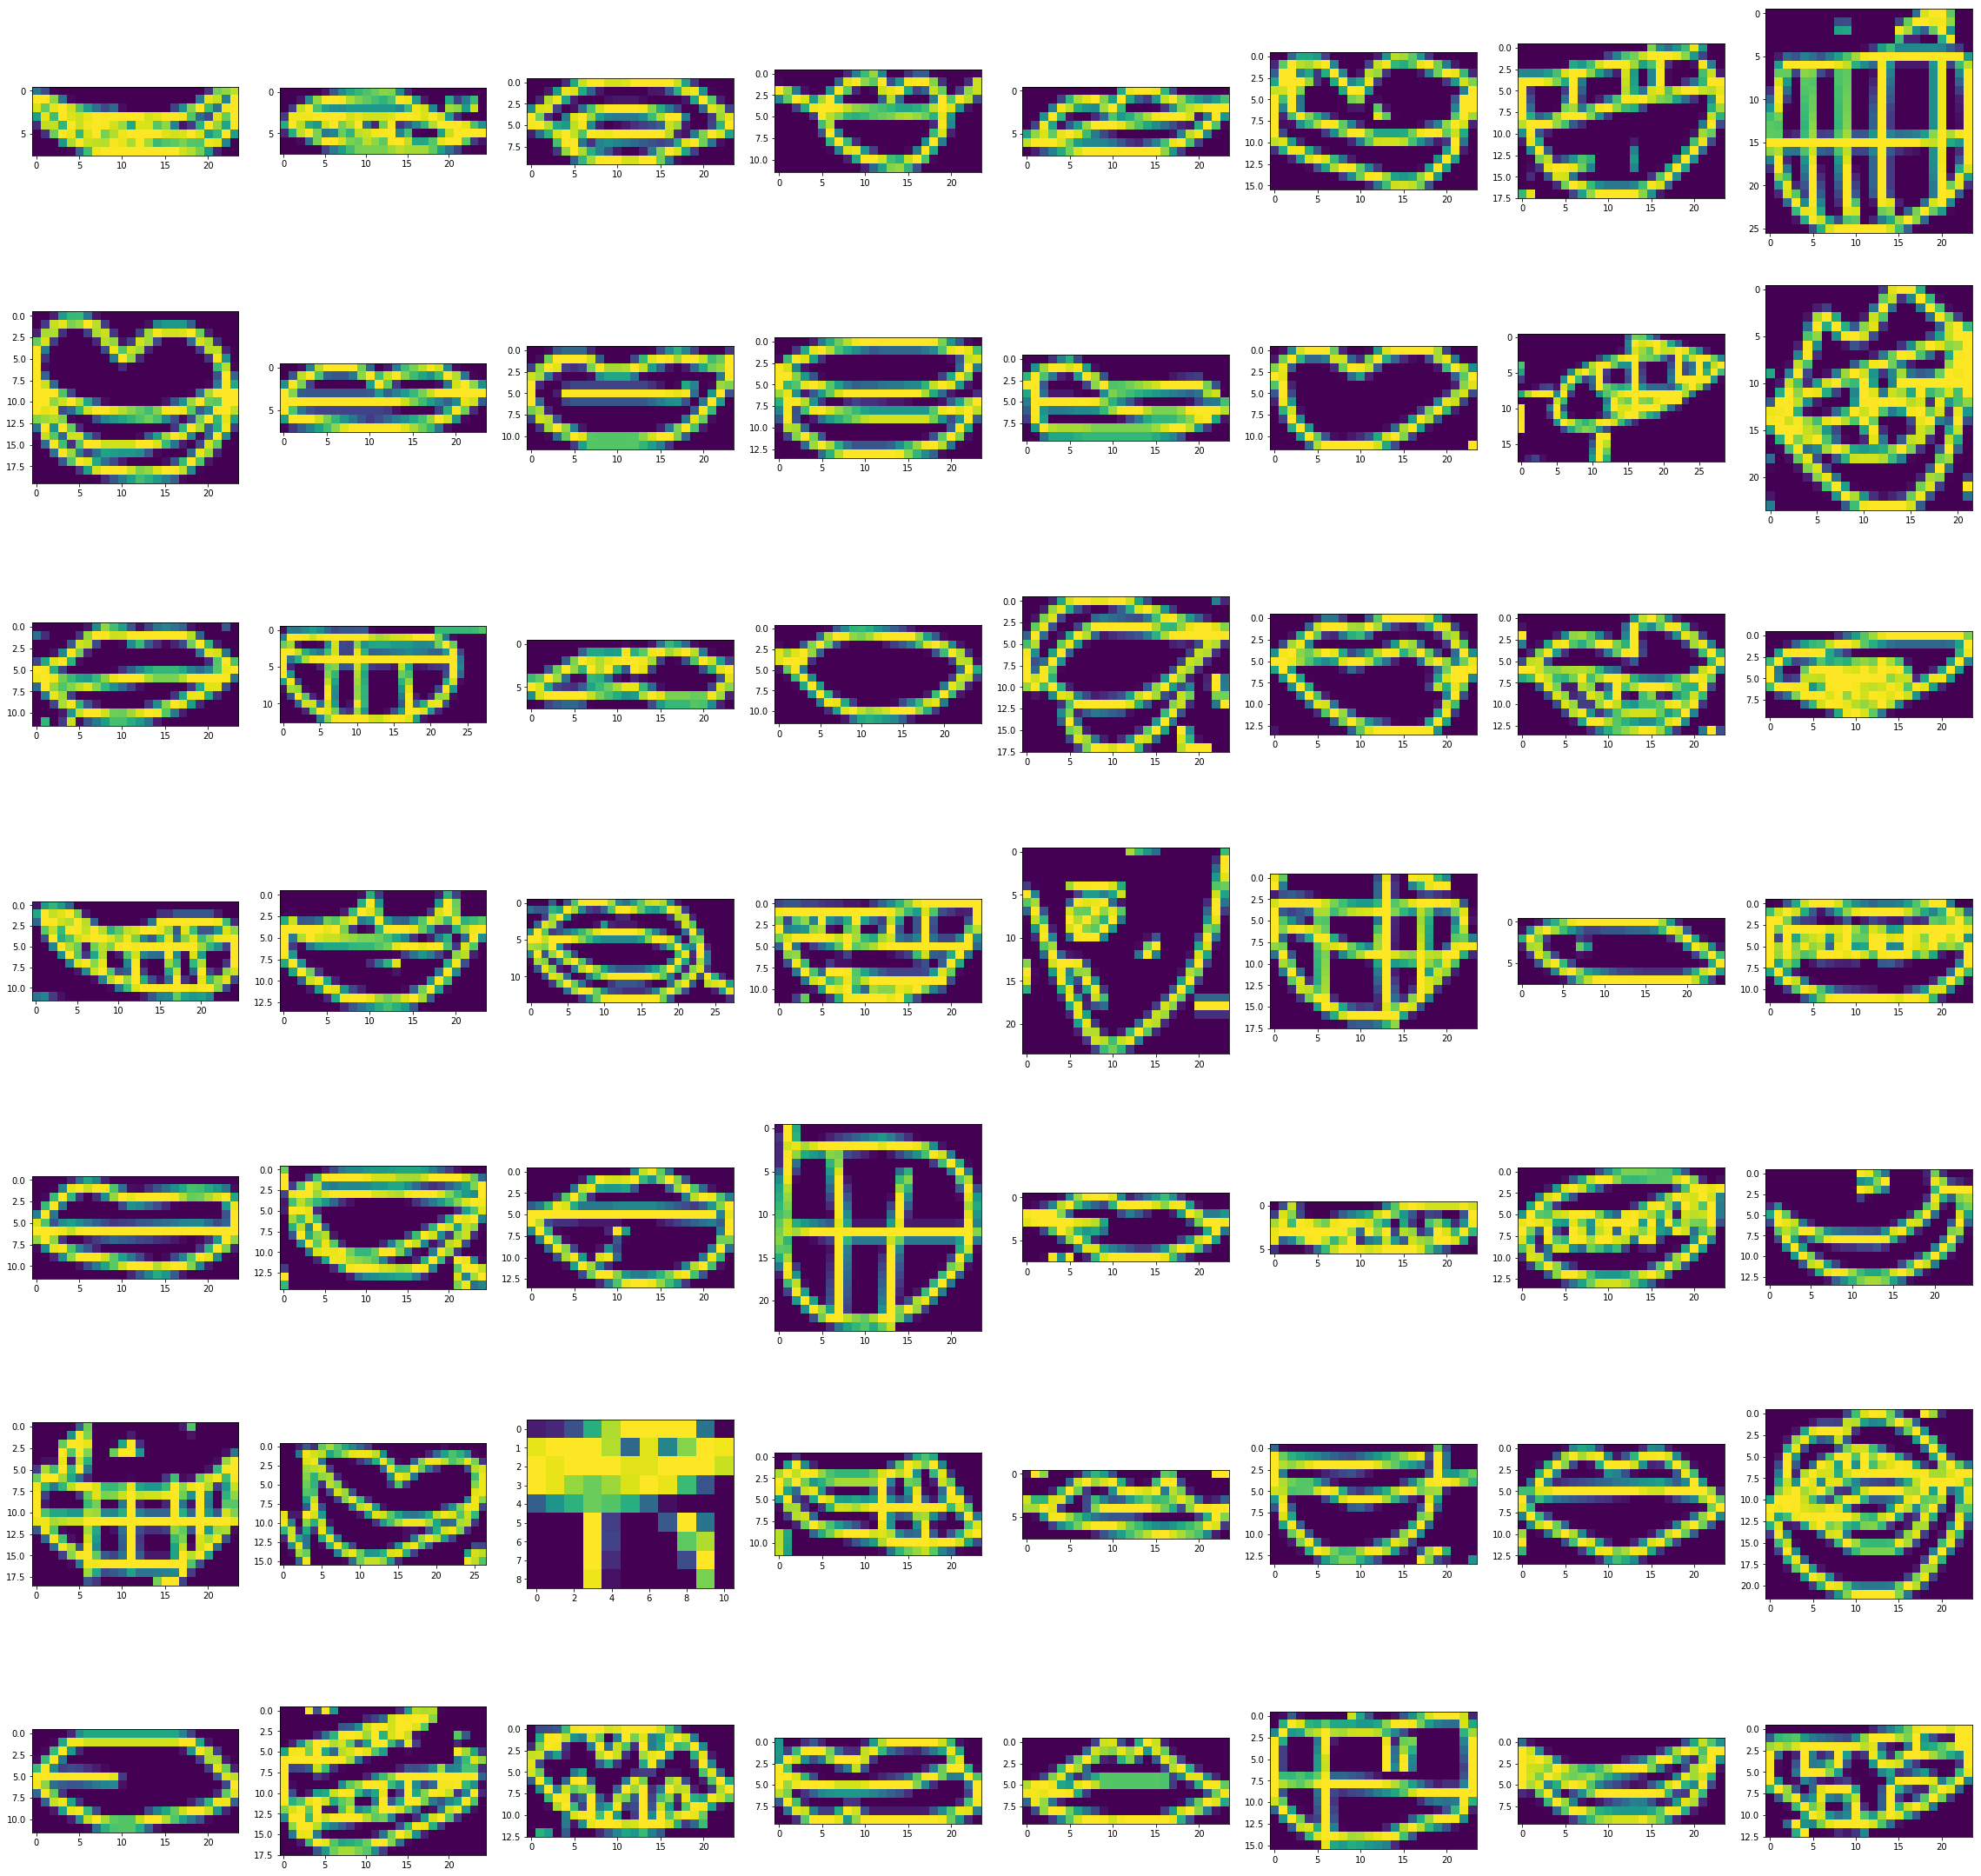

pineapple


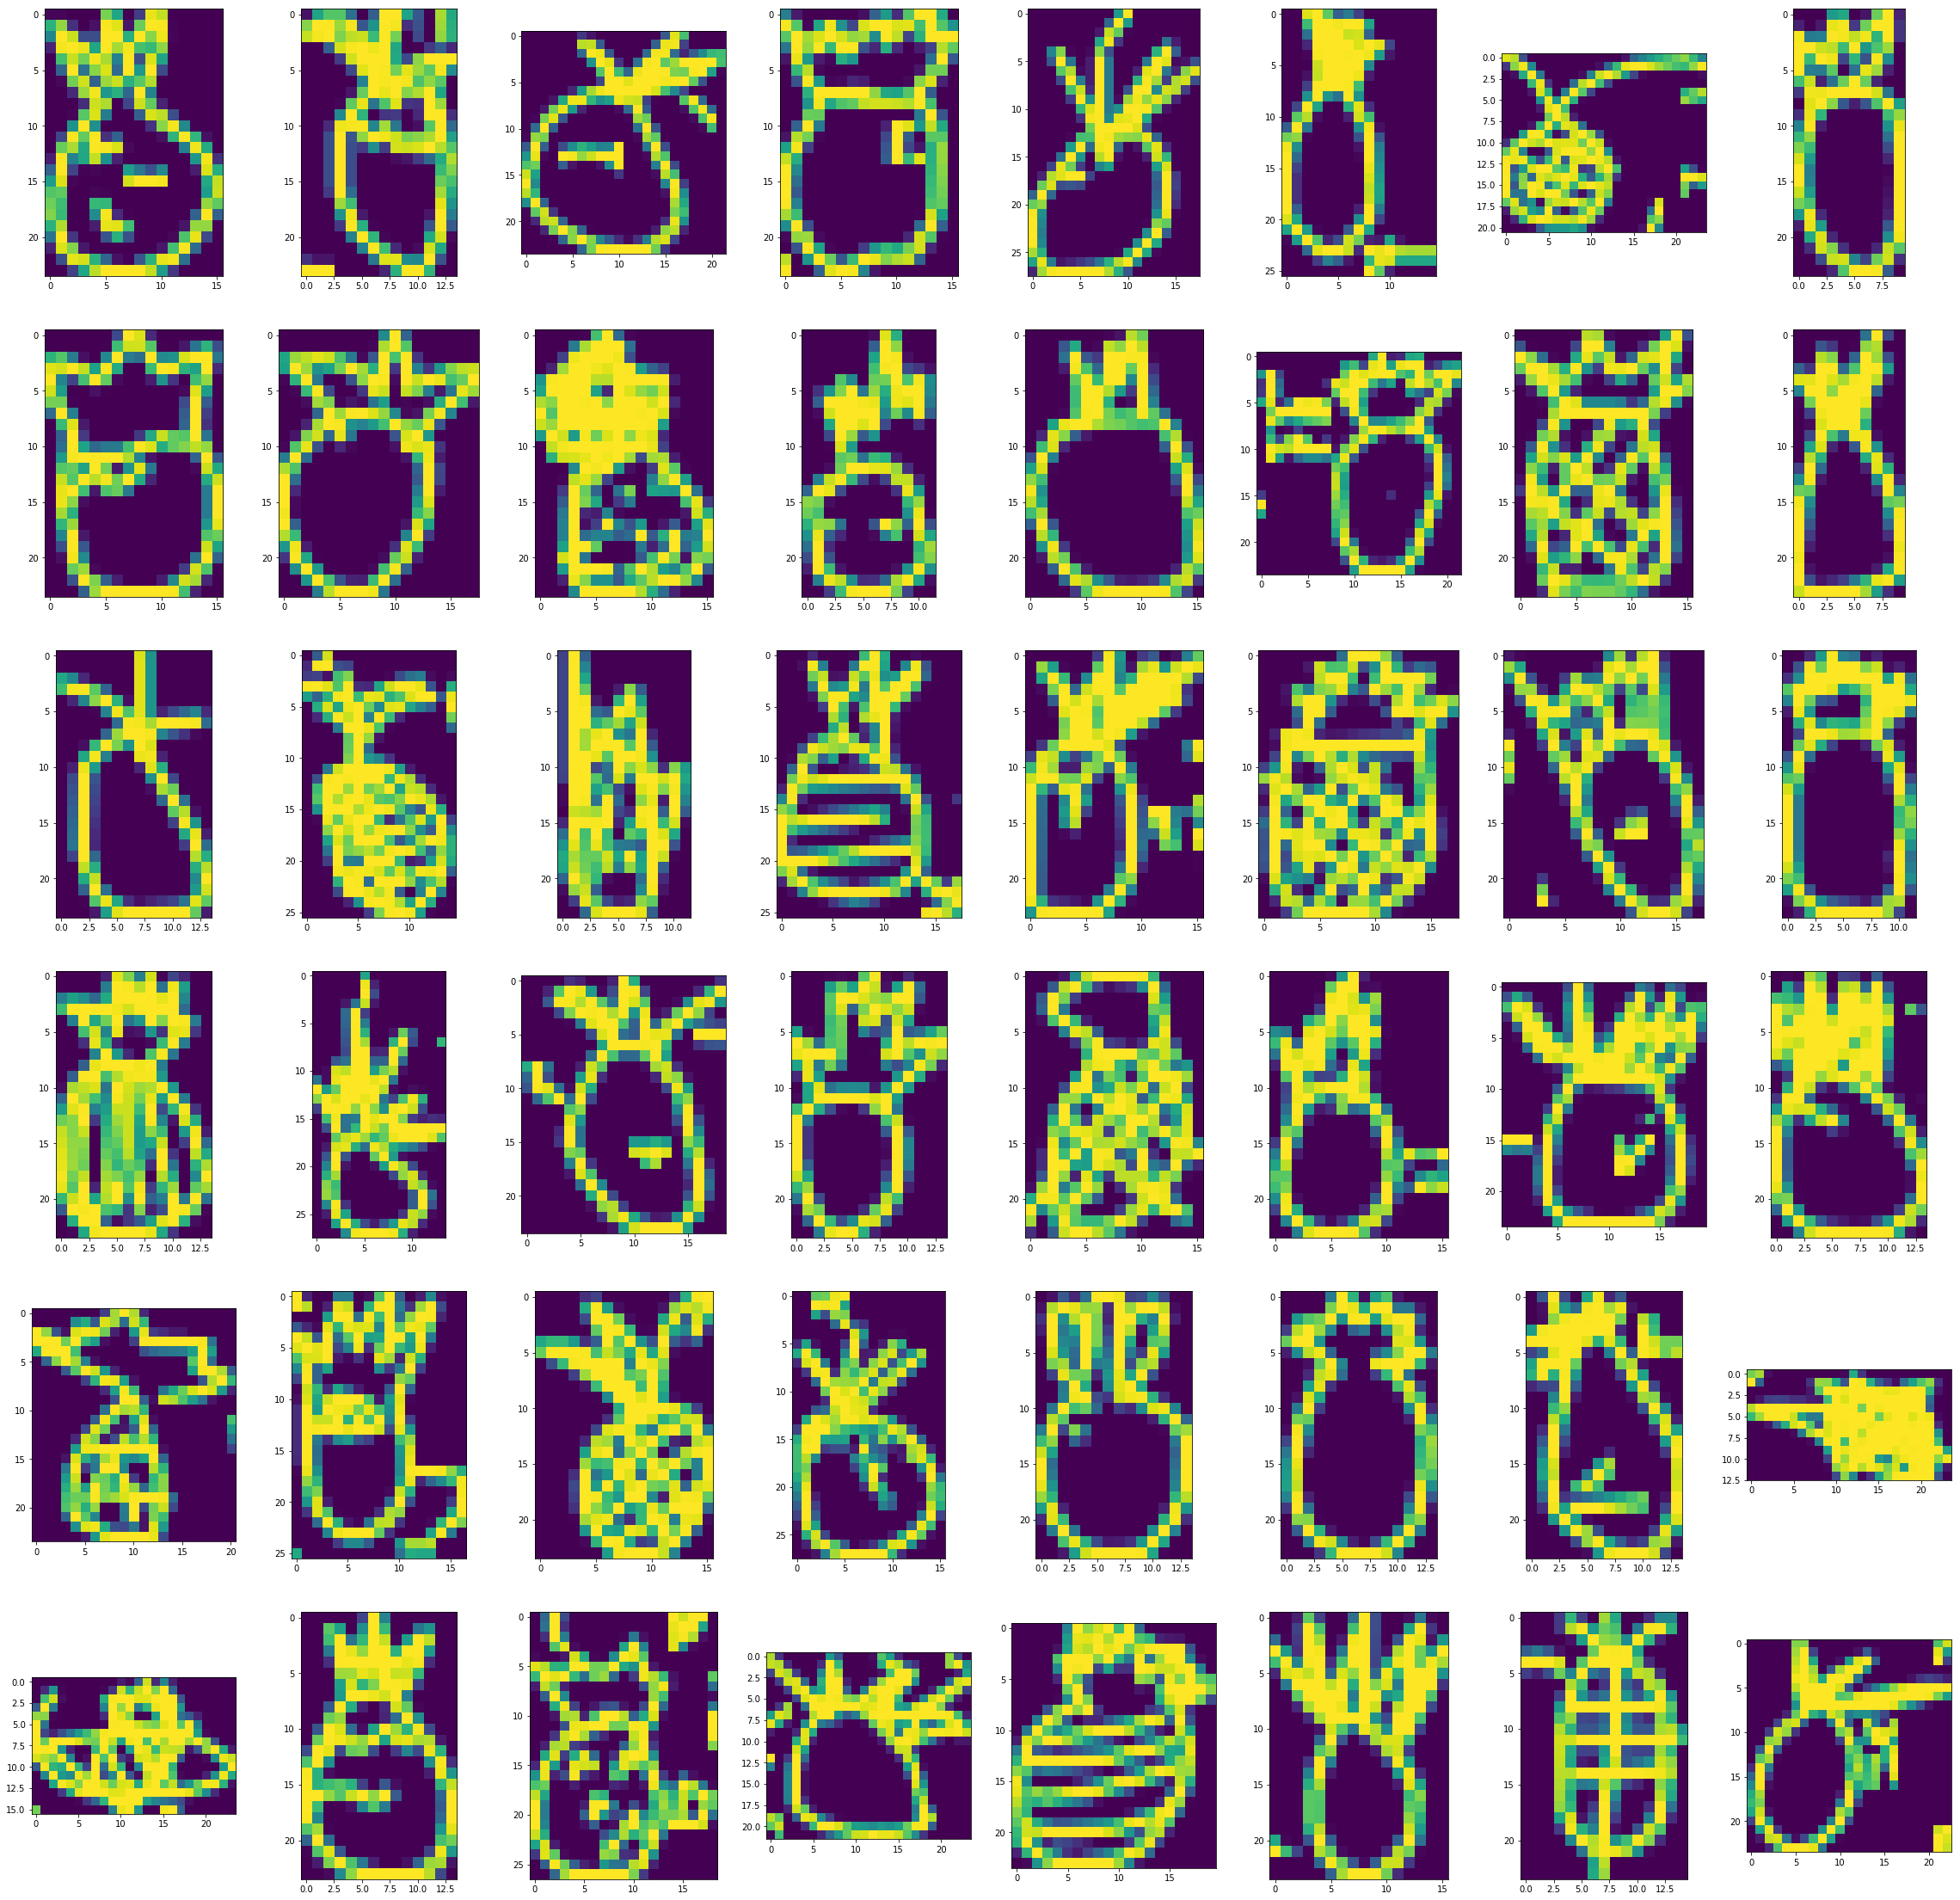

rifle


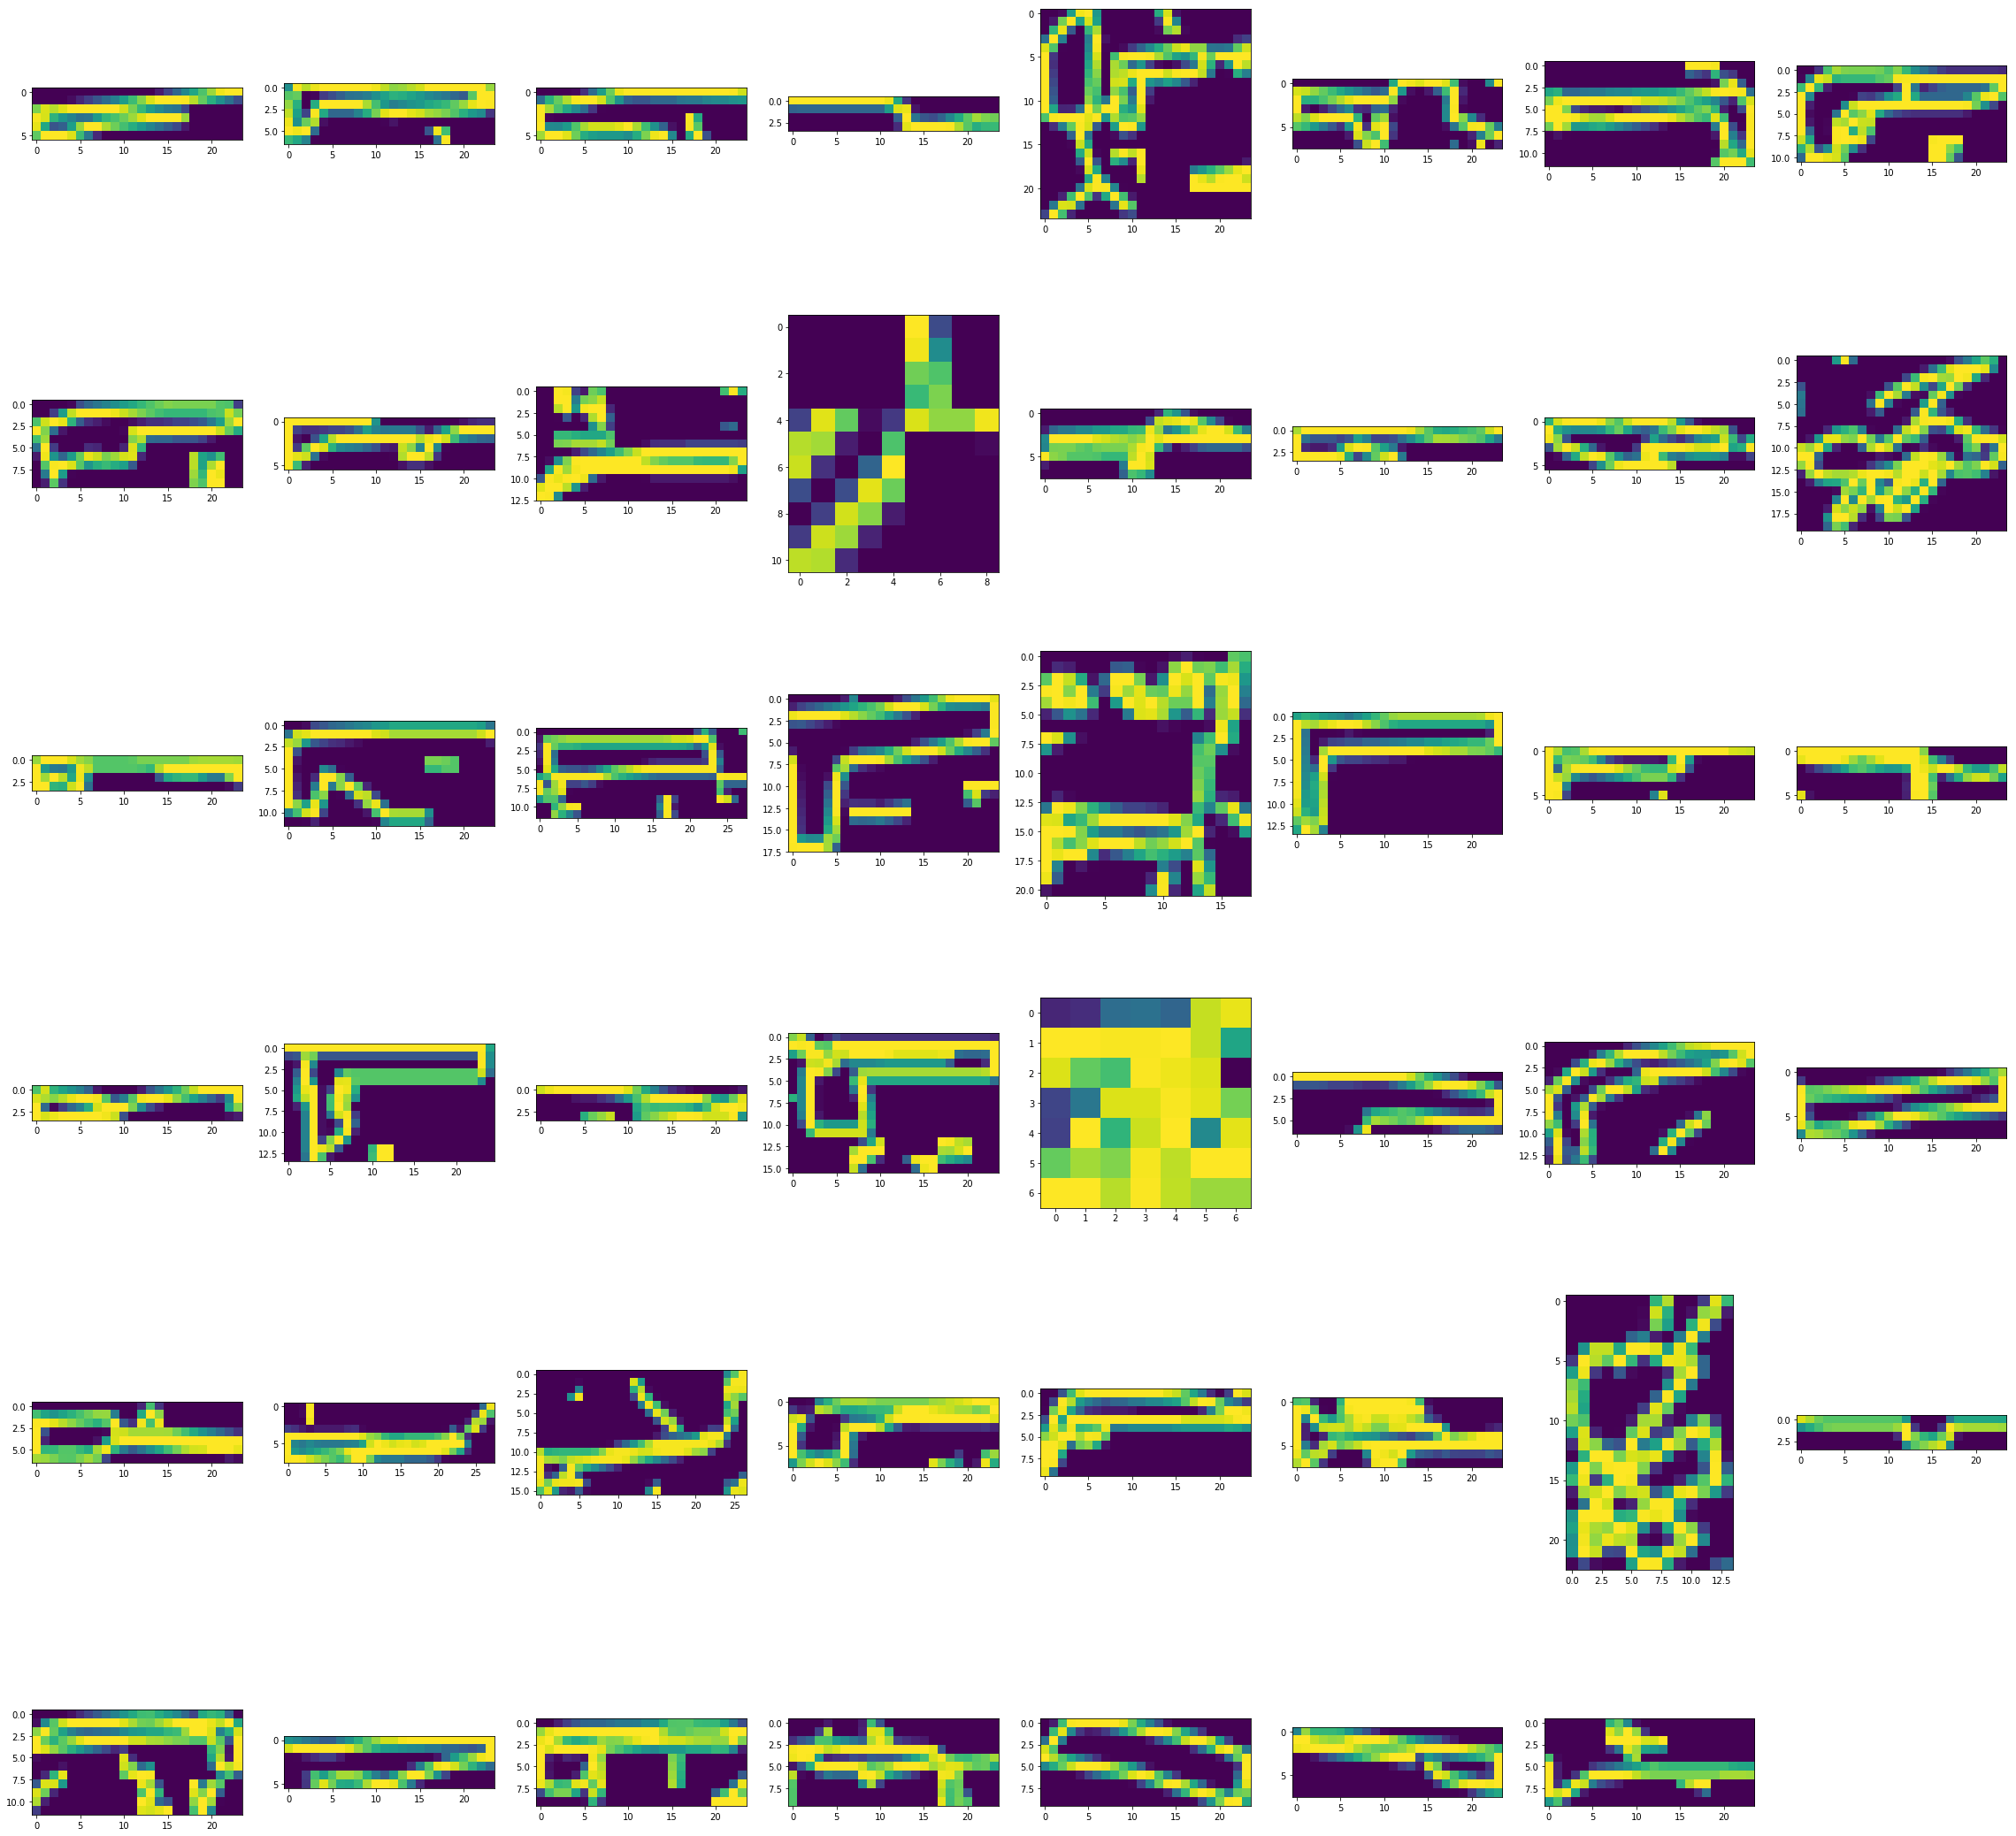

octagon


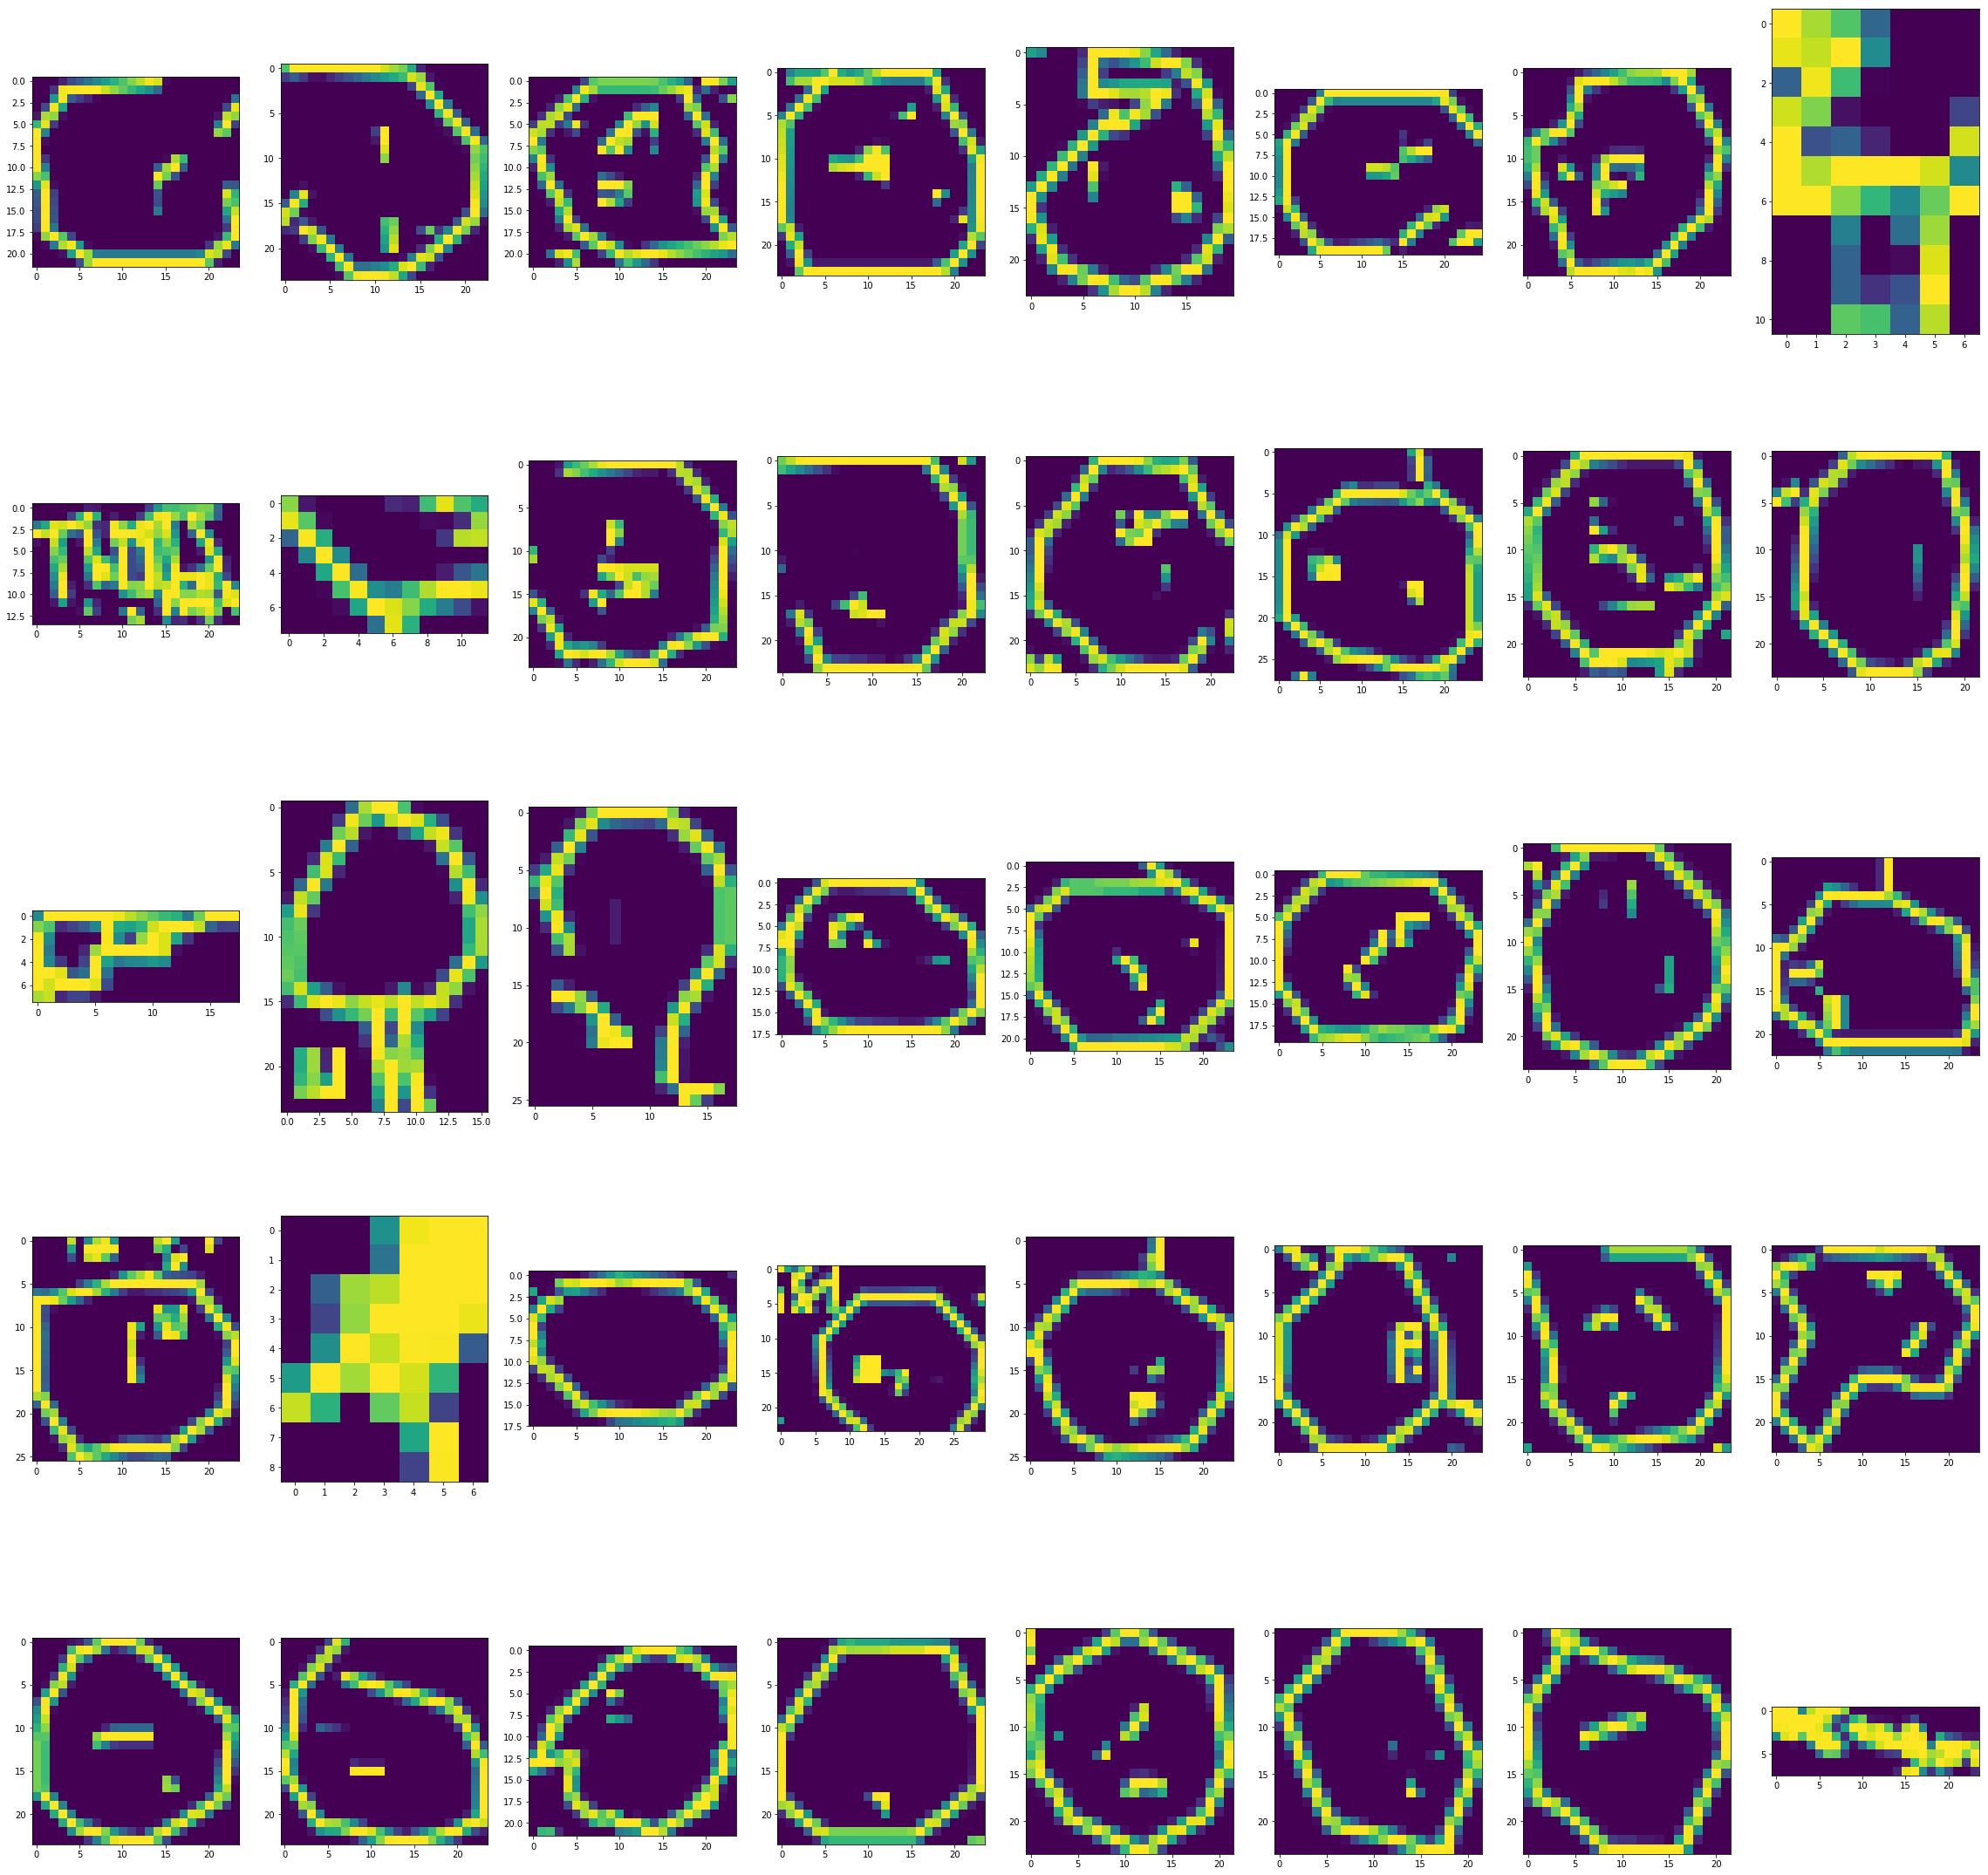

paintbrush


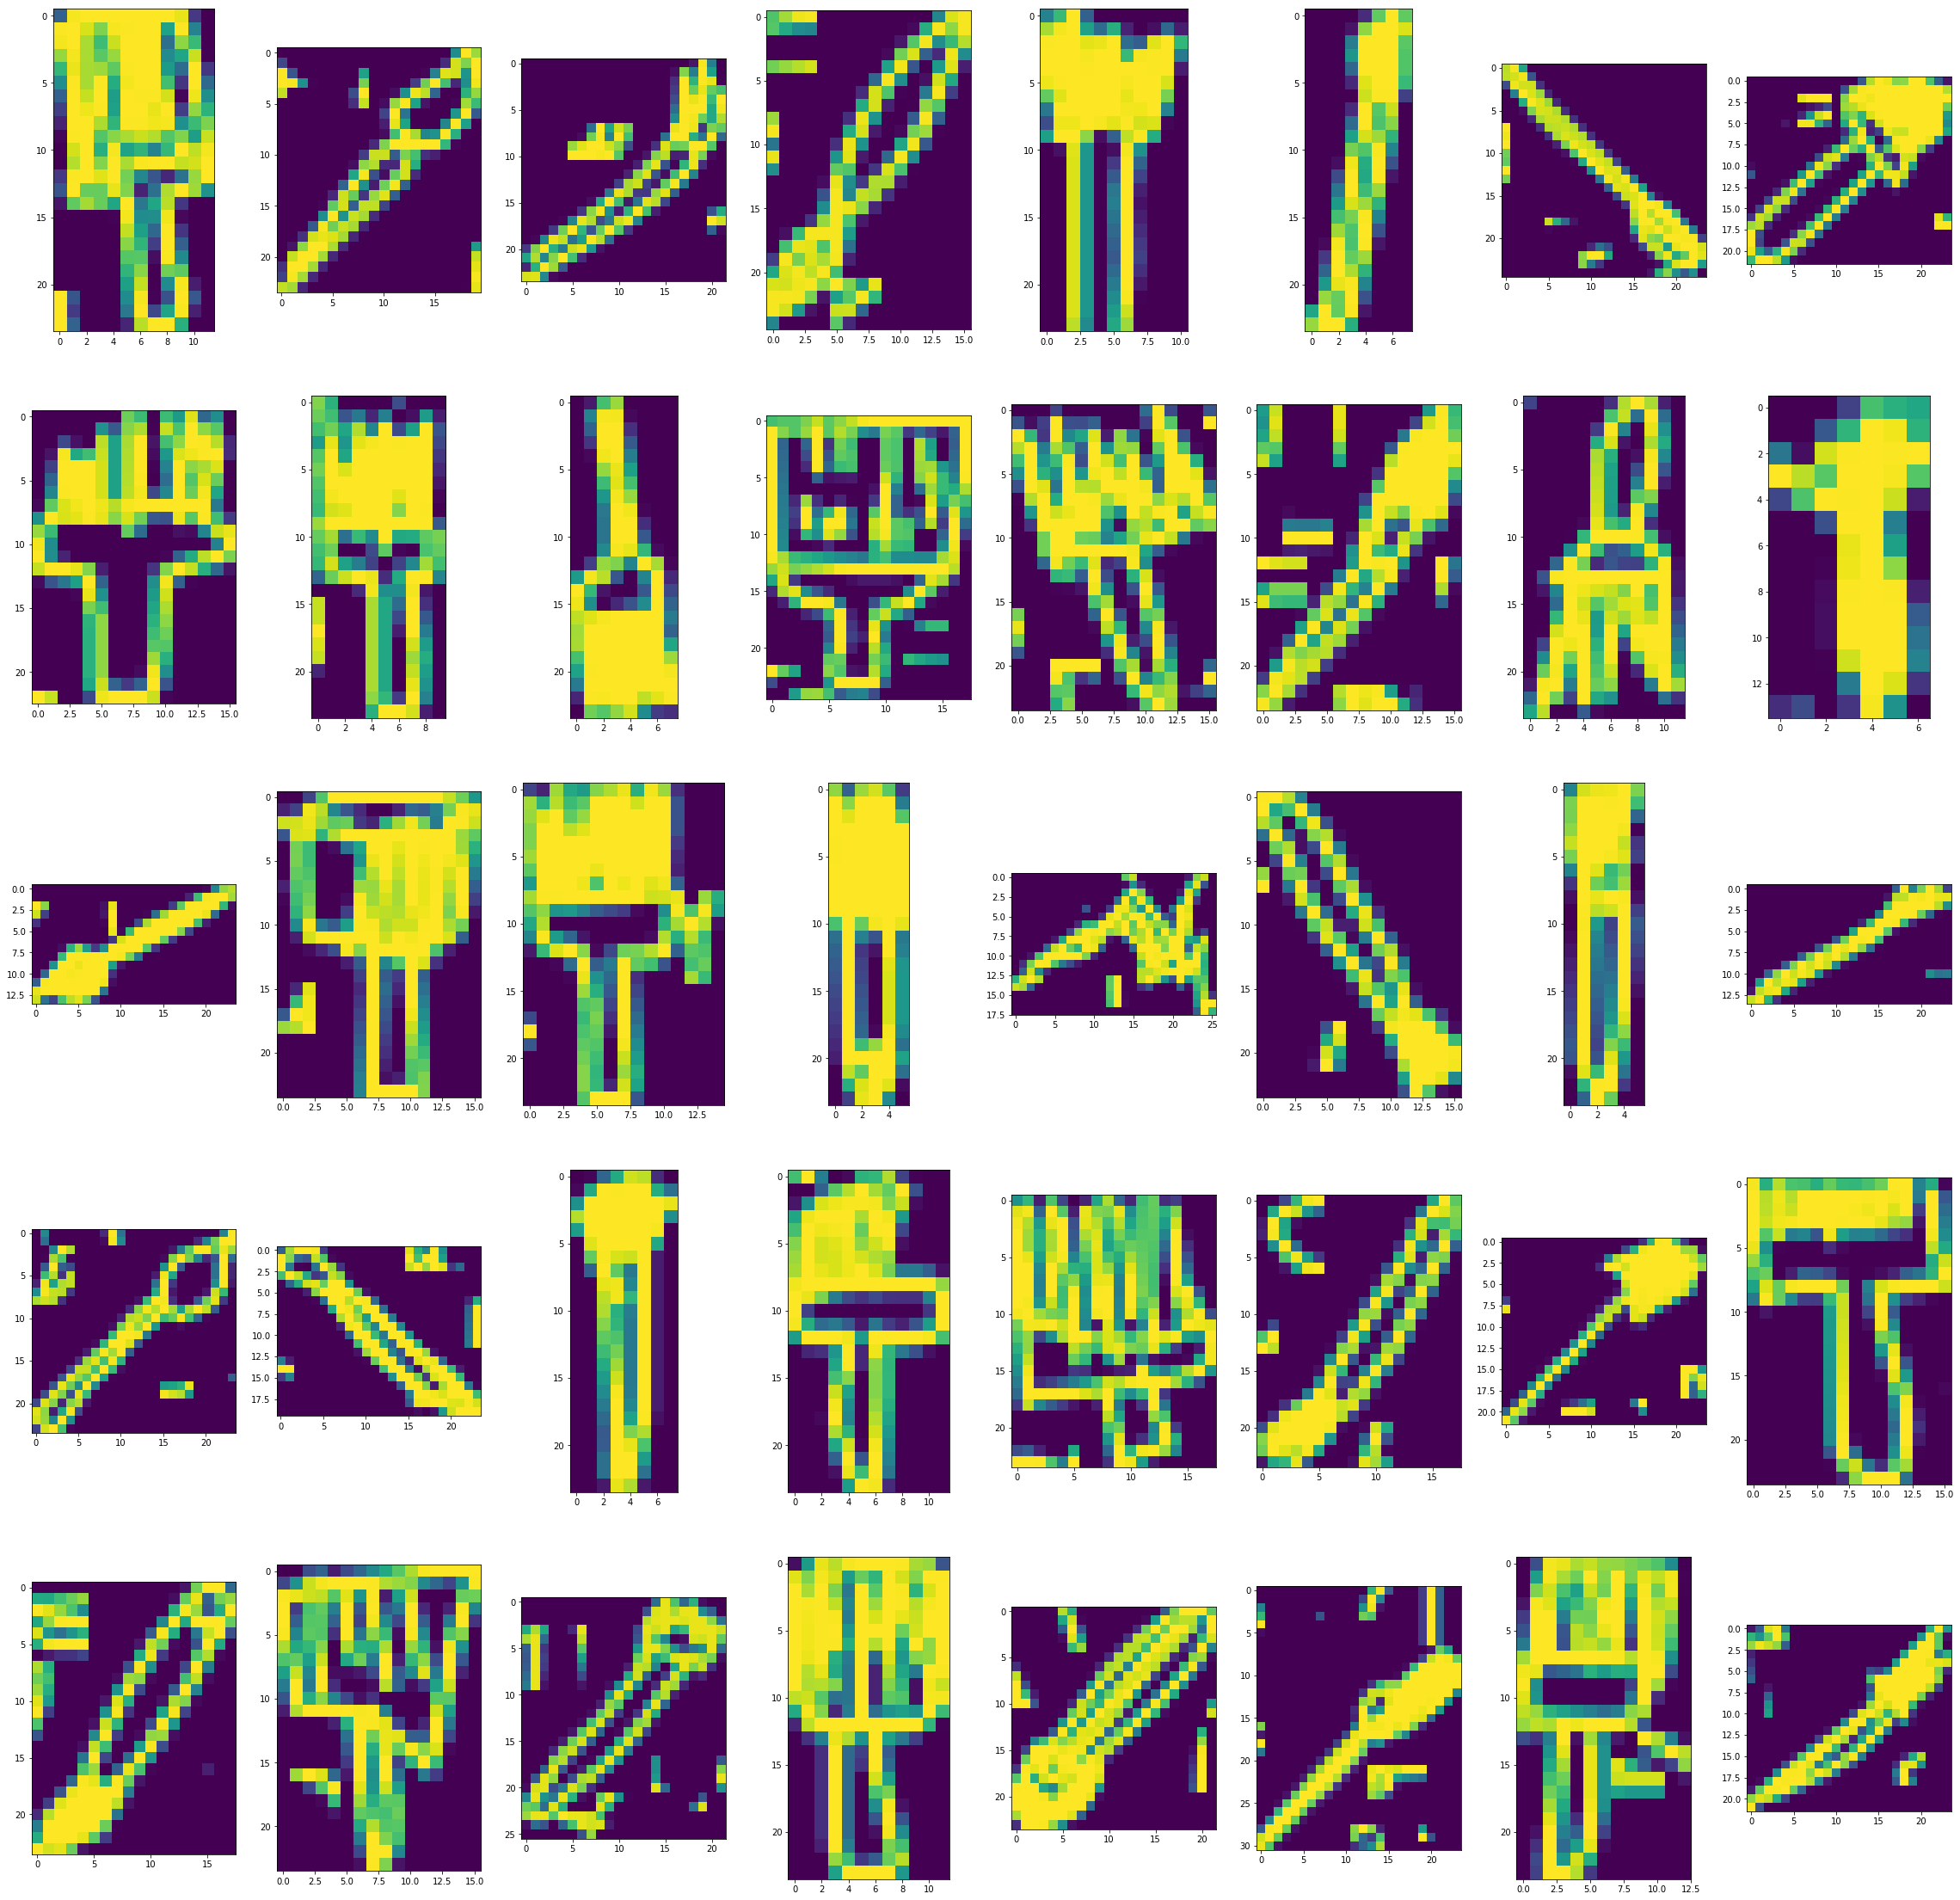

nail


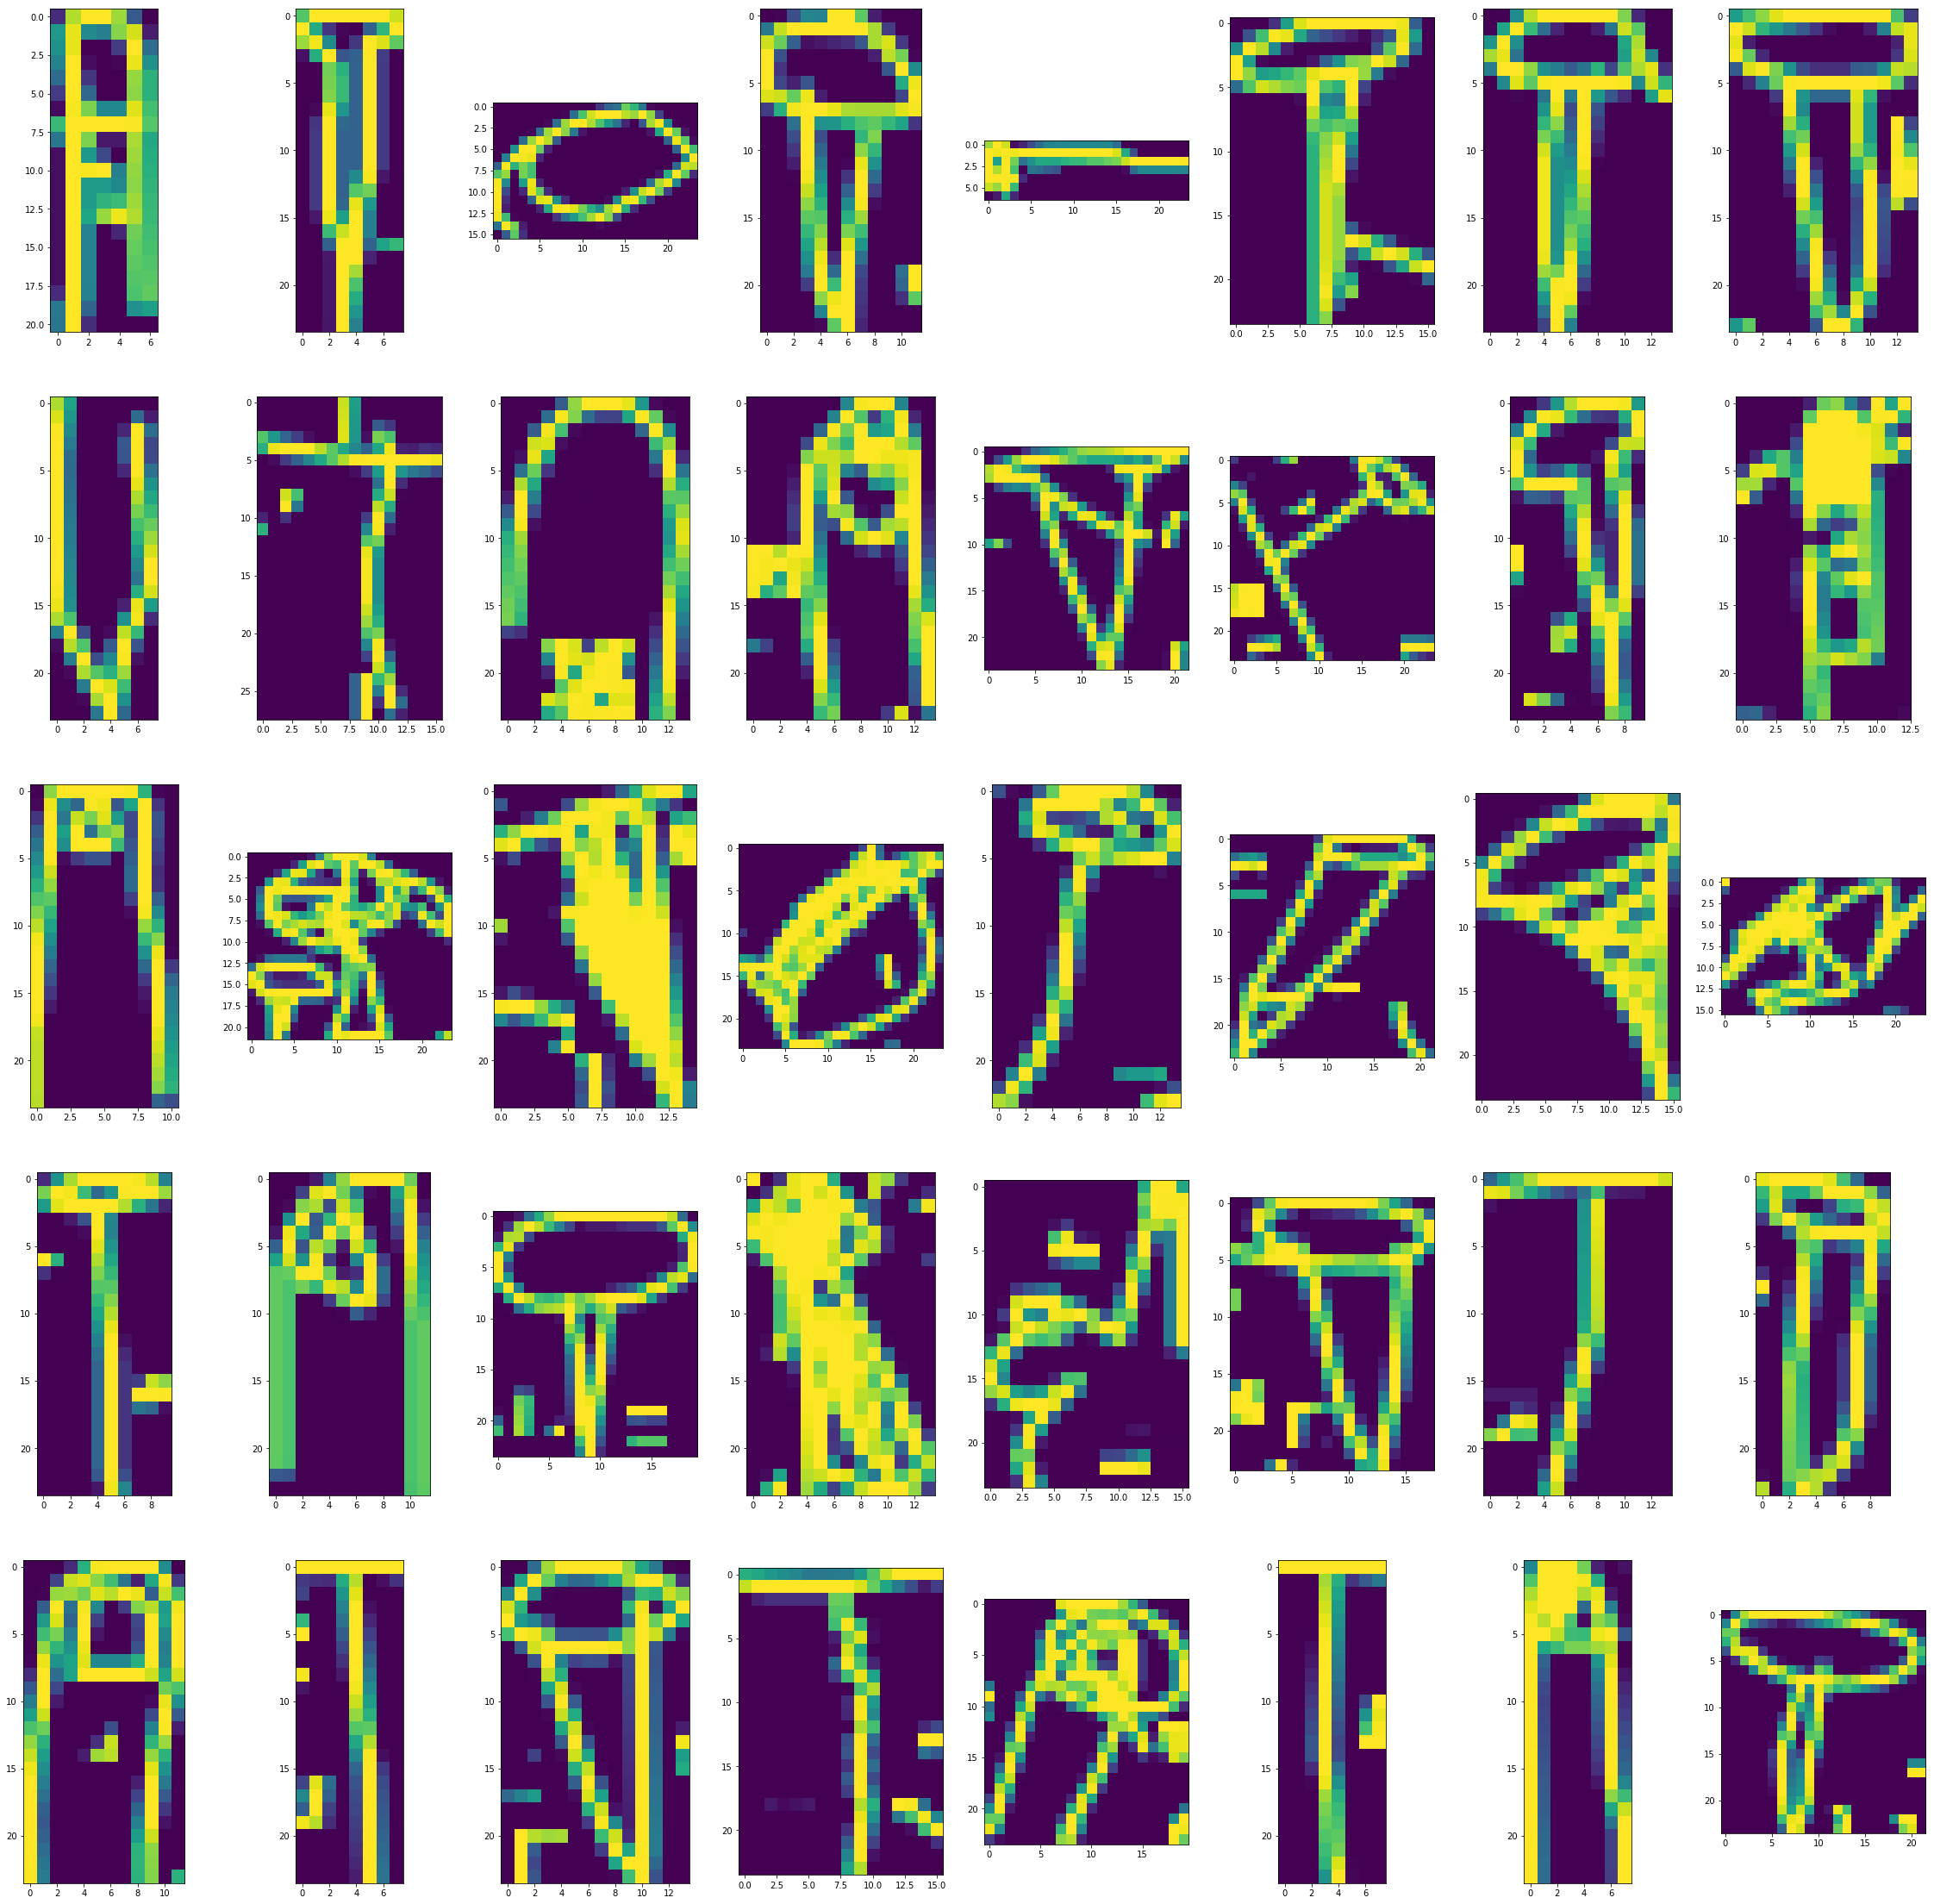

sailboat


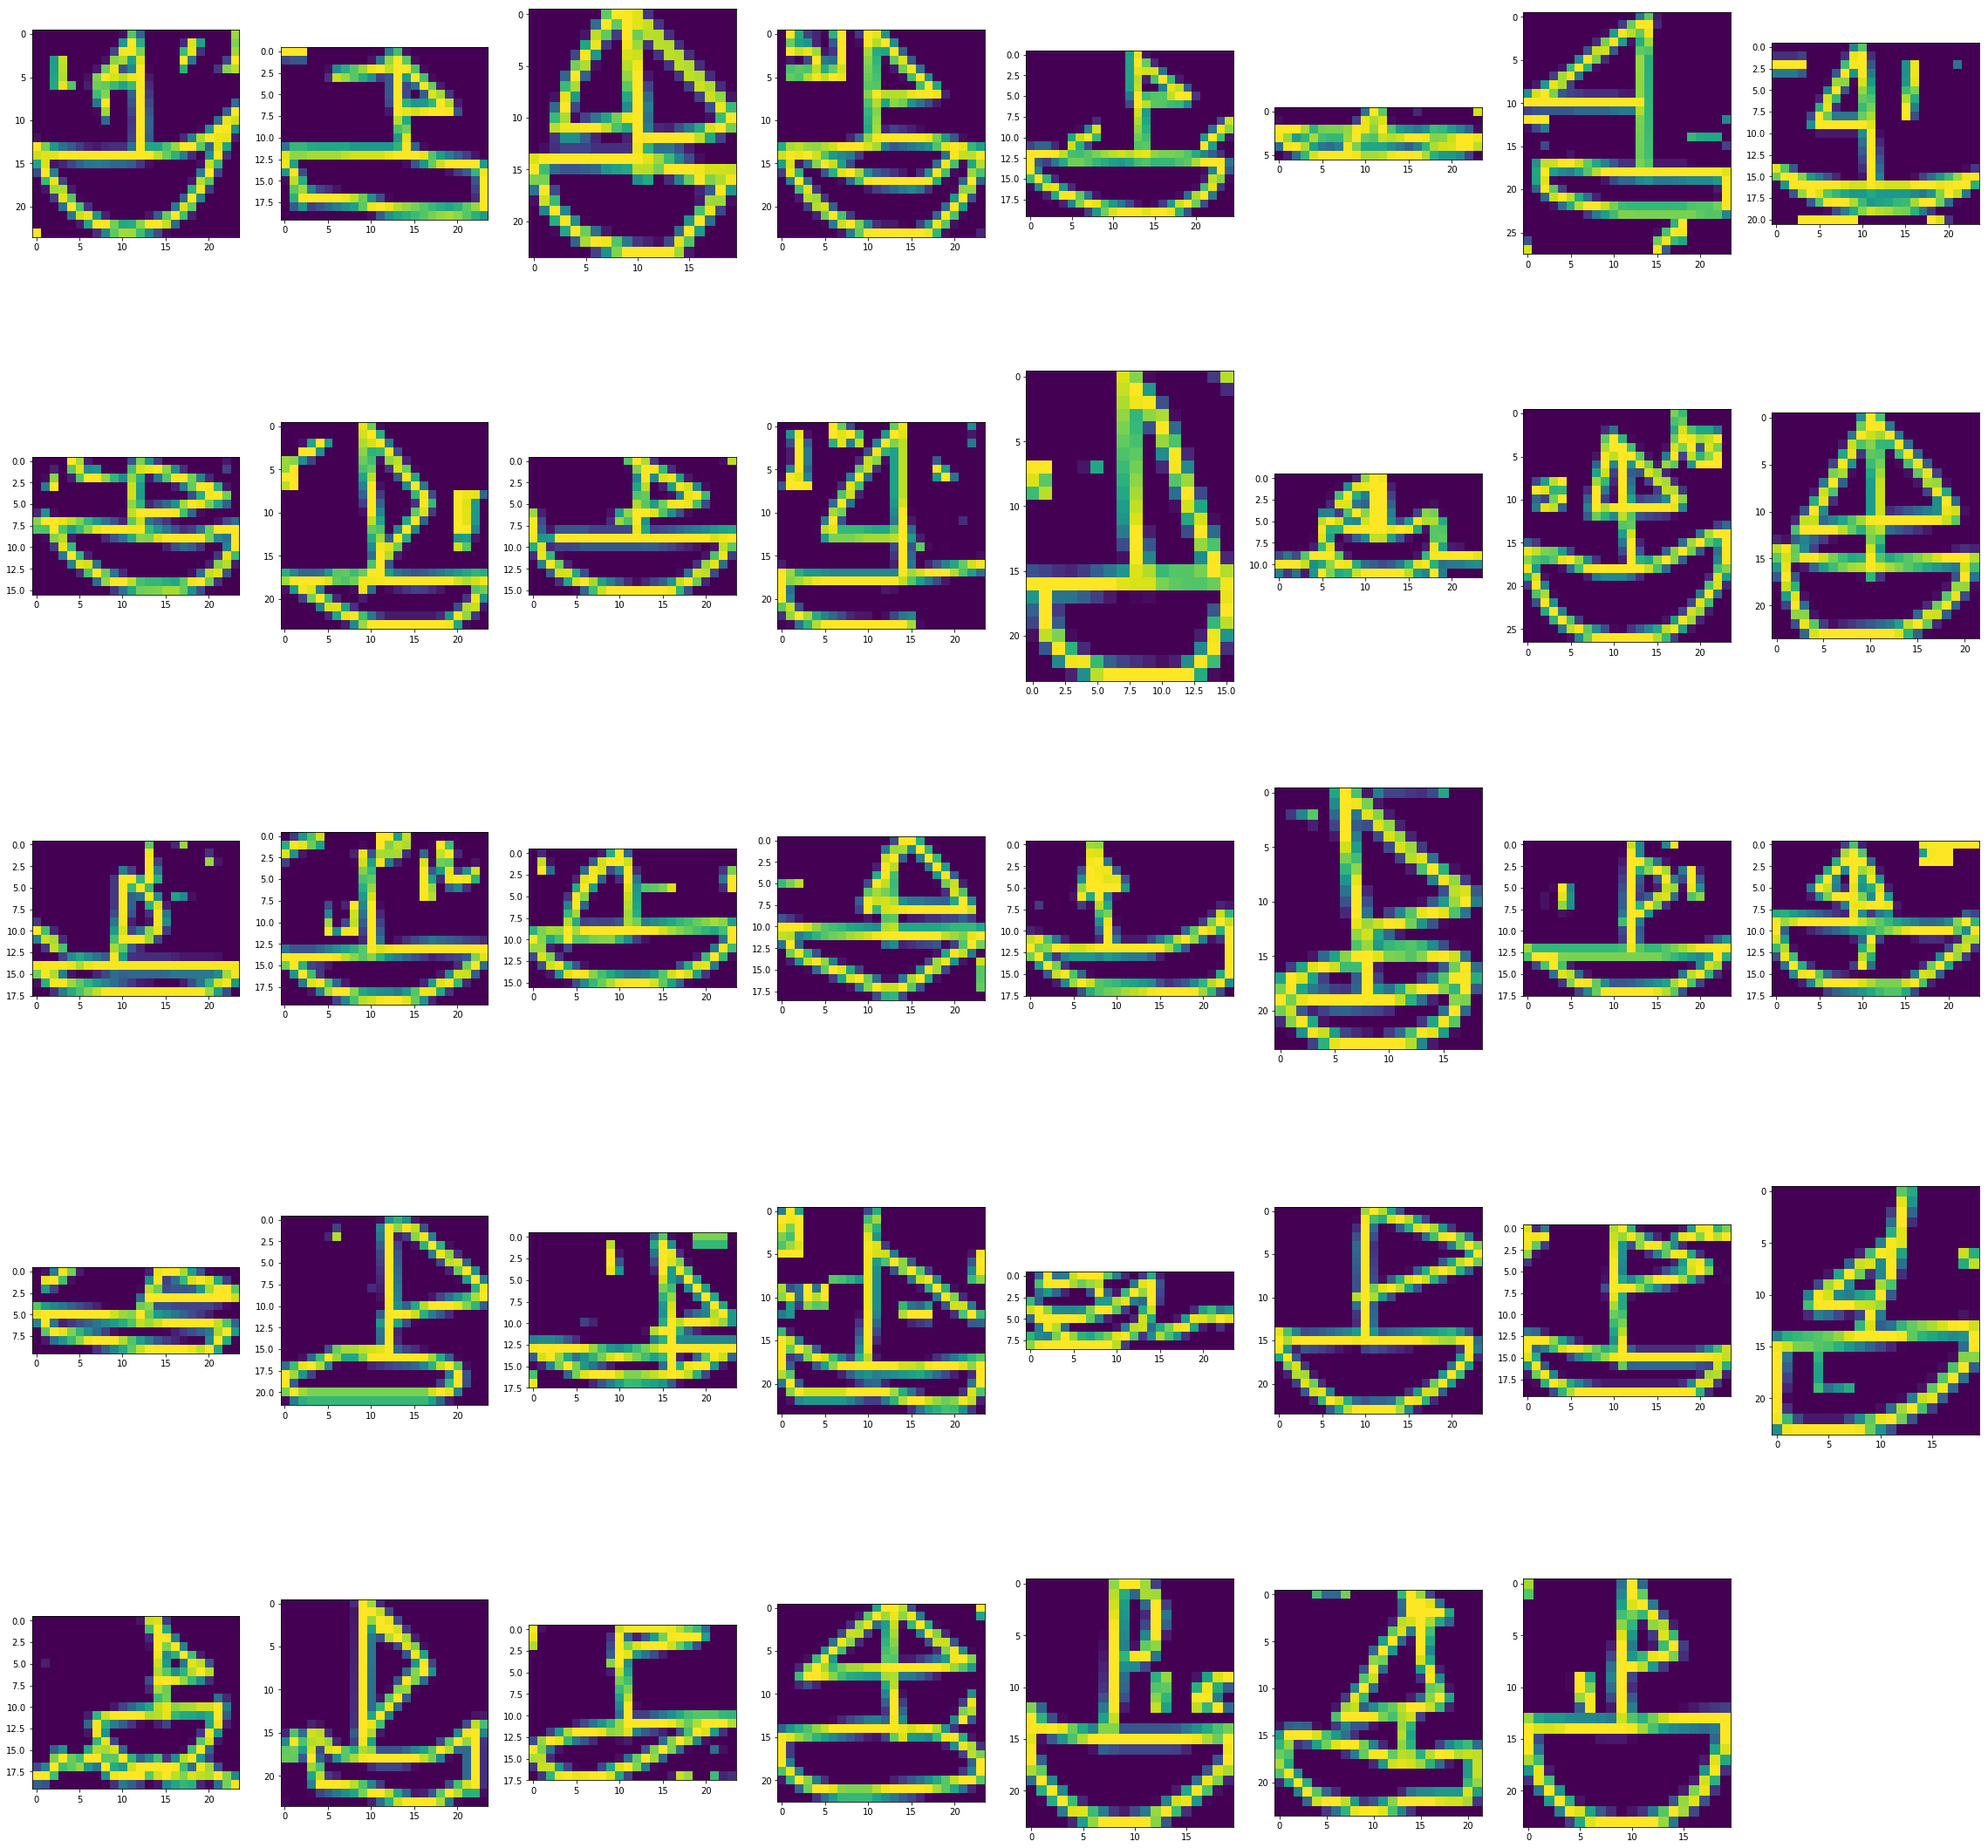

pool


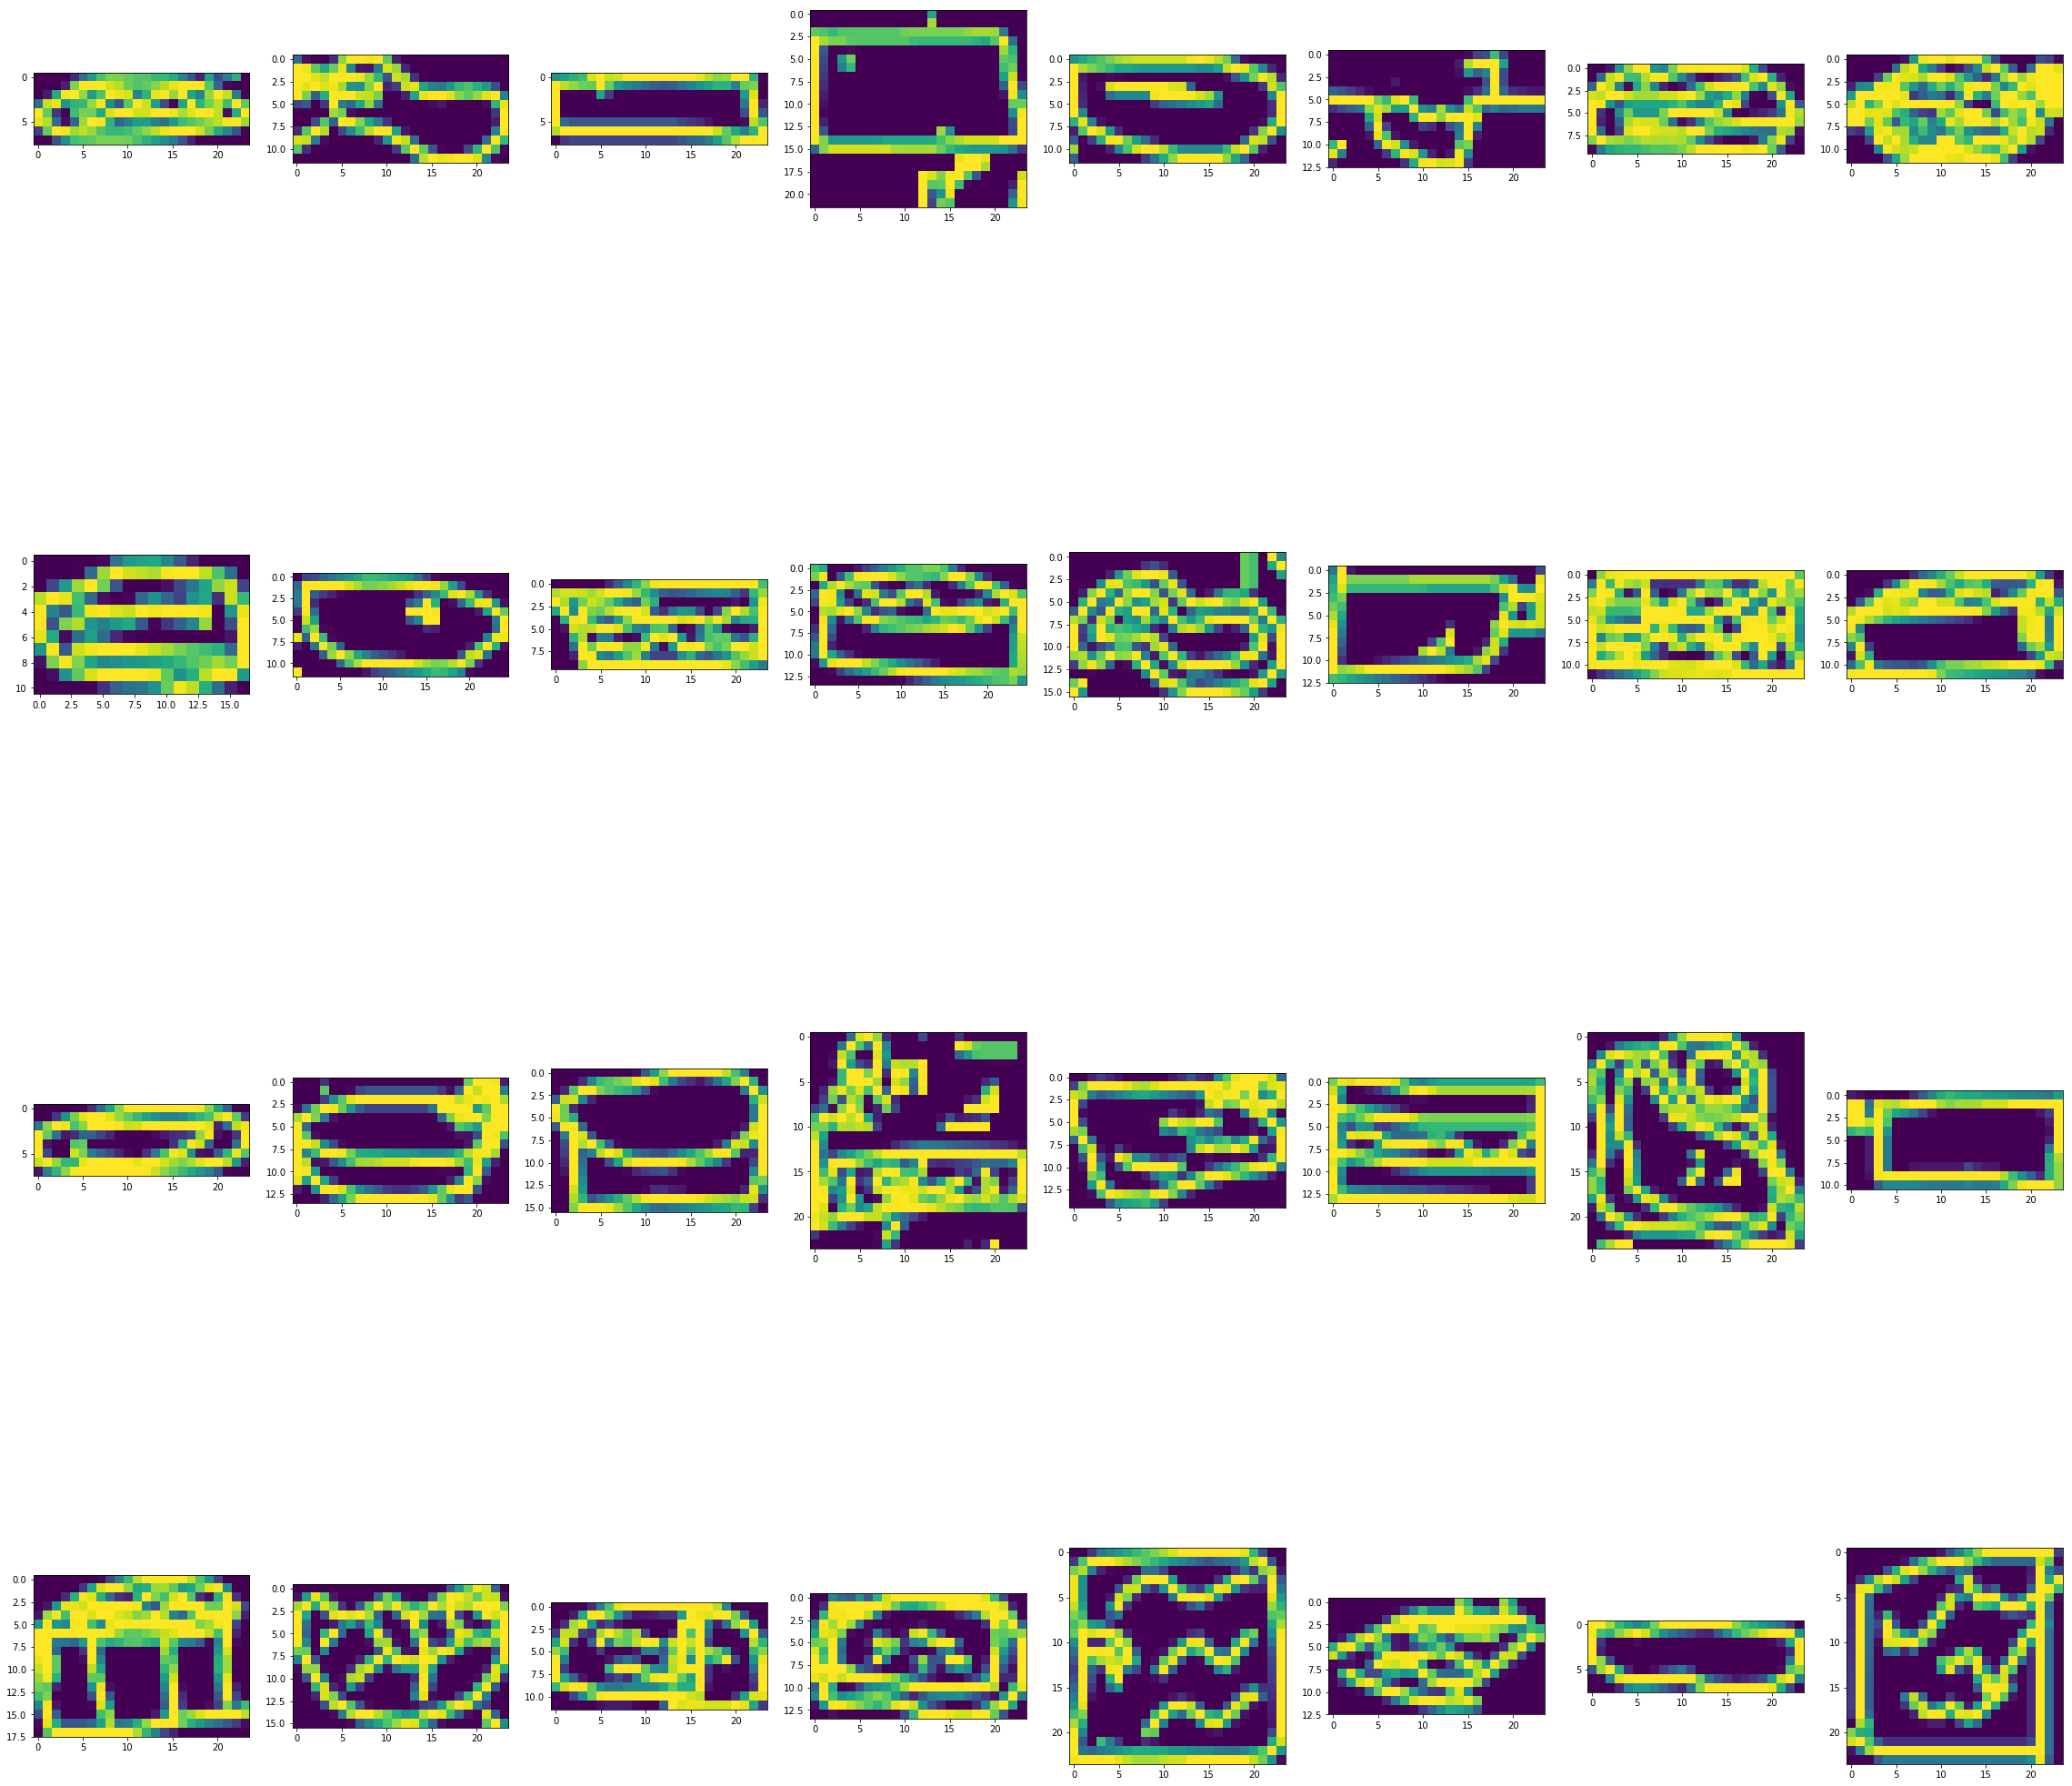

penguin


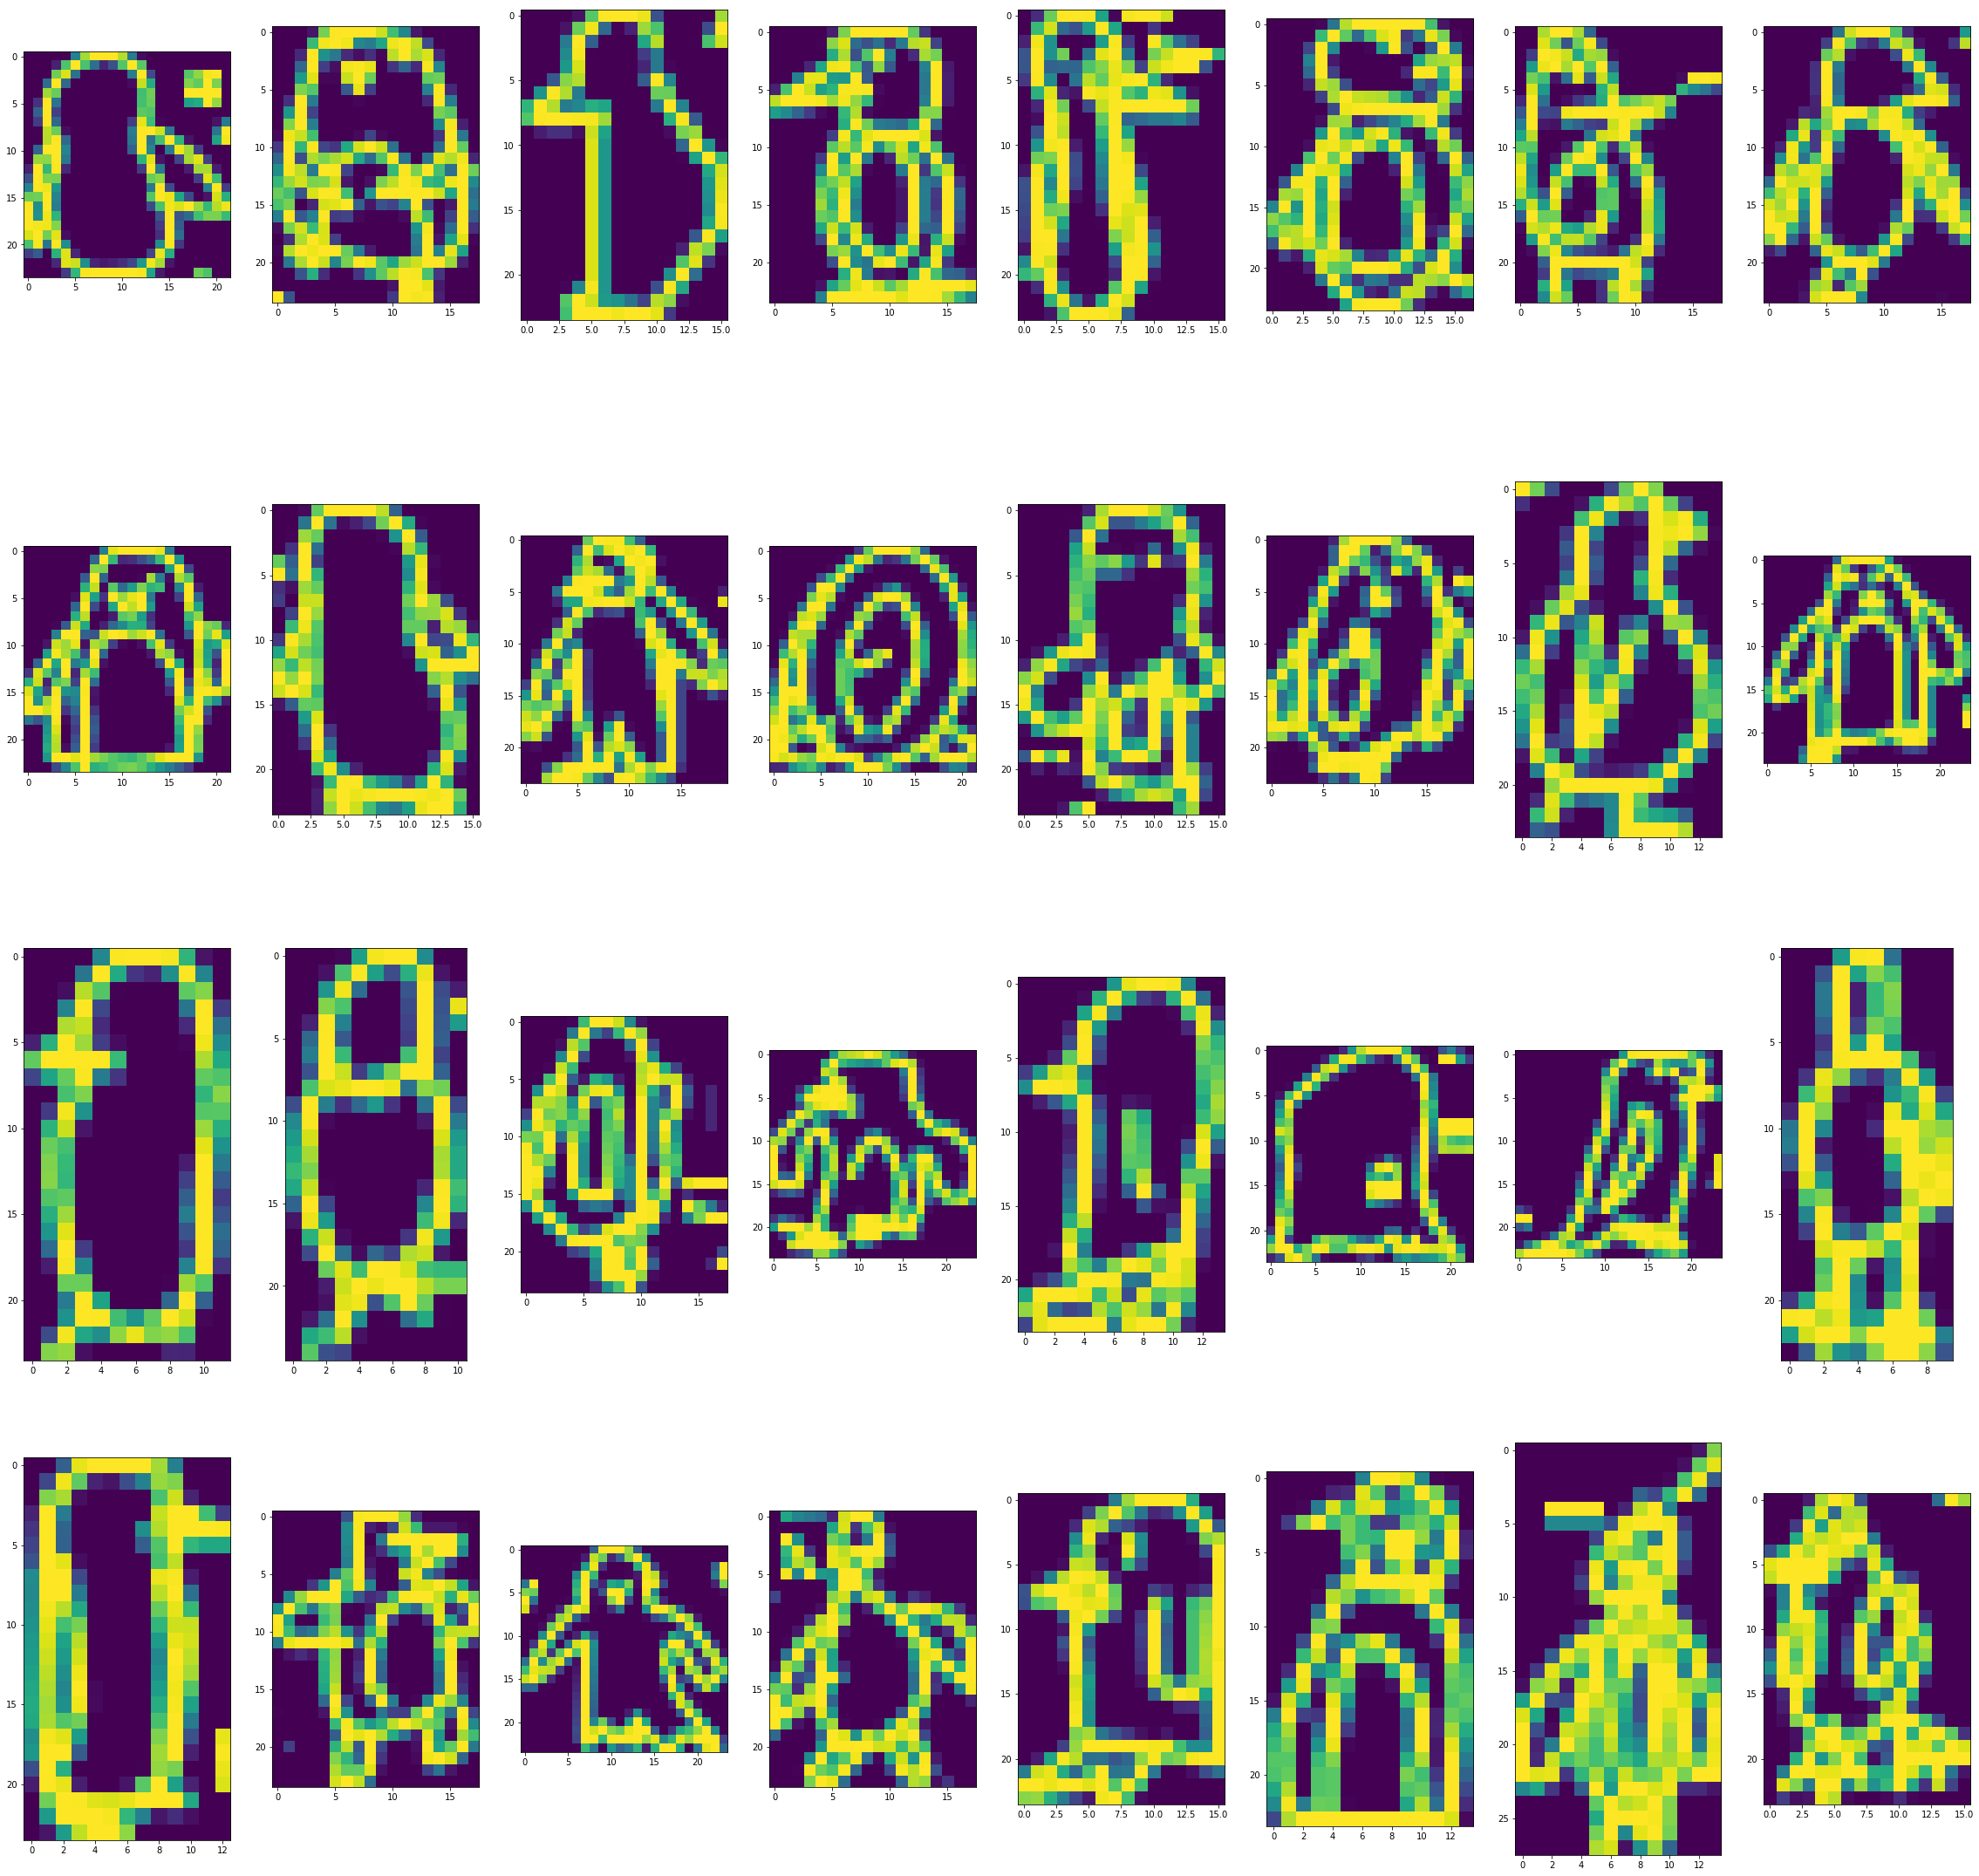

apple


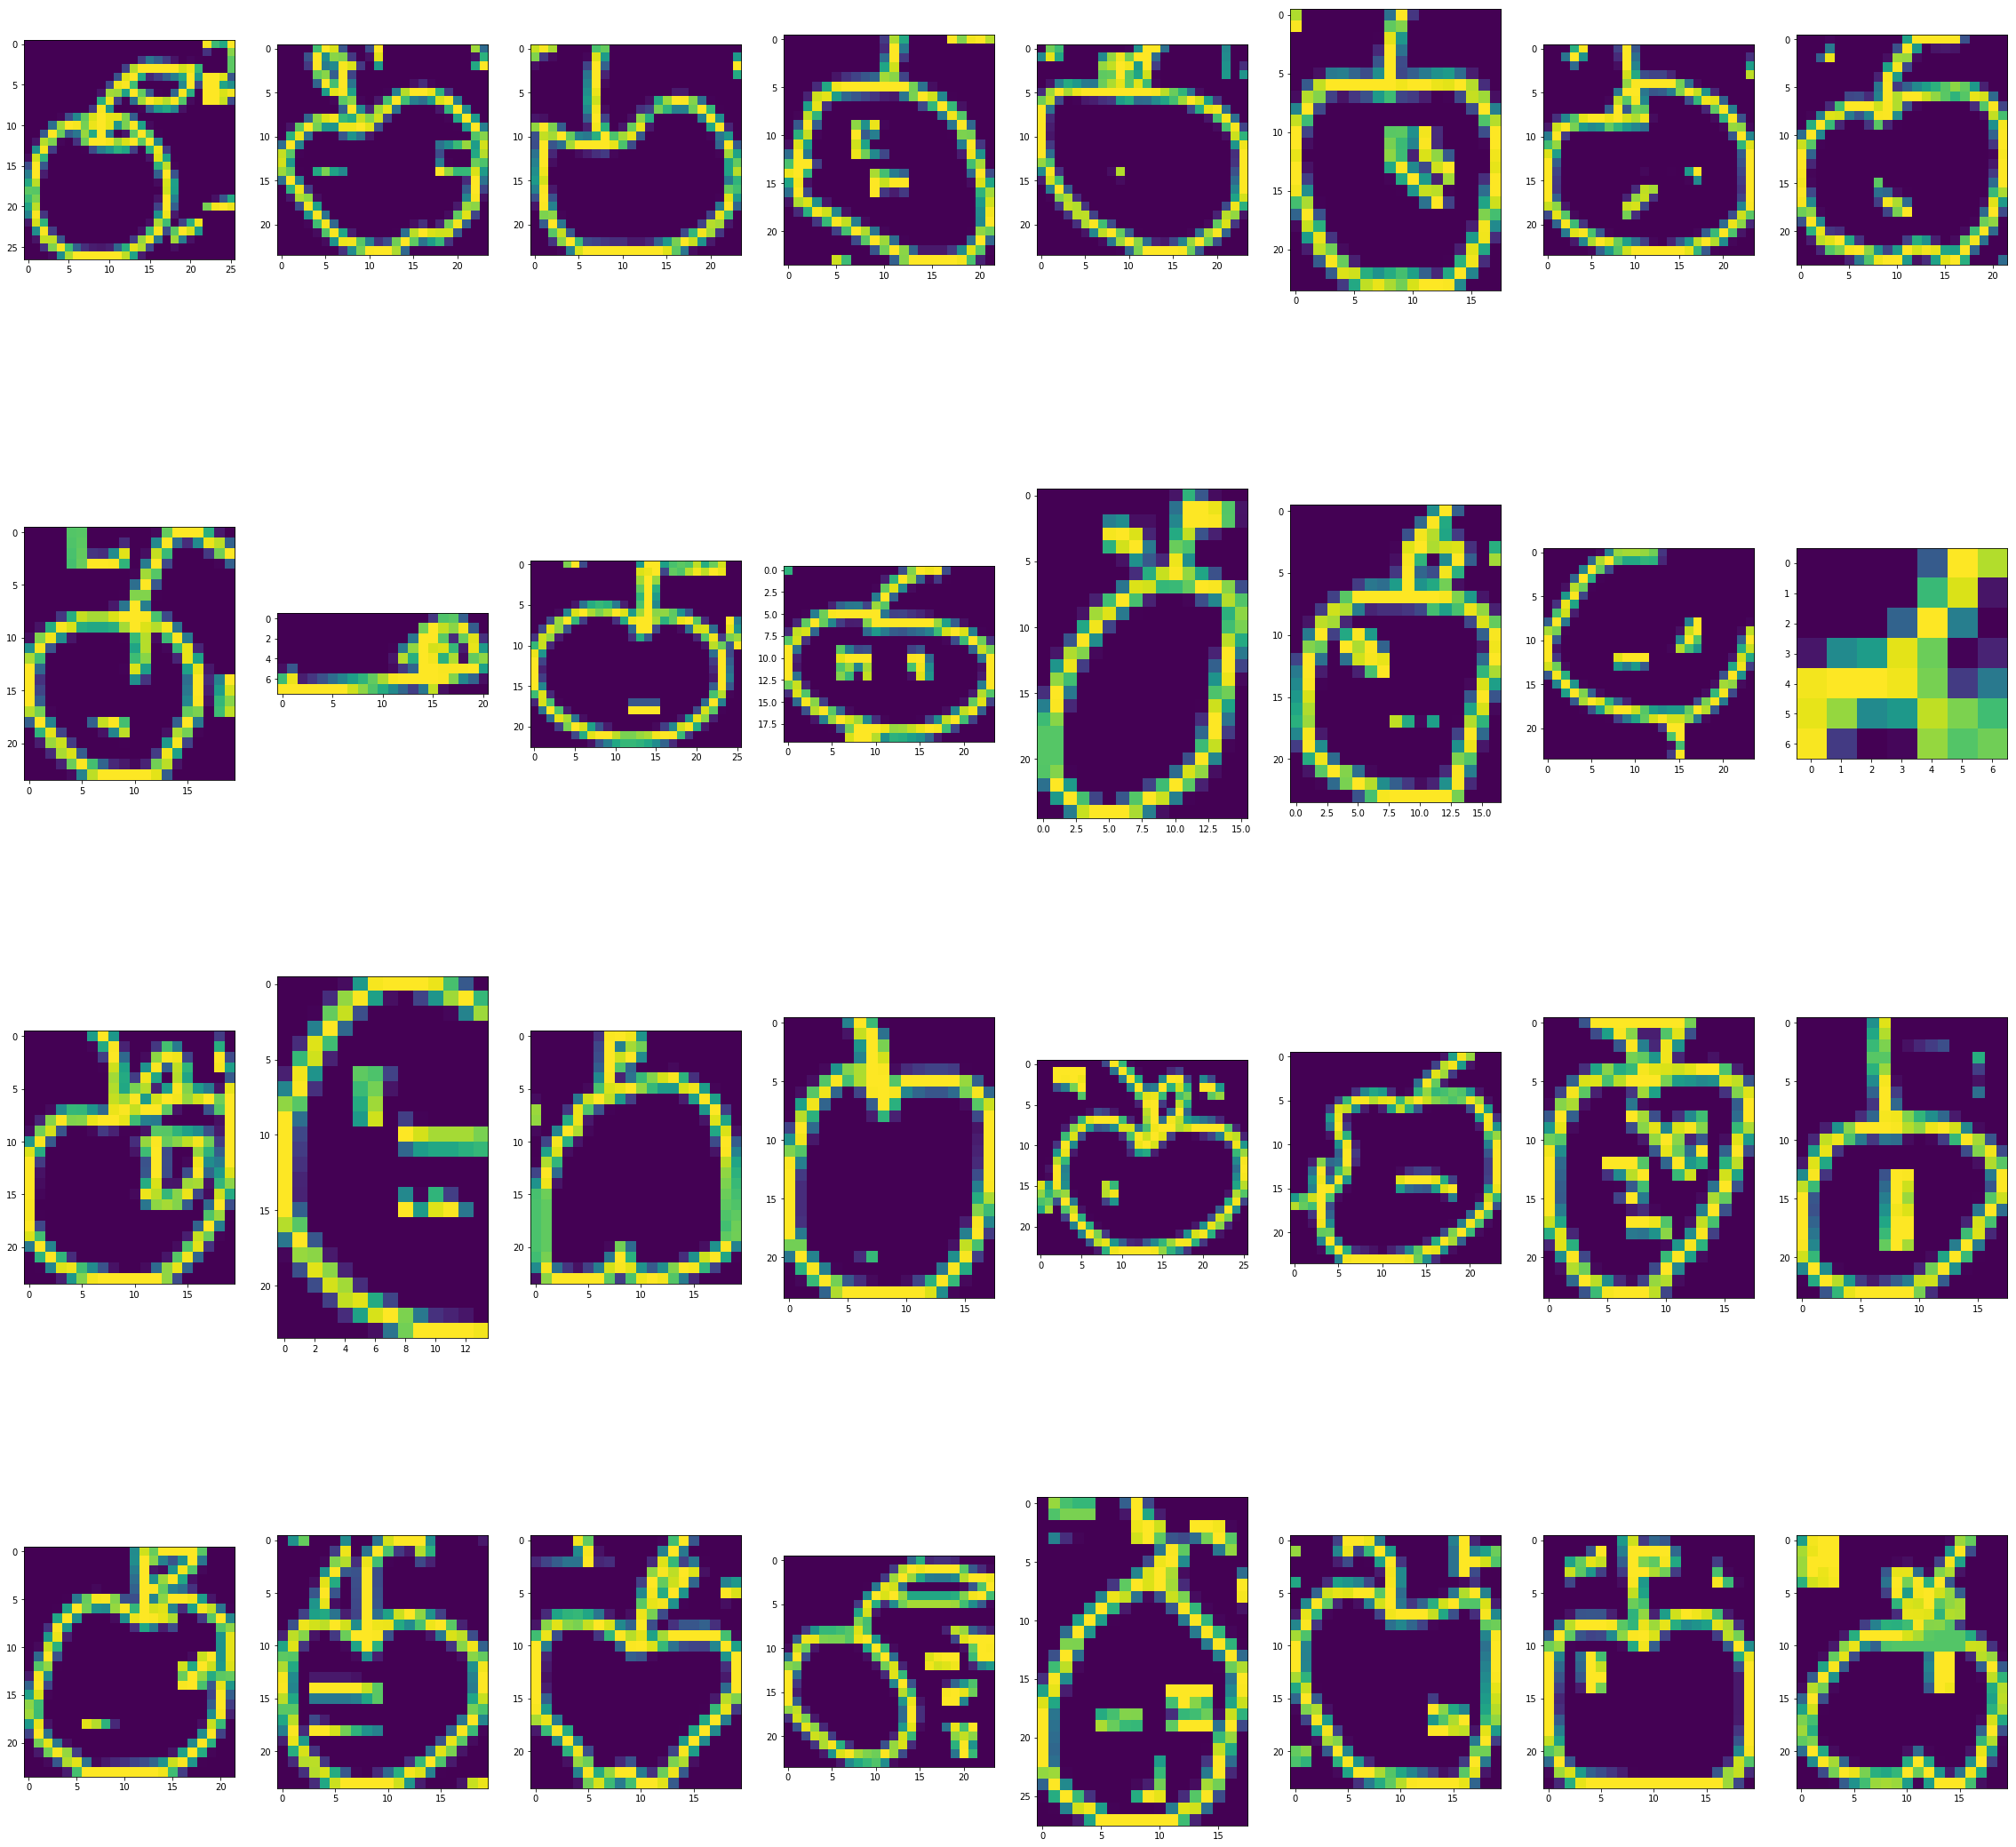

rollerskates


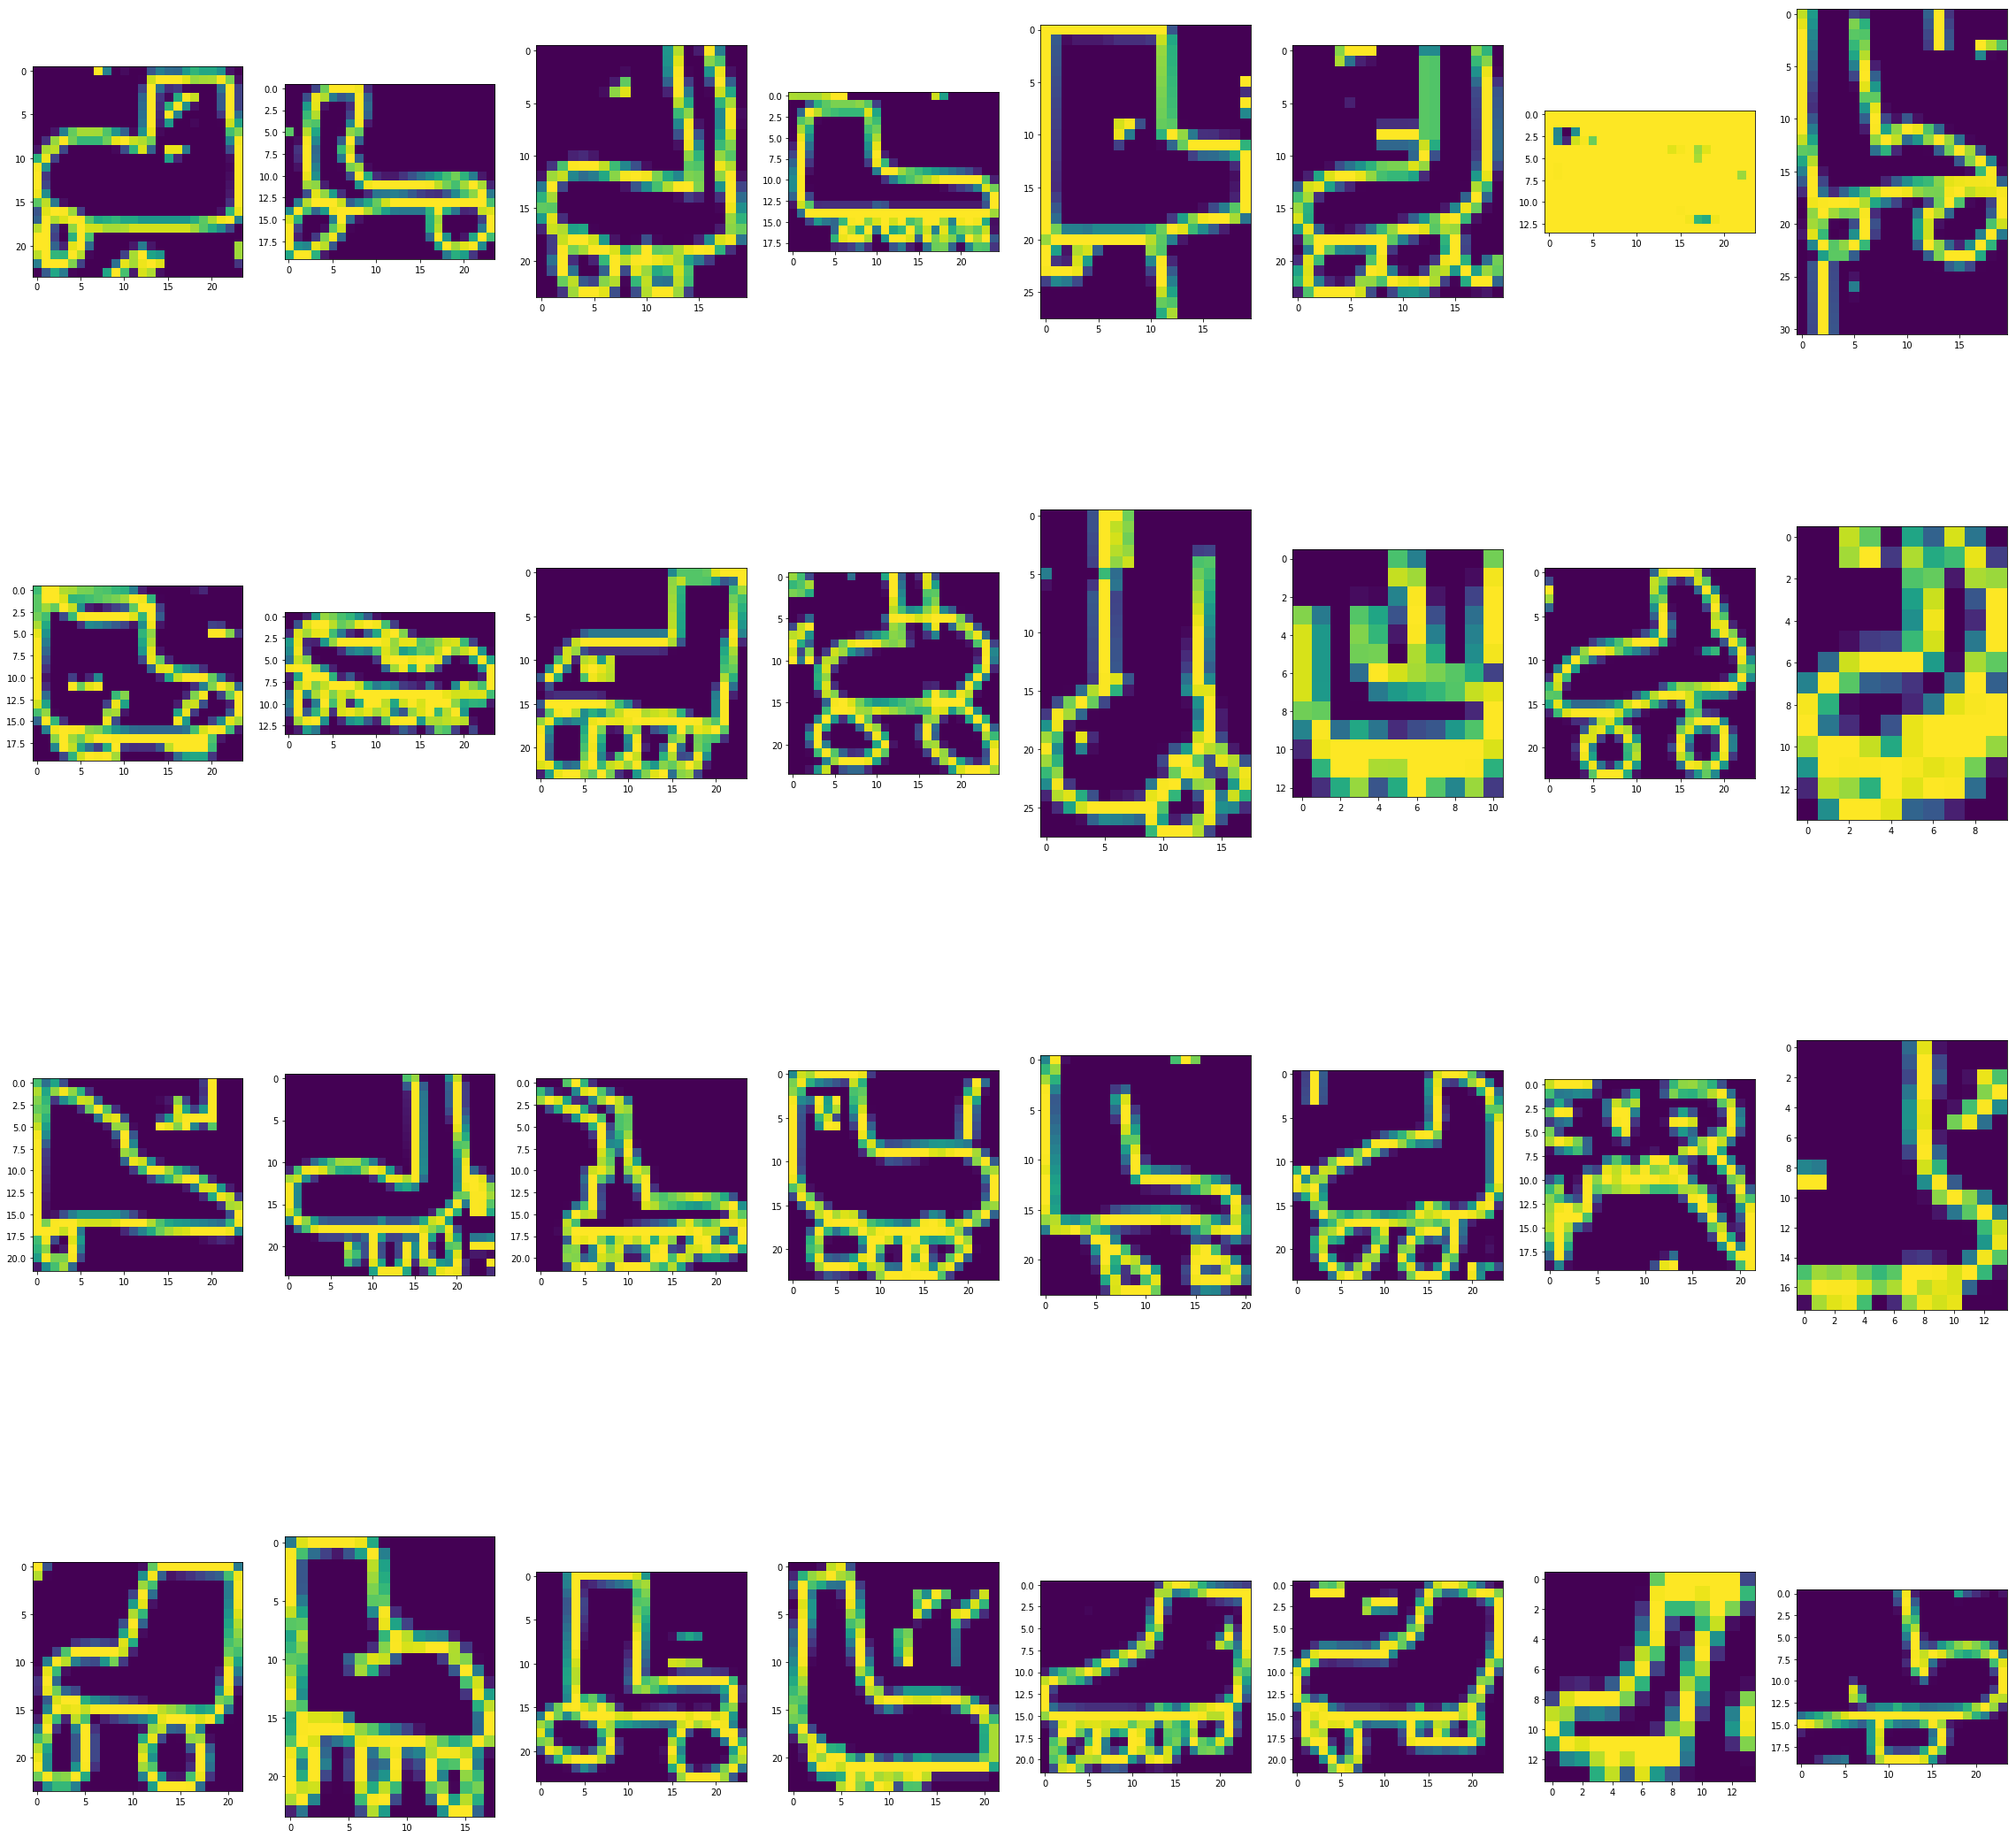

moustache


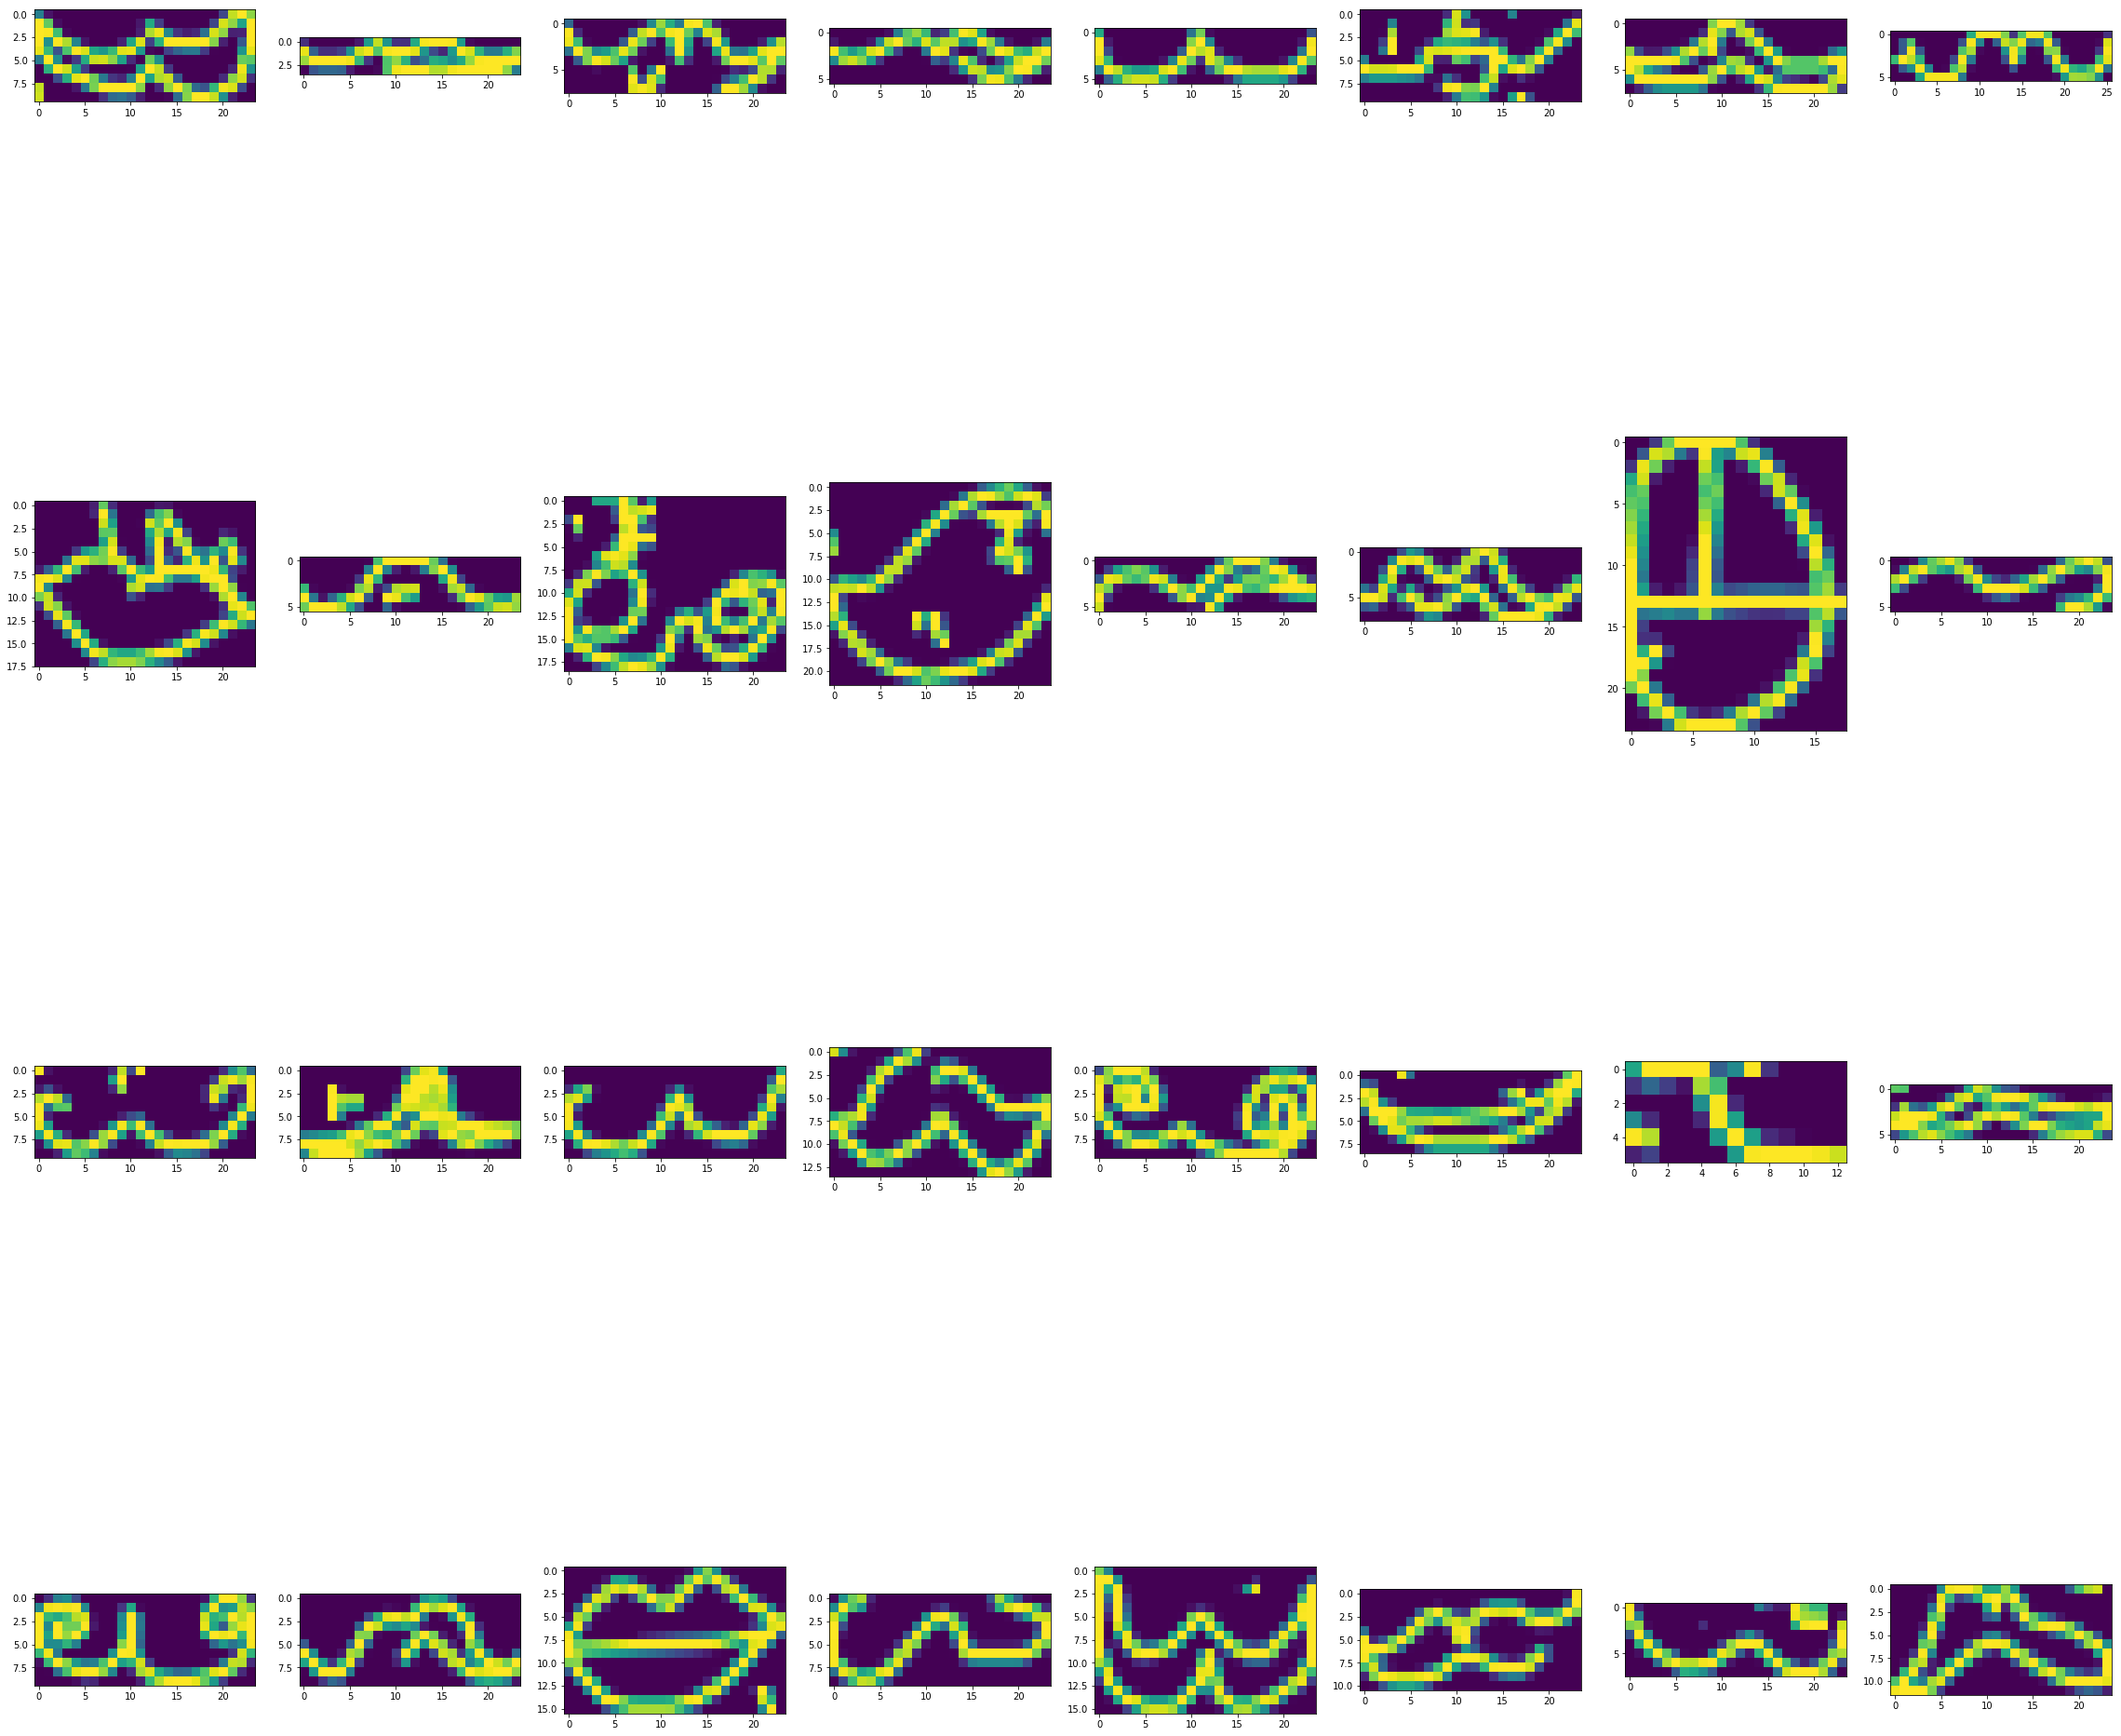

rabbit


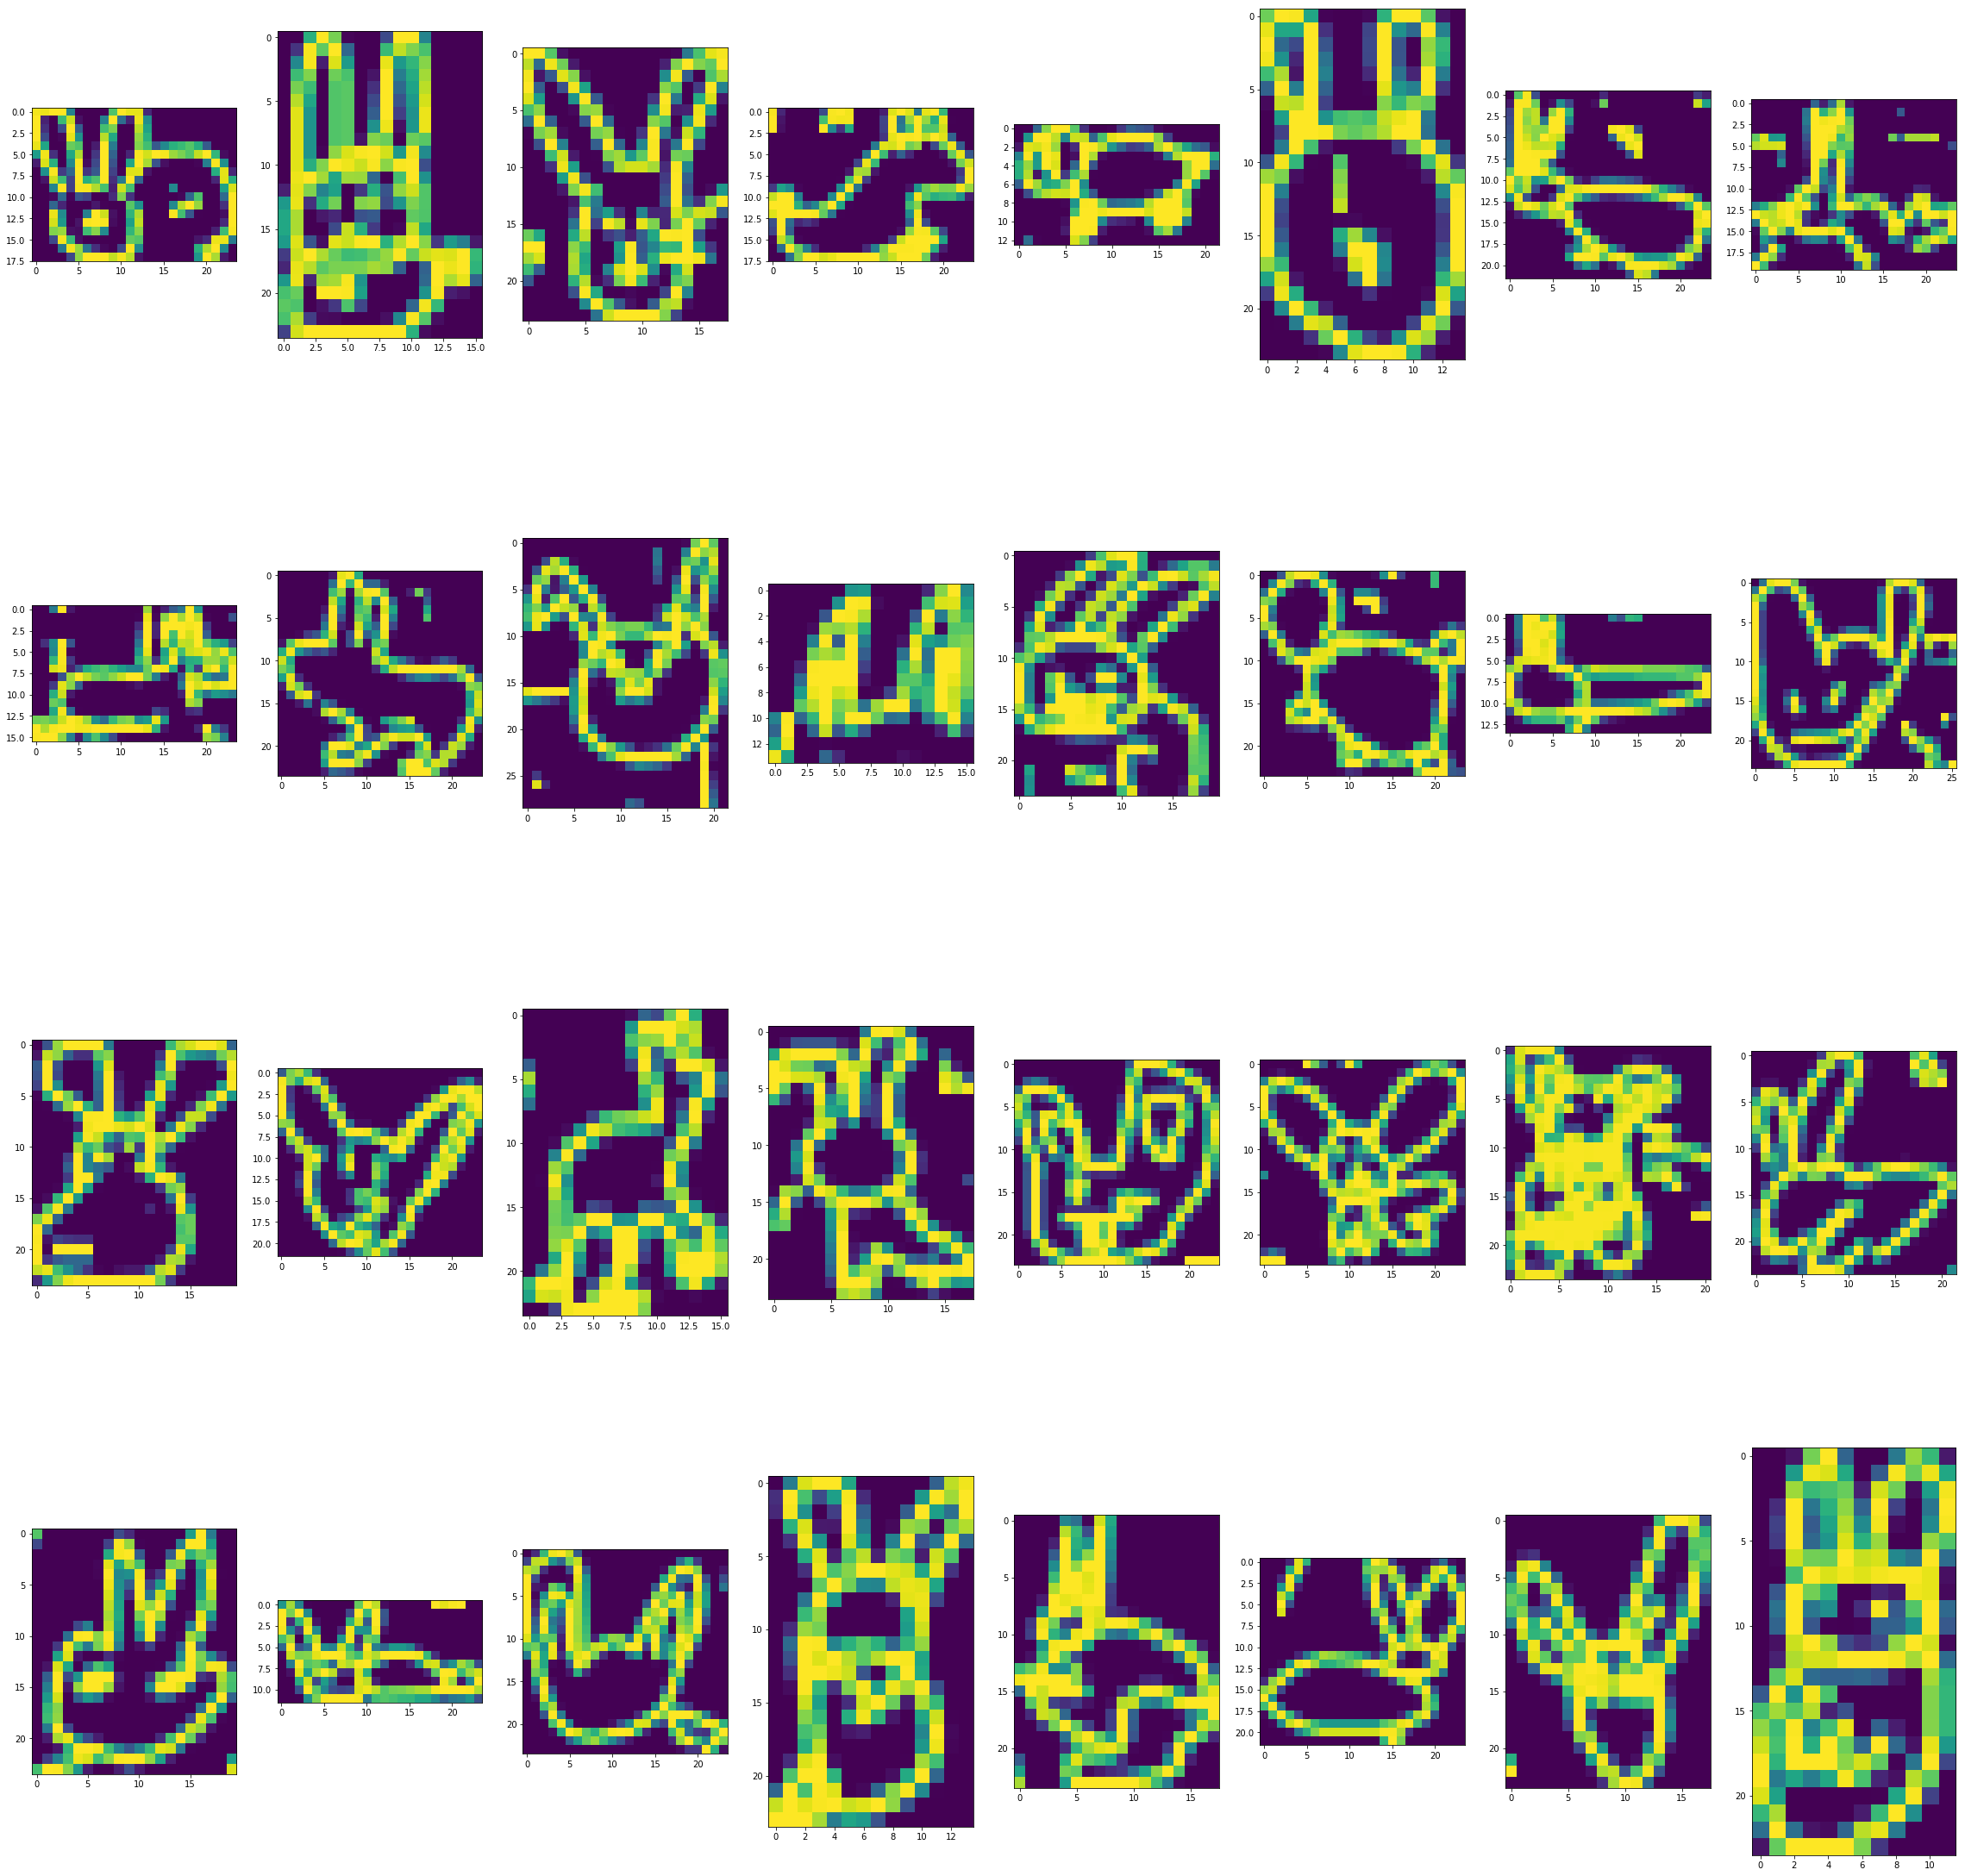

skull


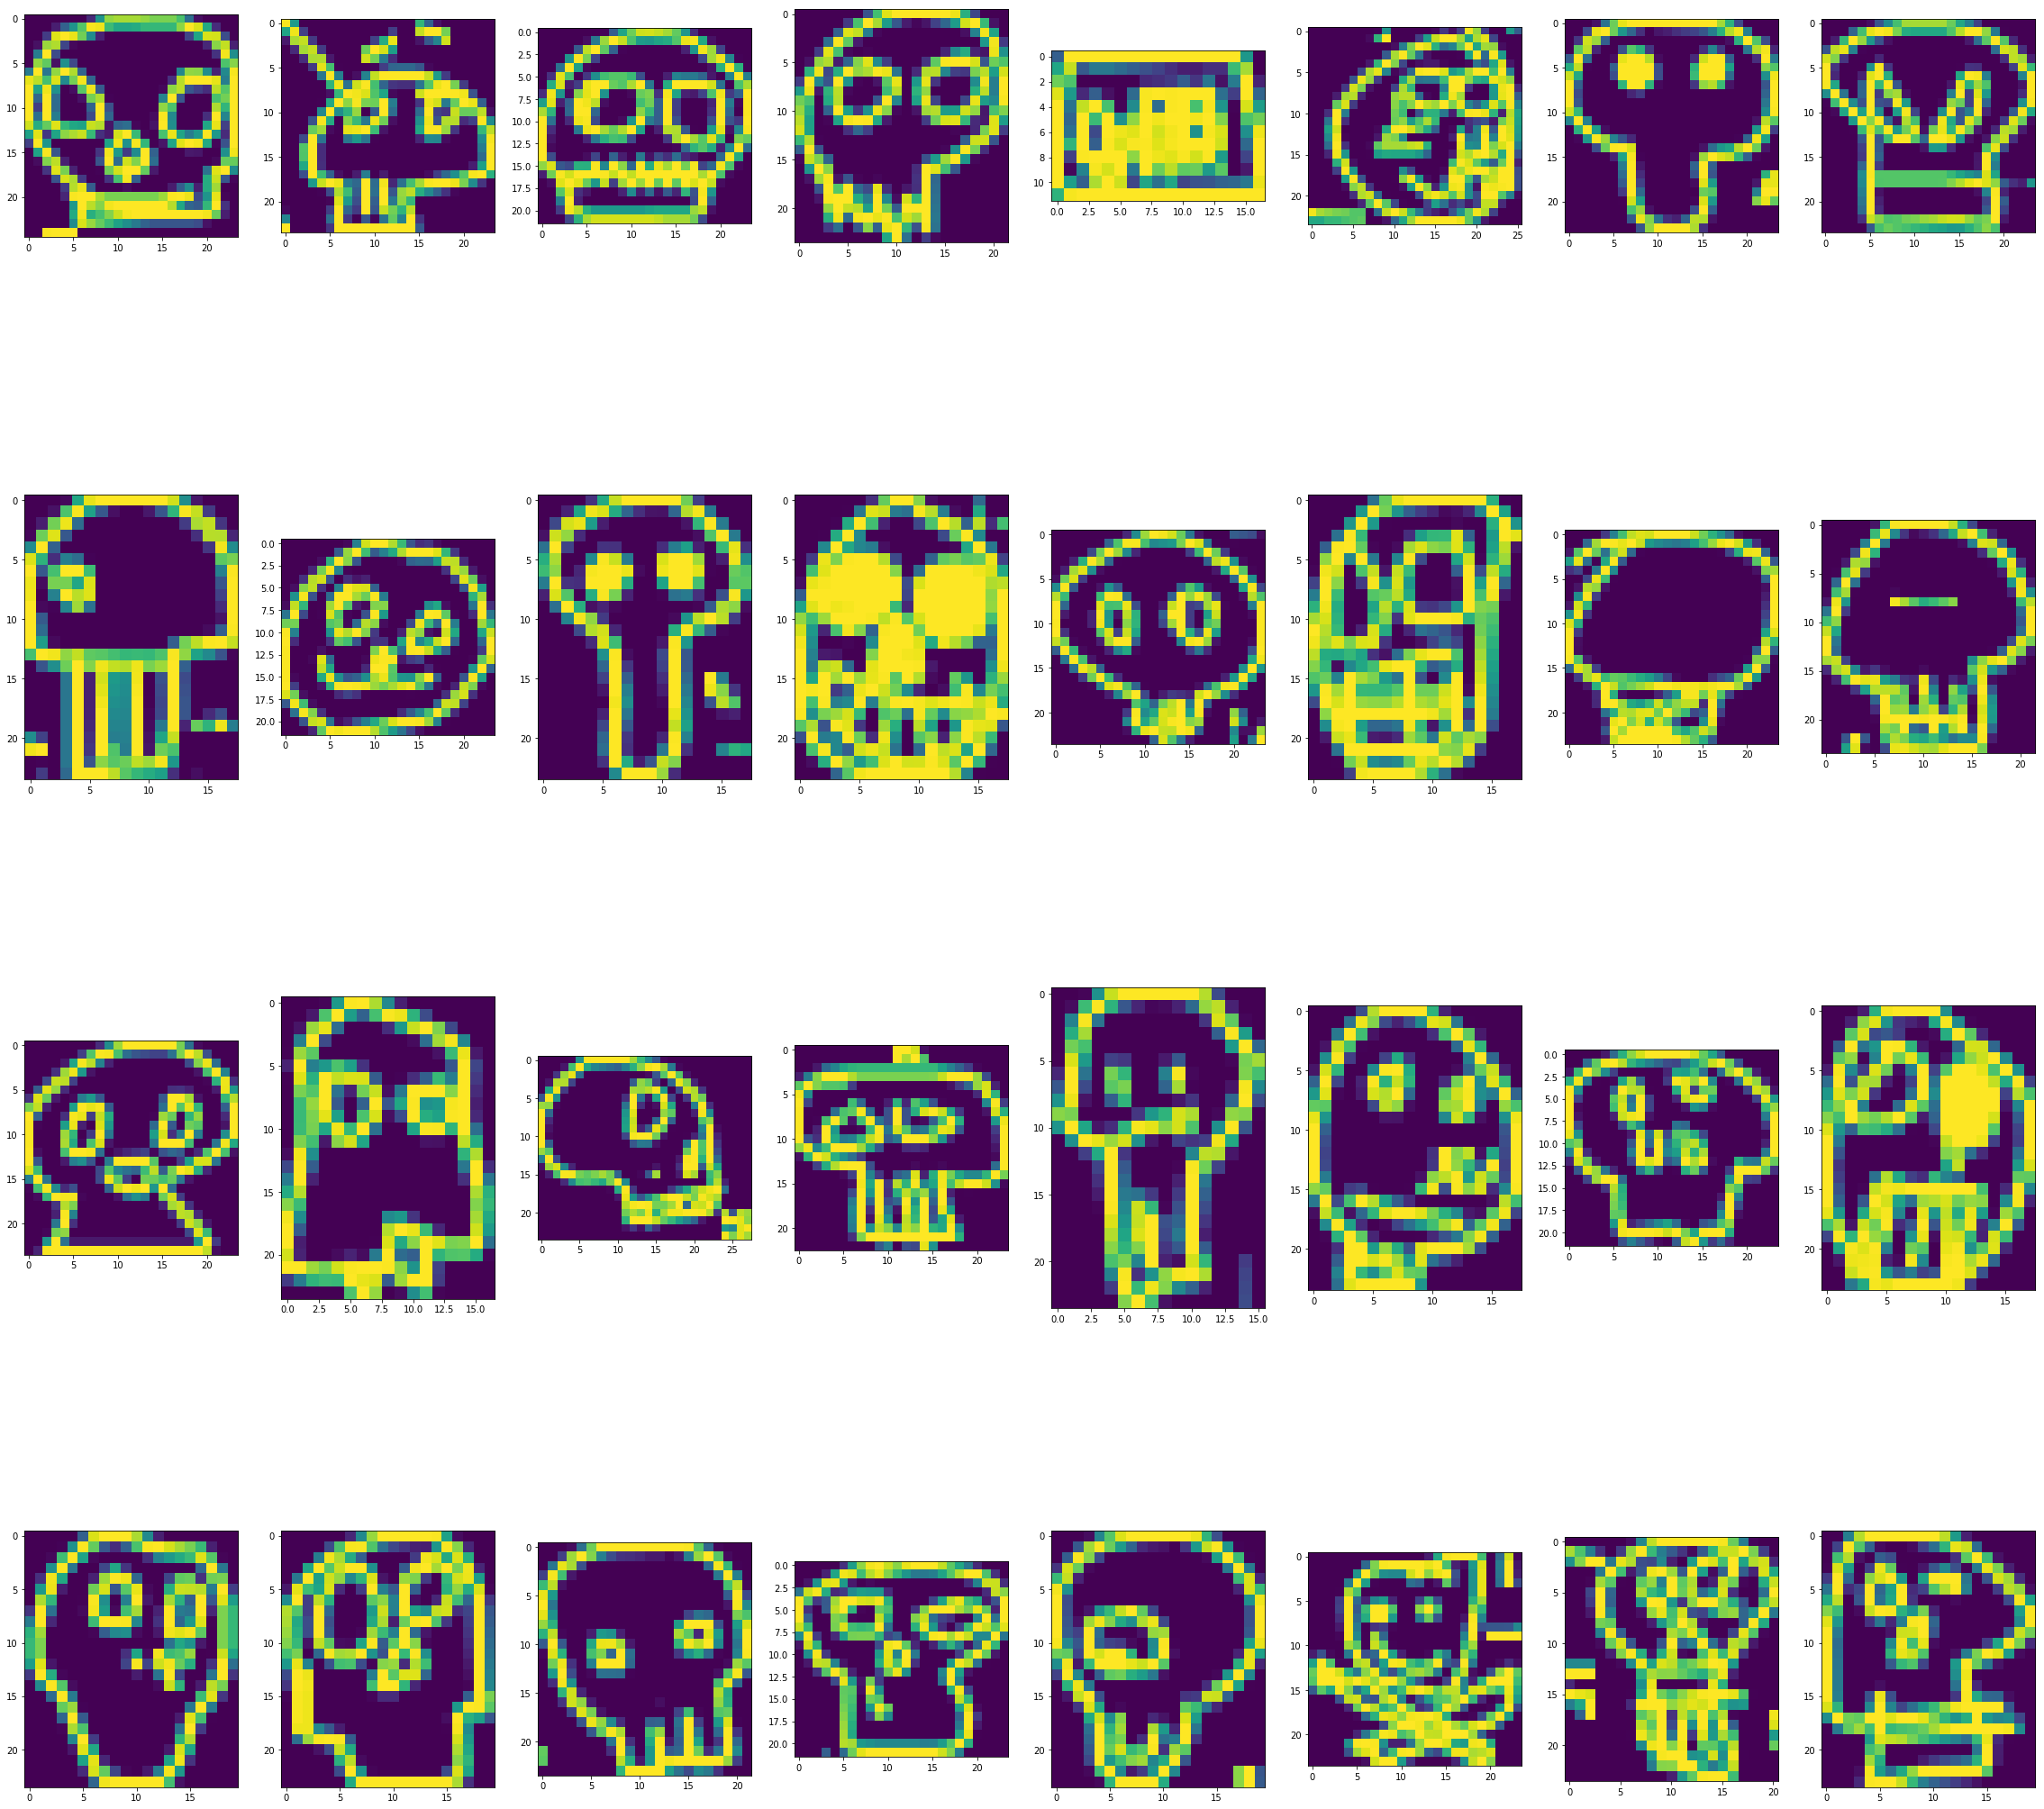

skateboard


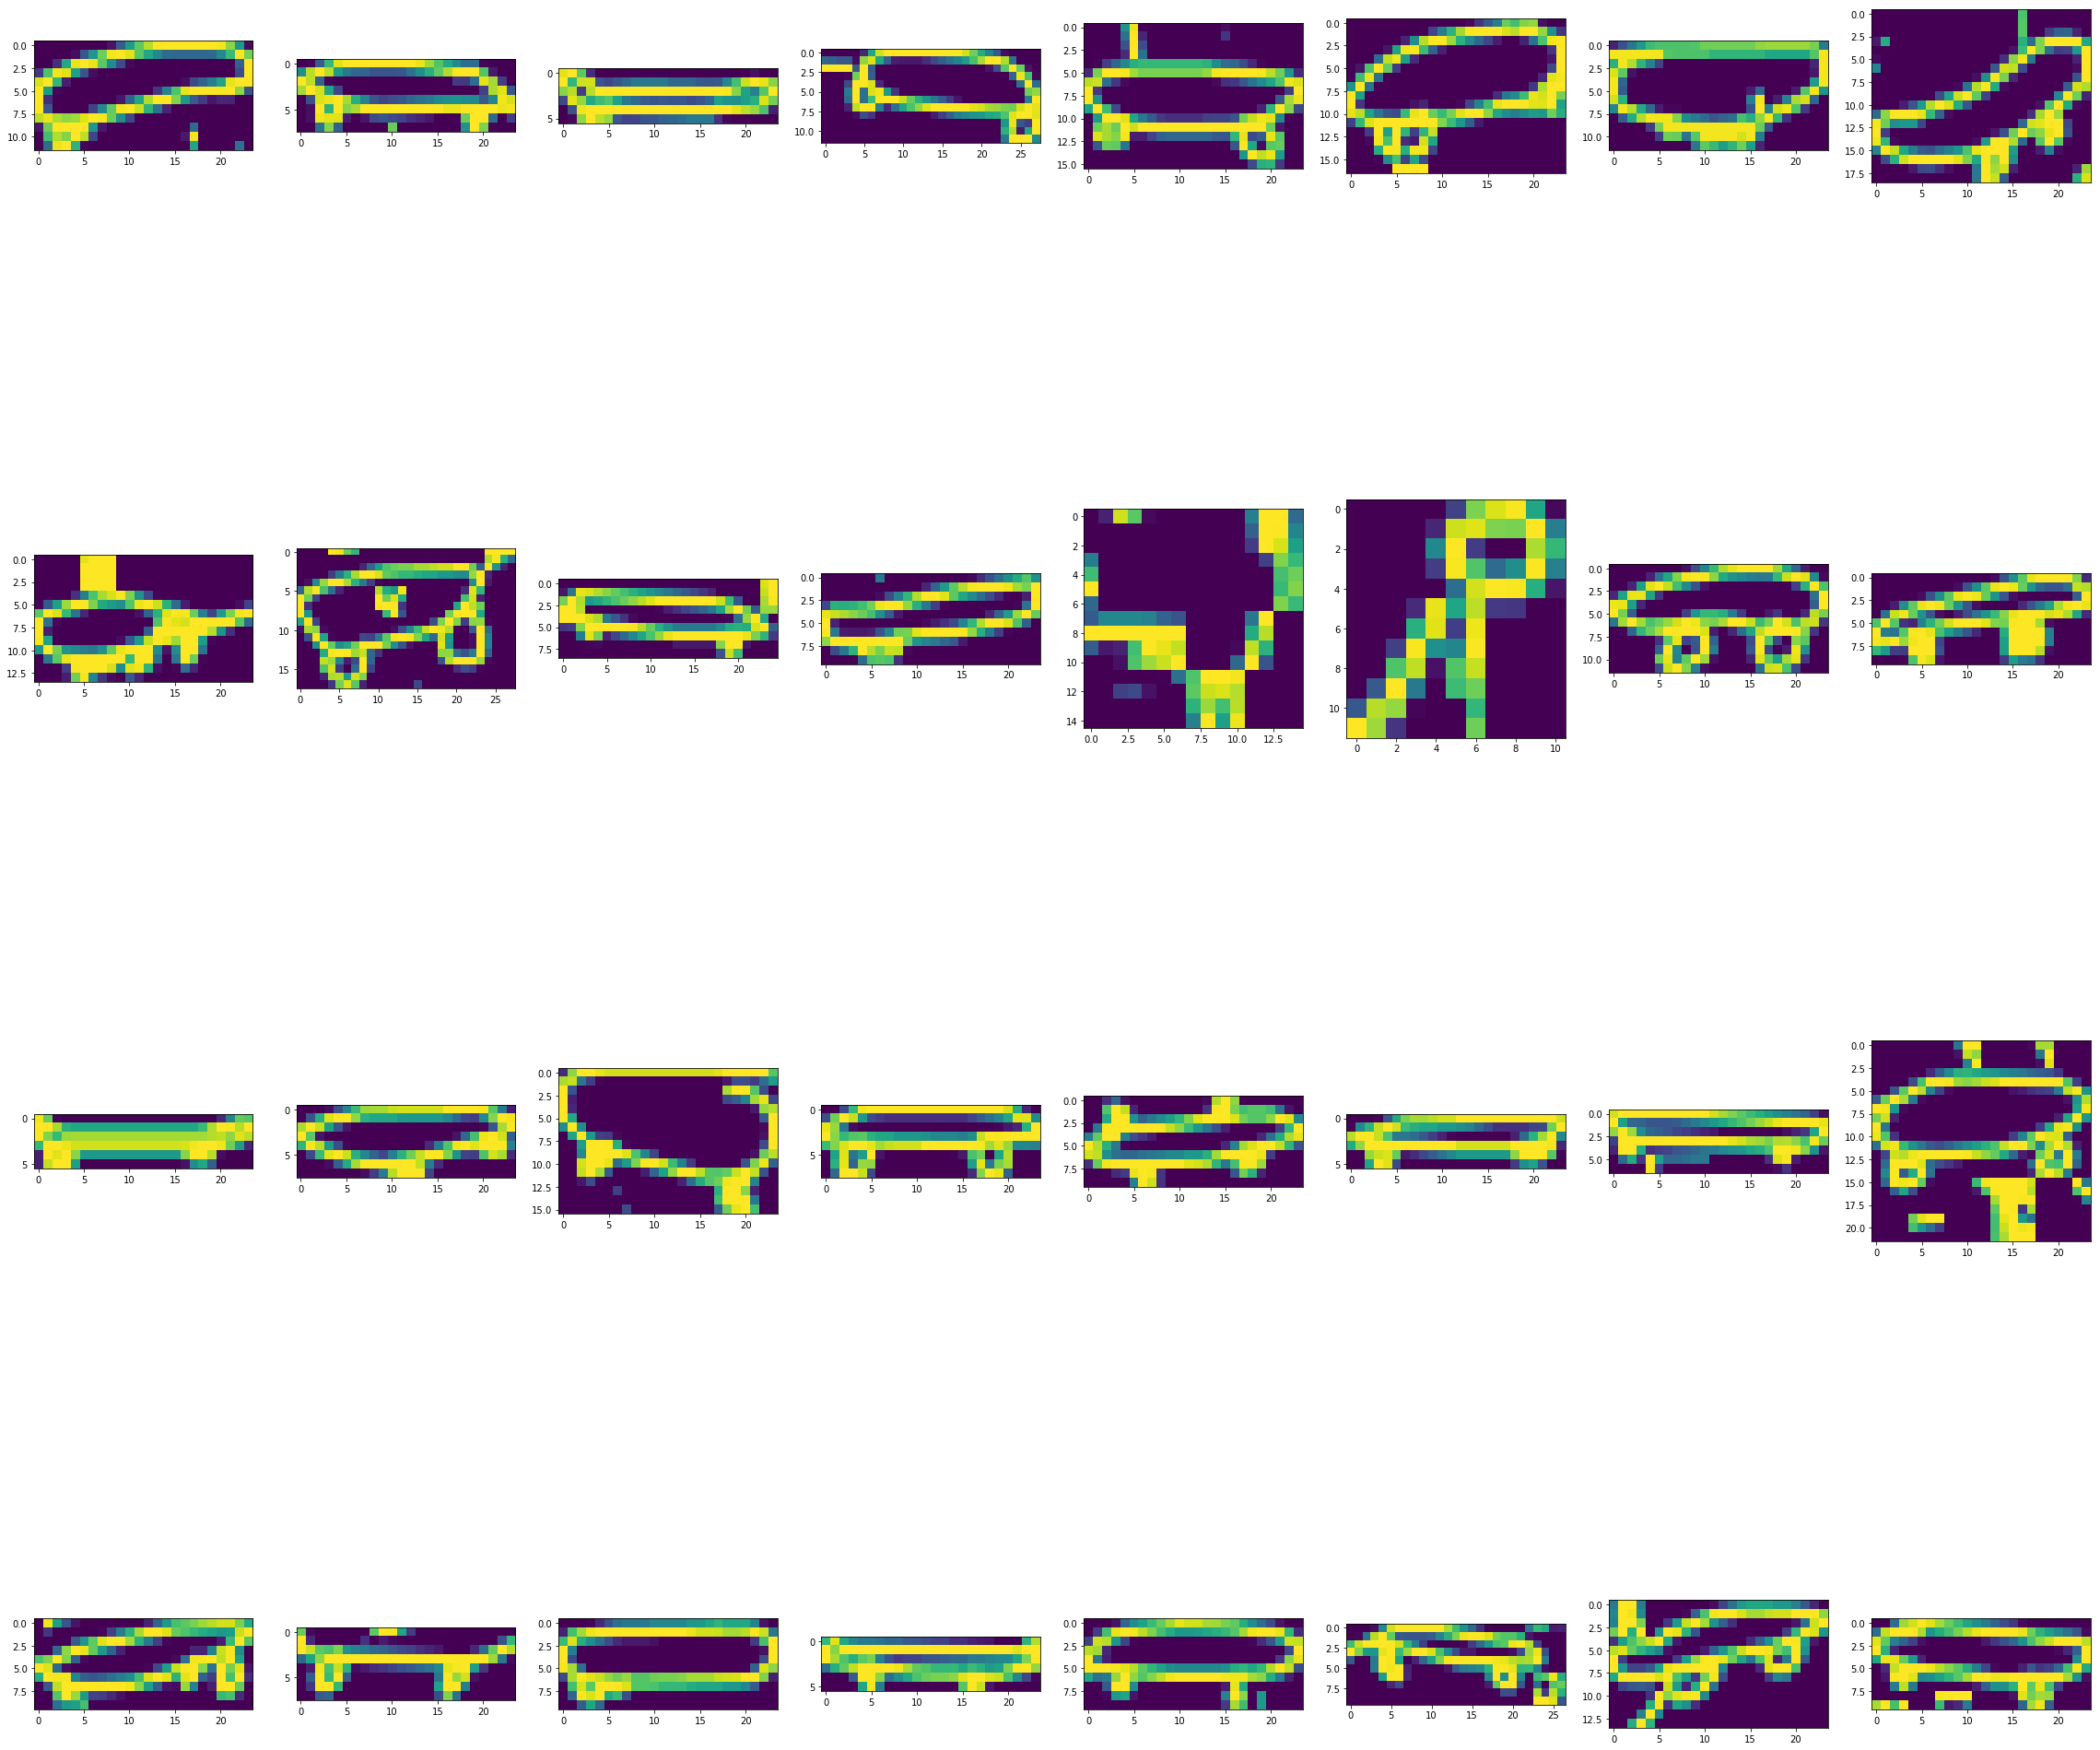

scorpion


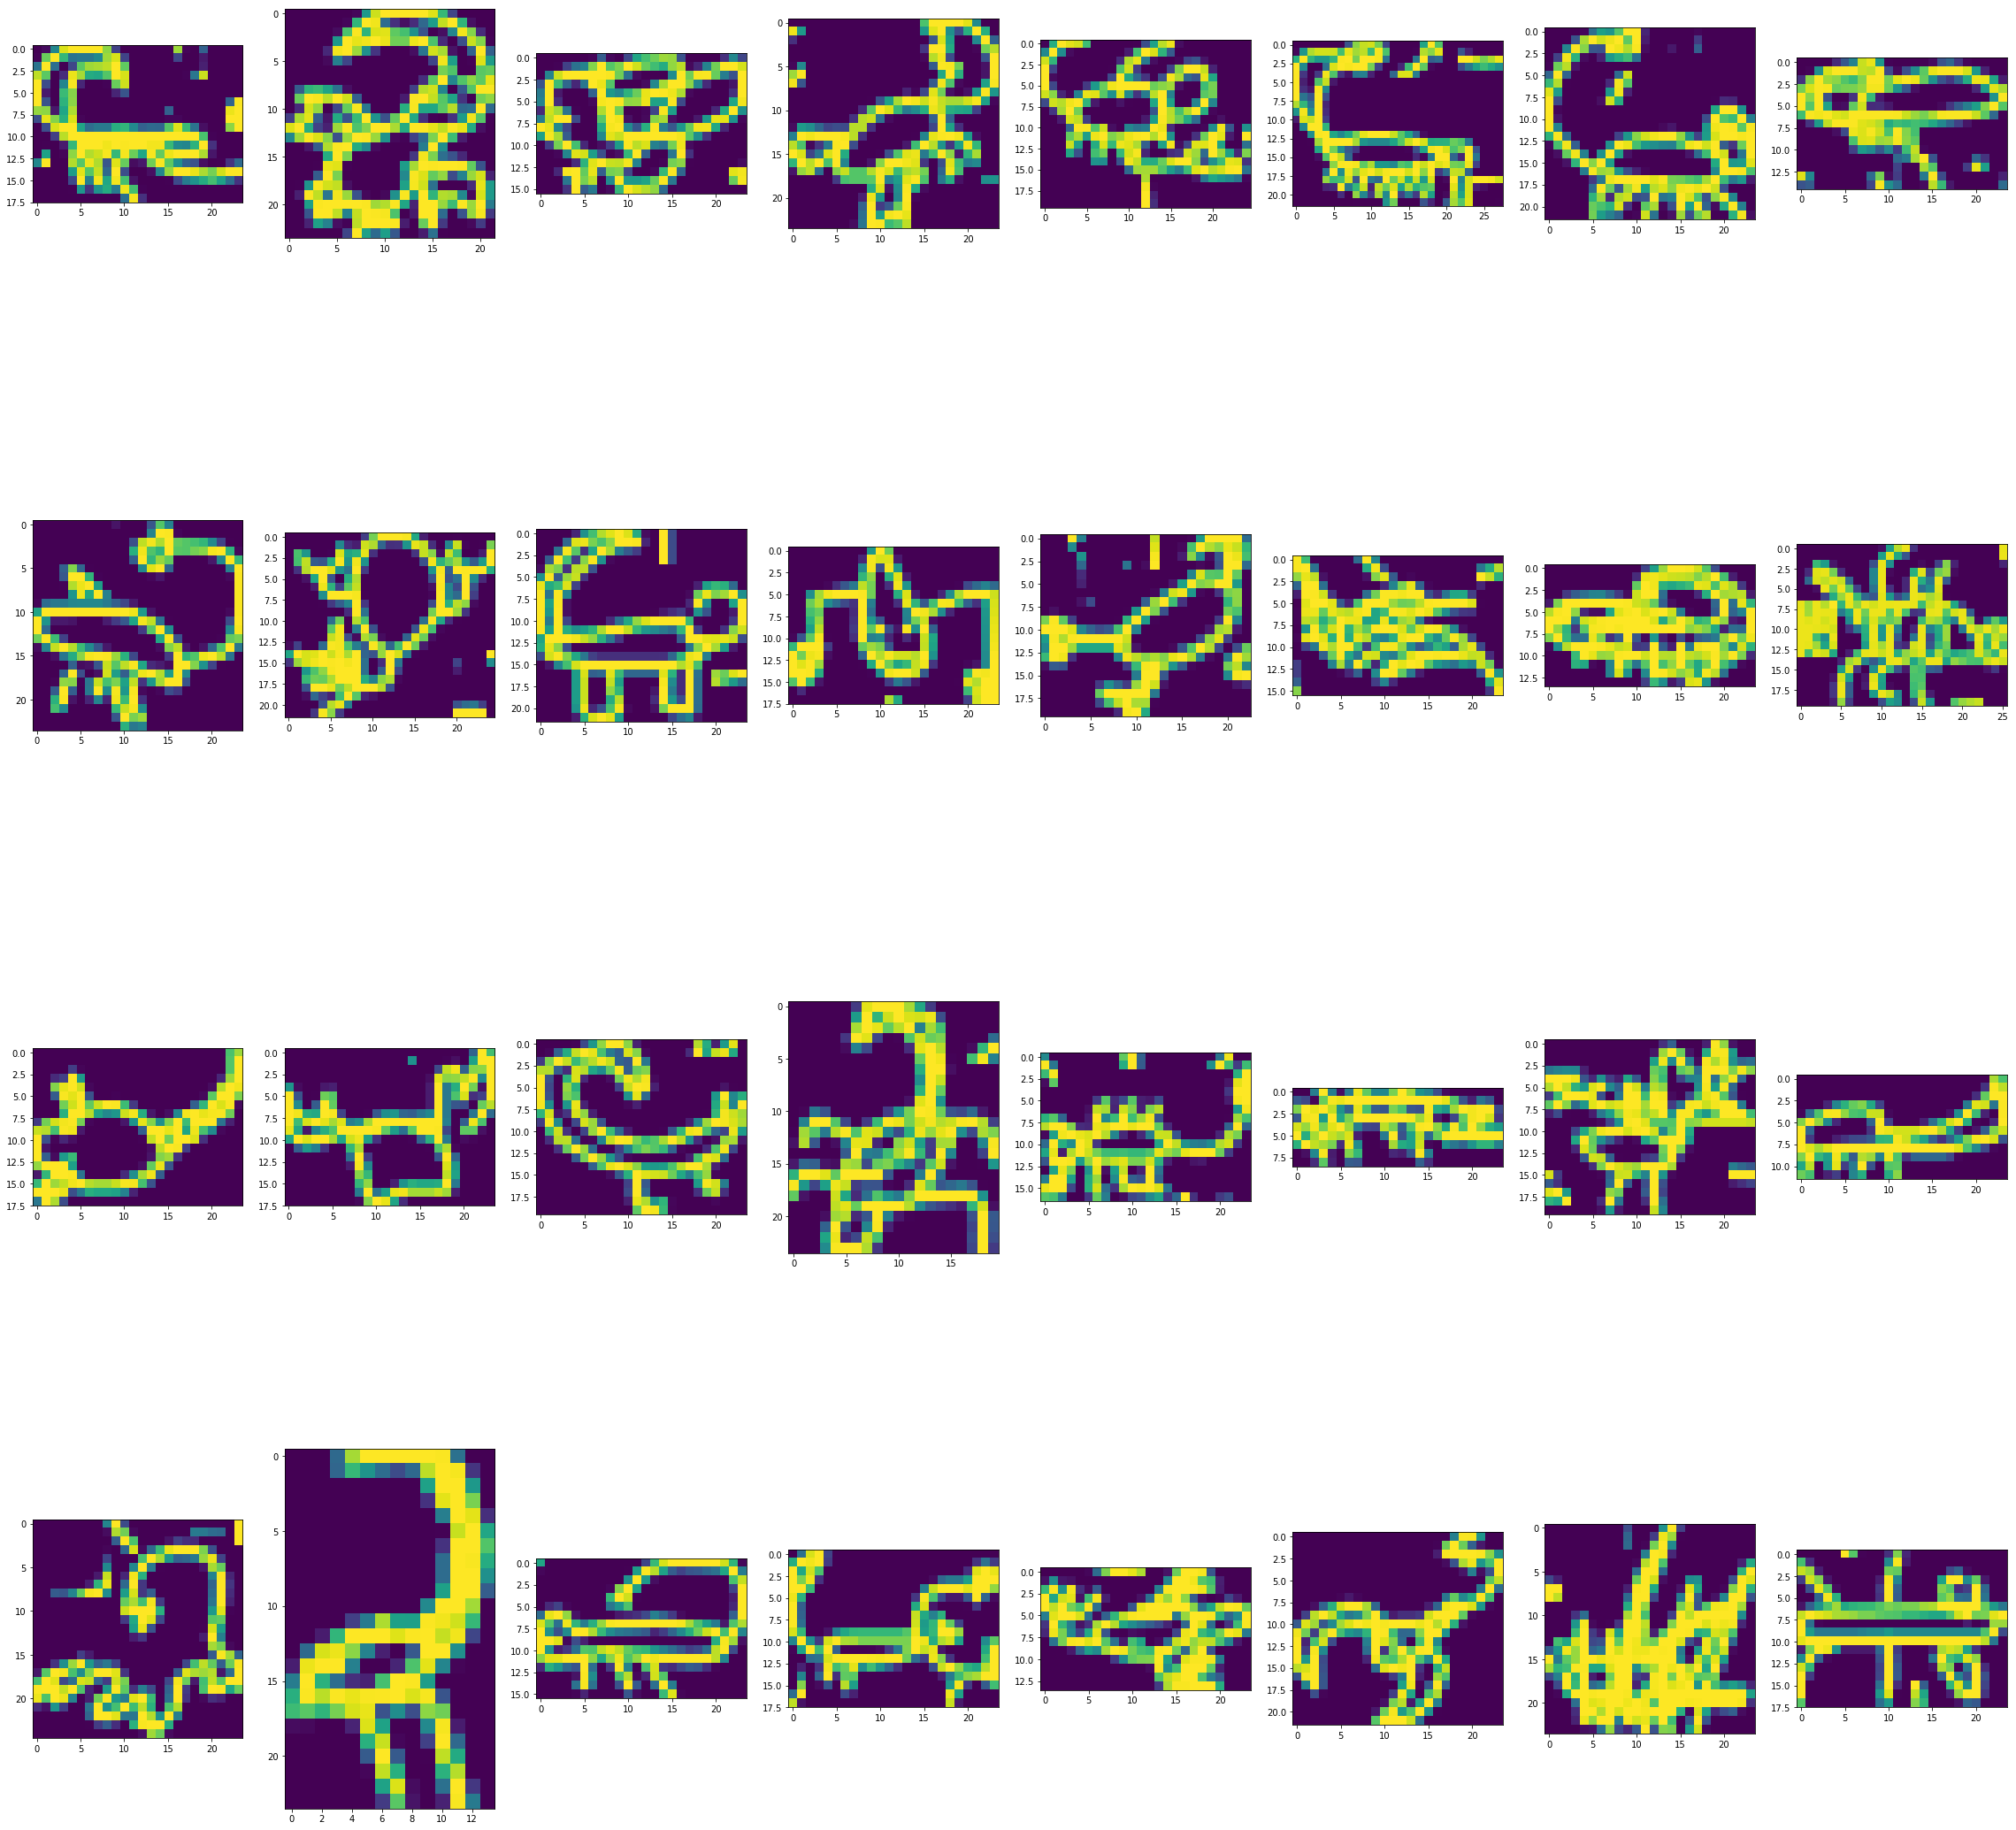

spoon


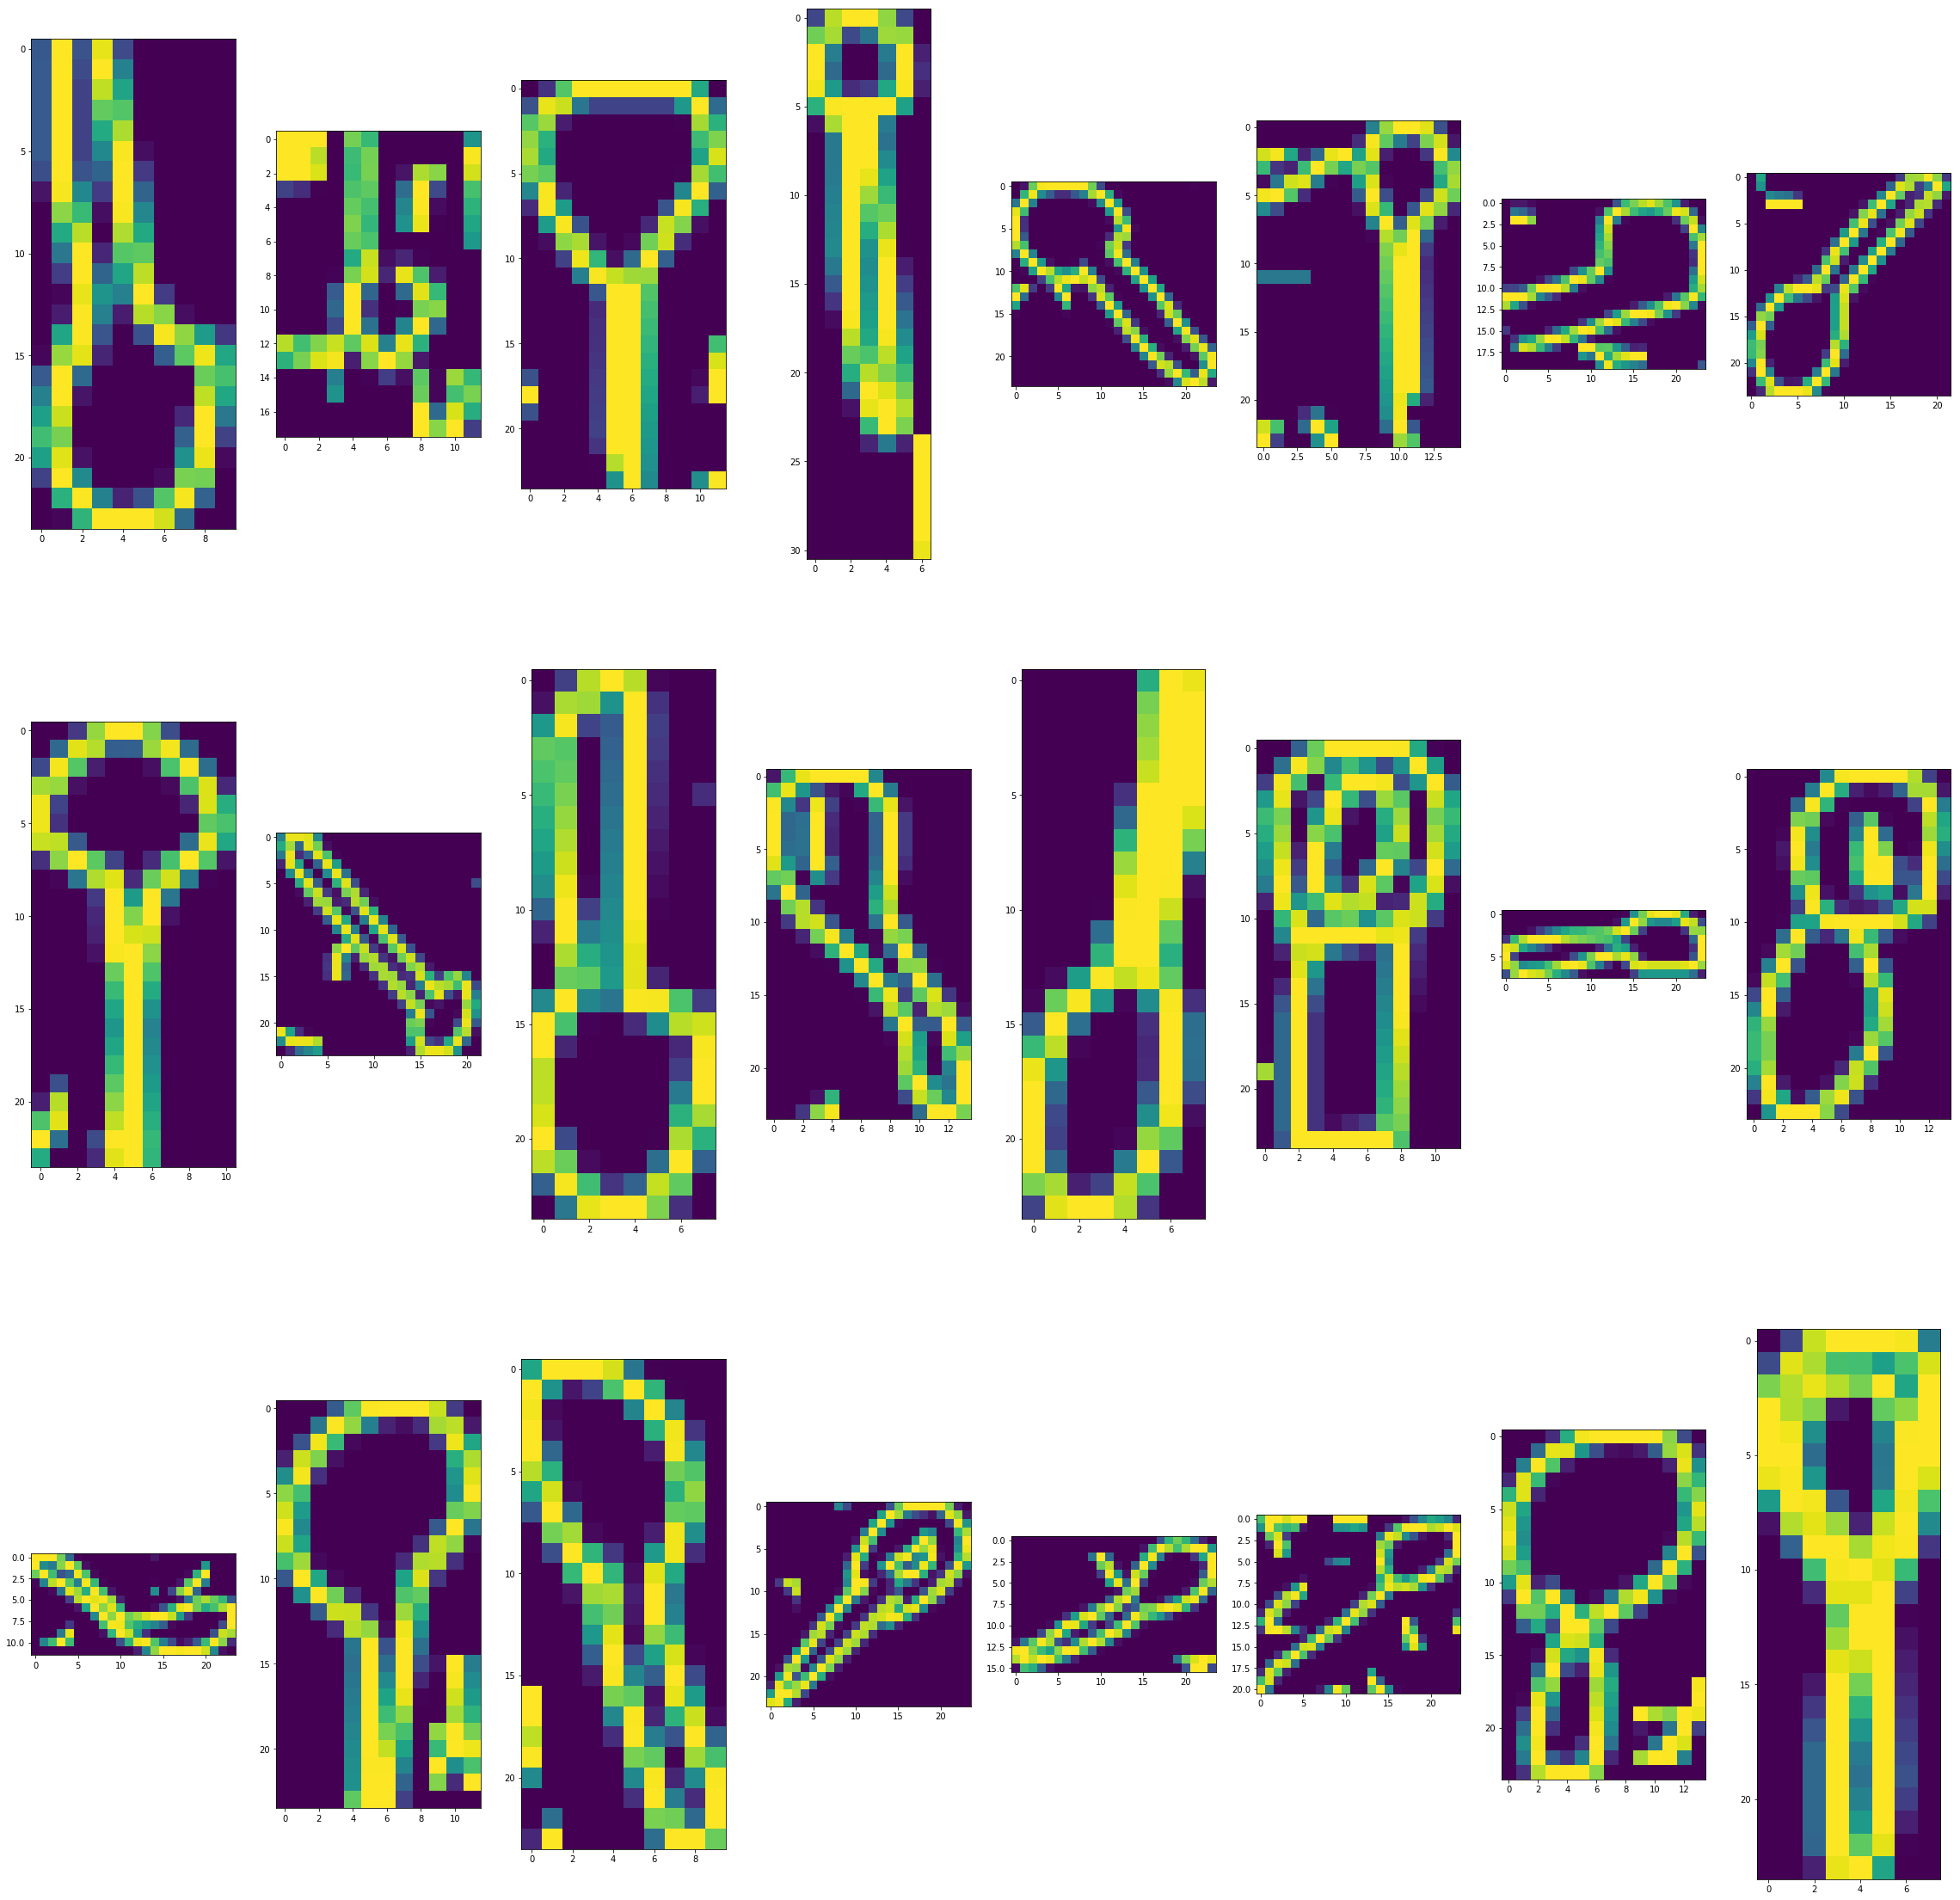

mug


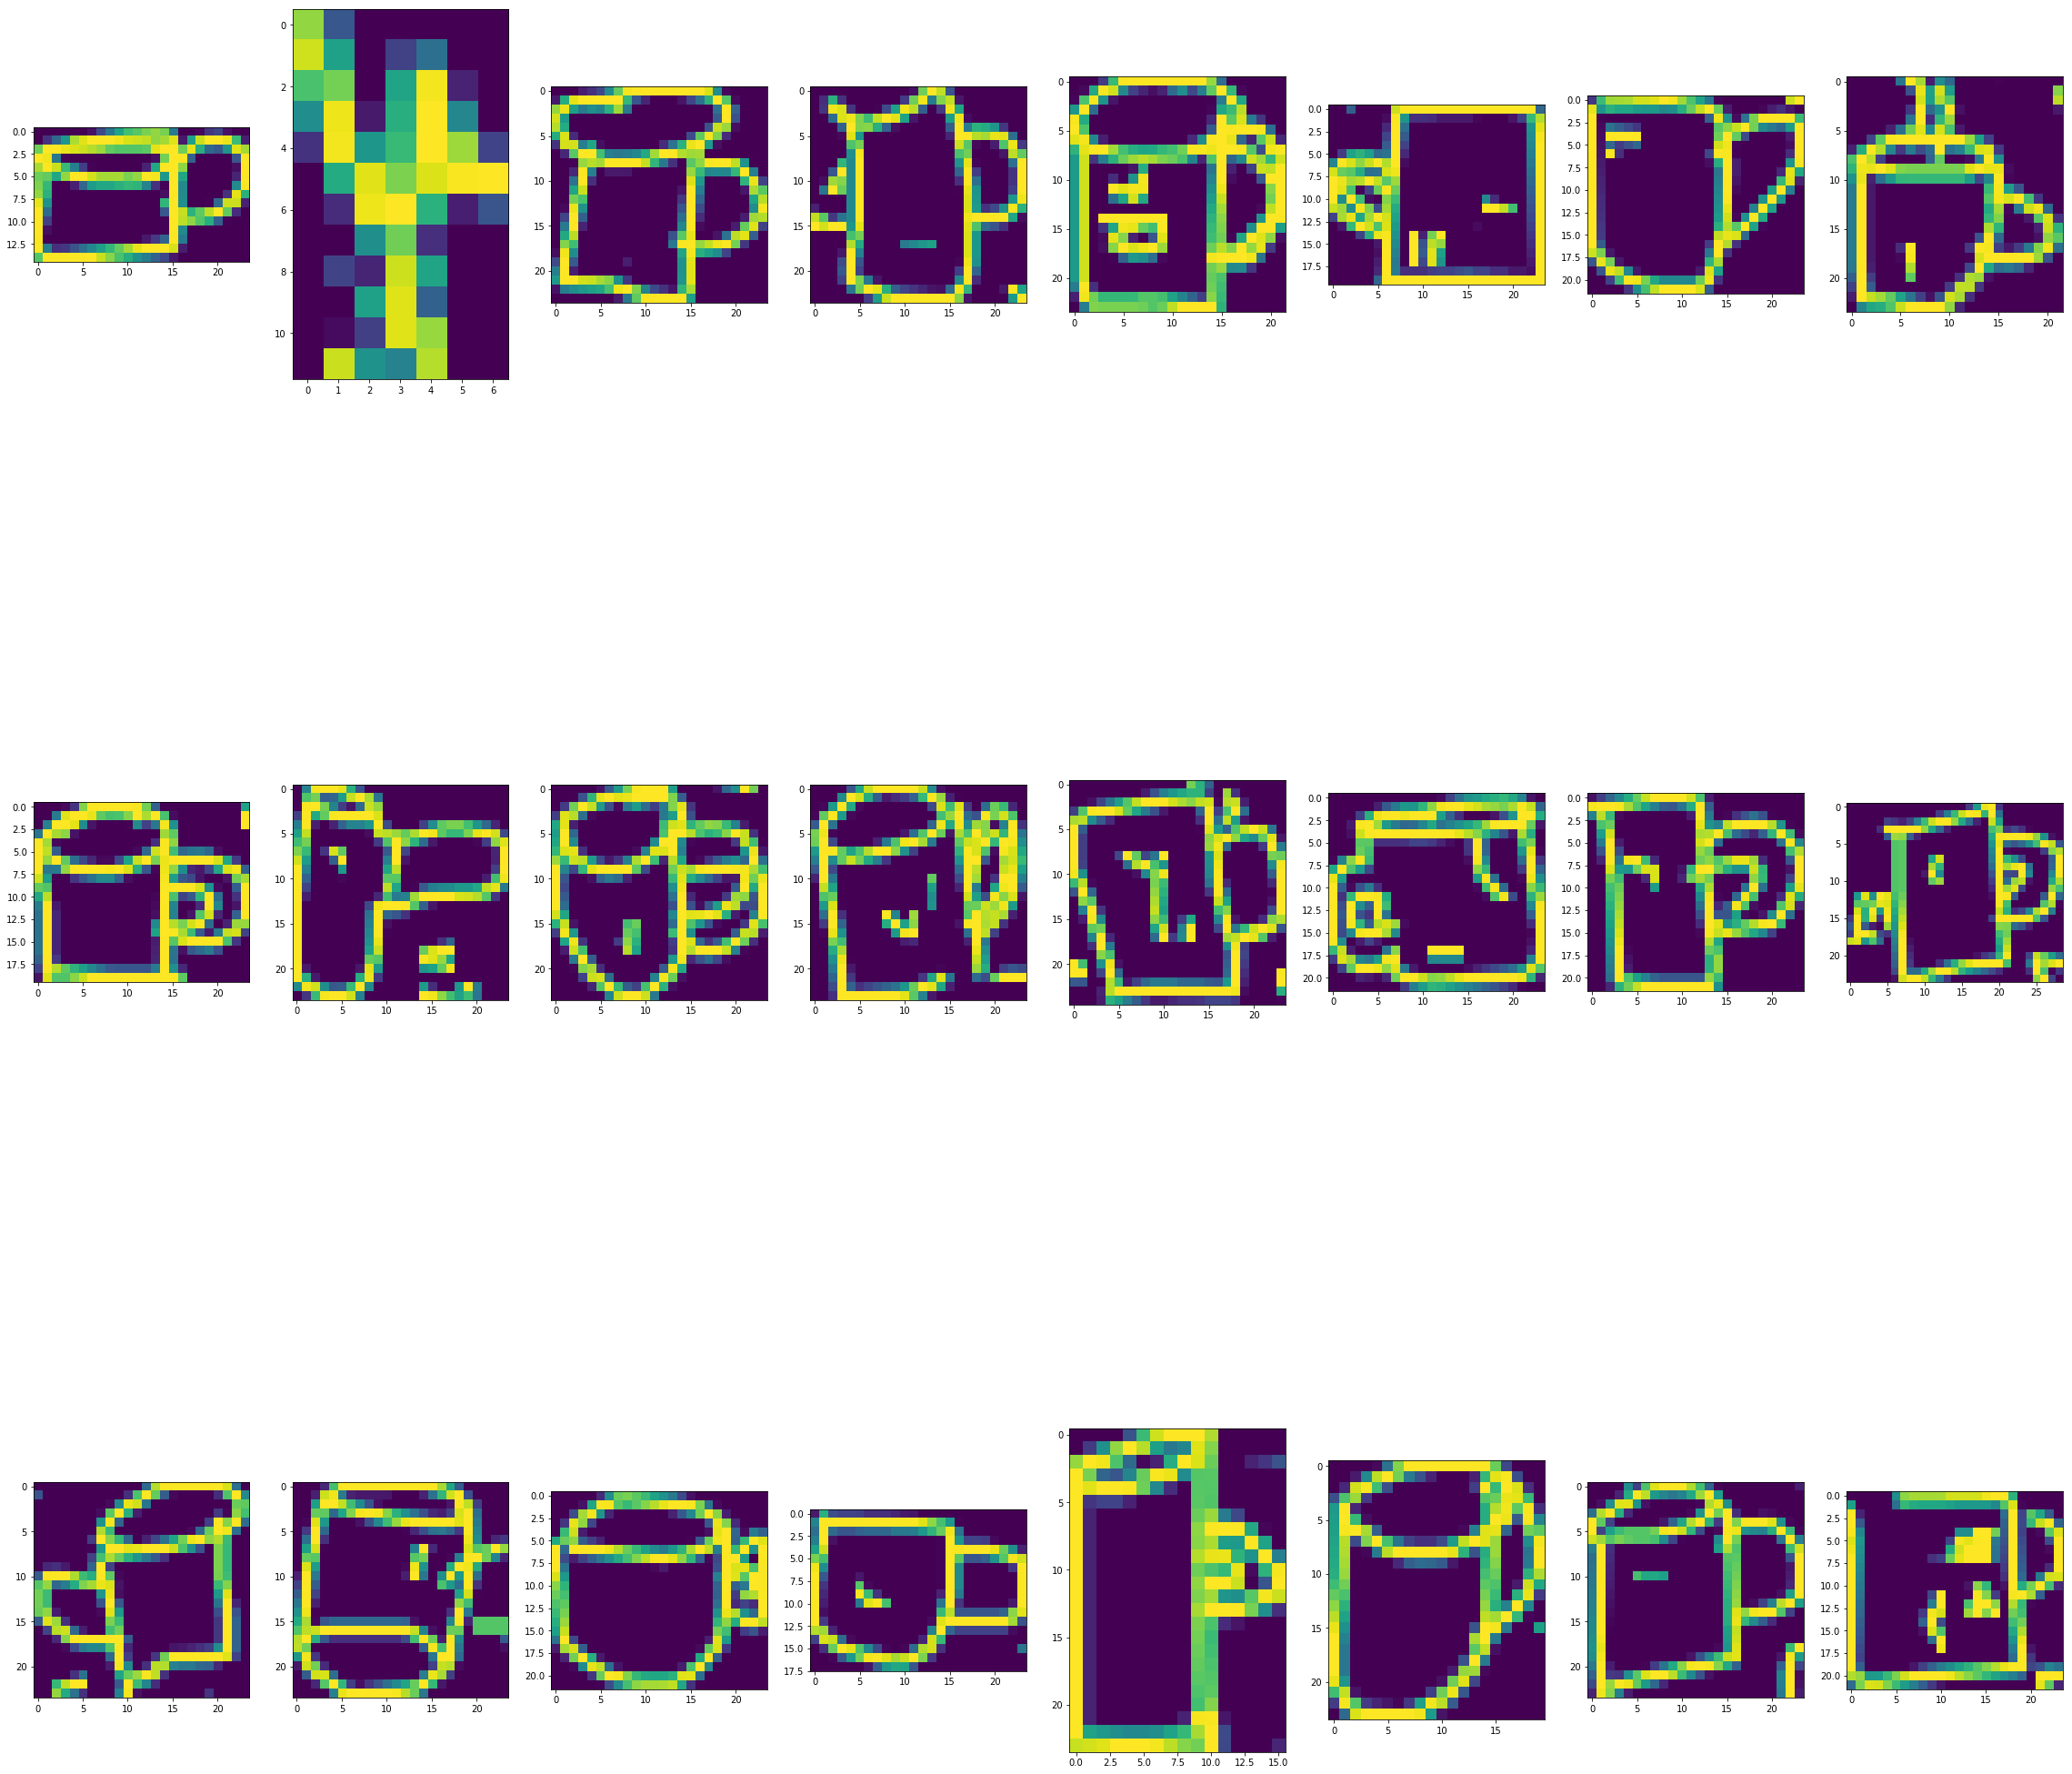

rhinoceros


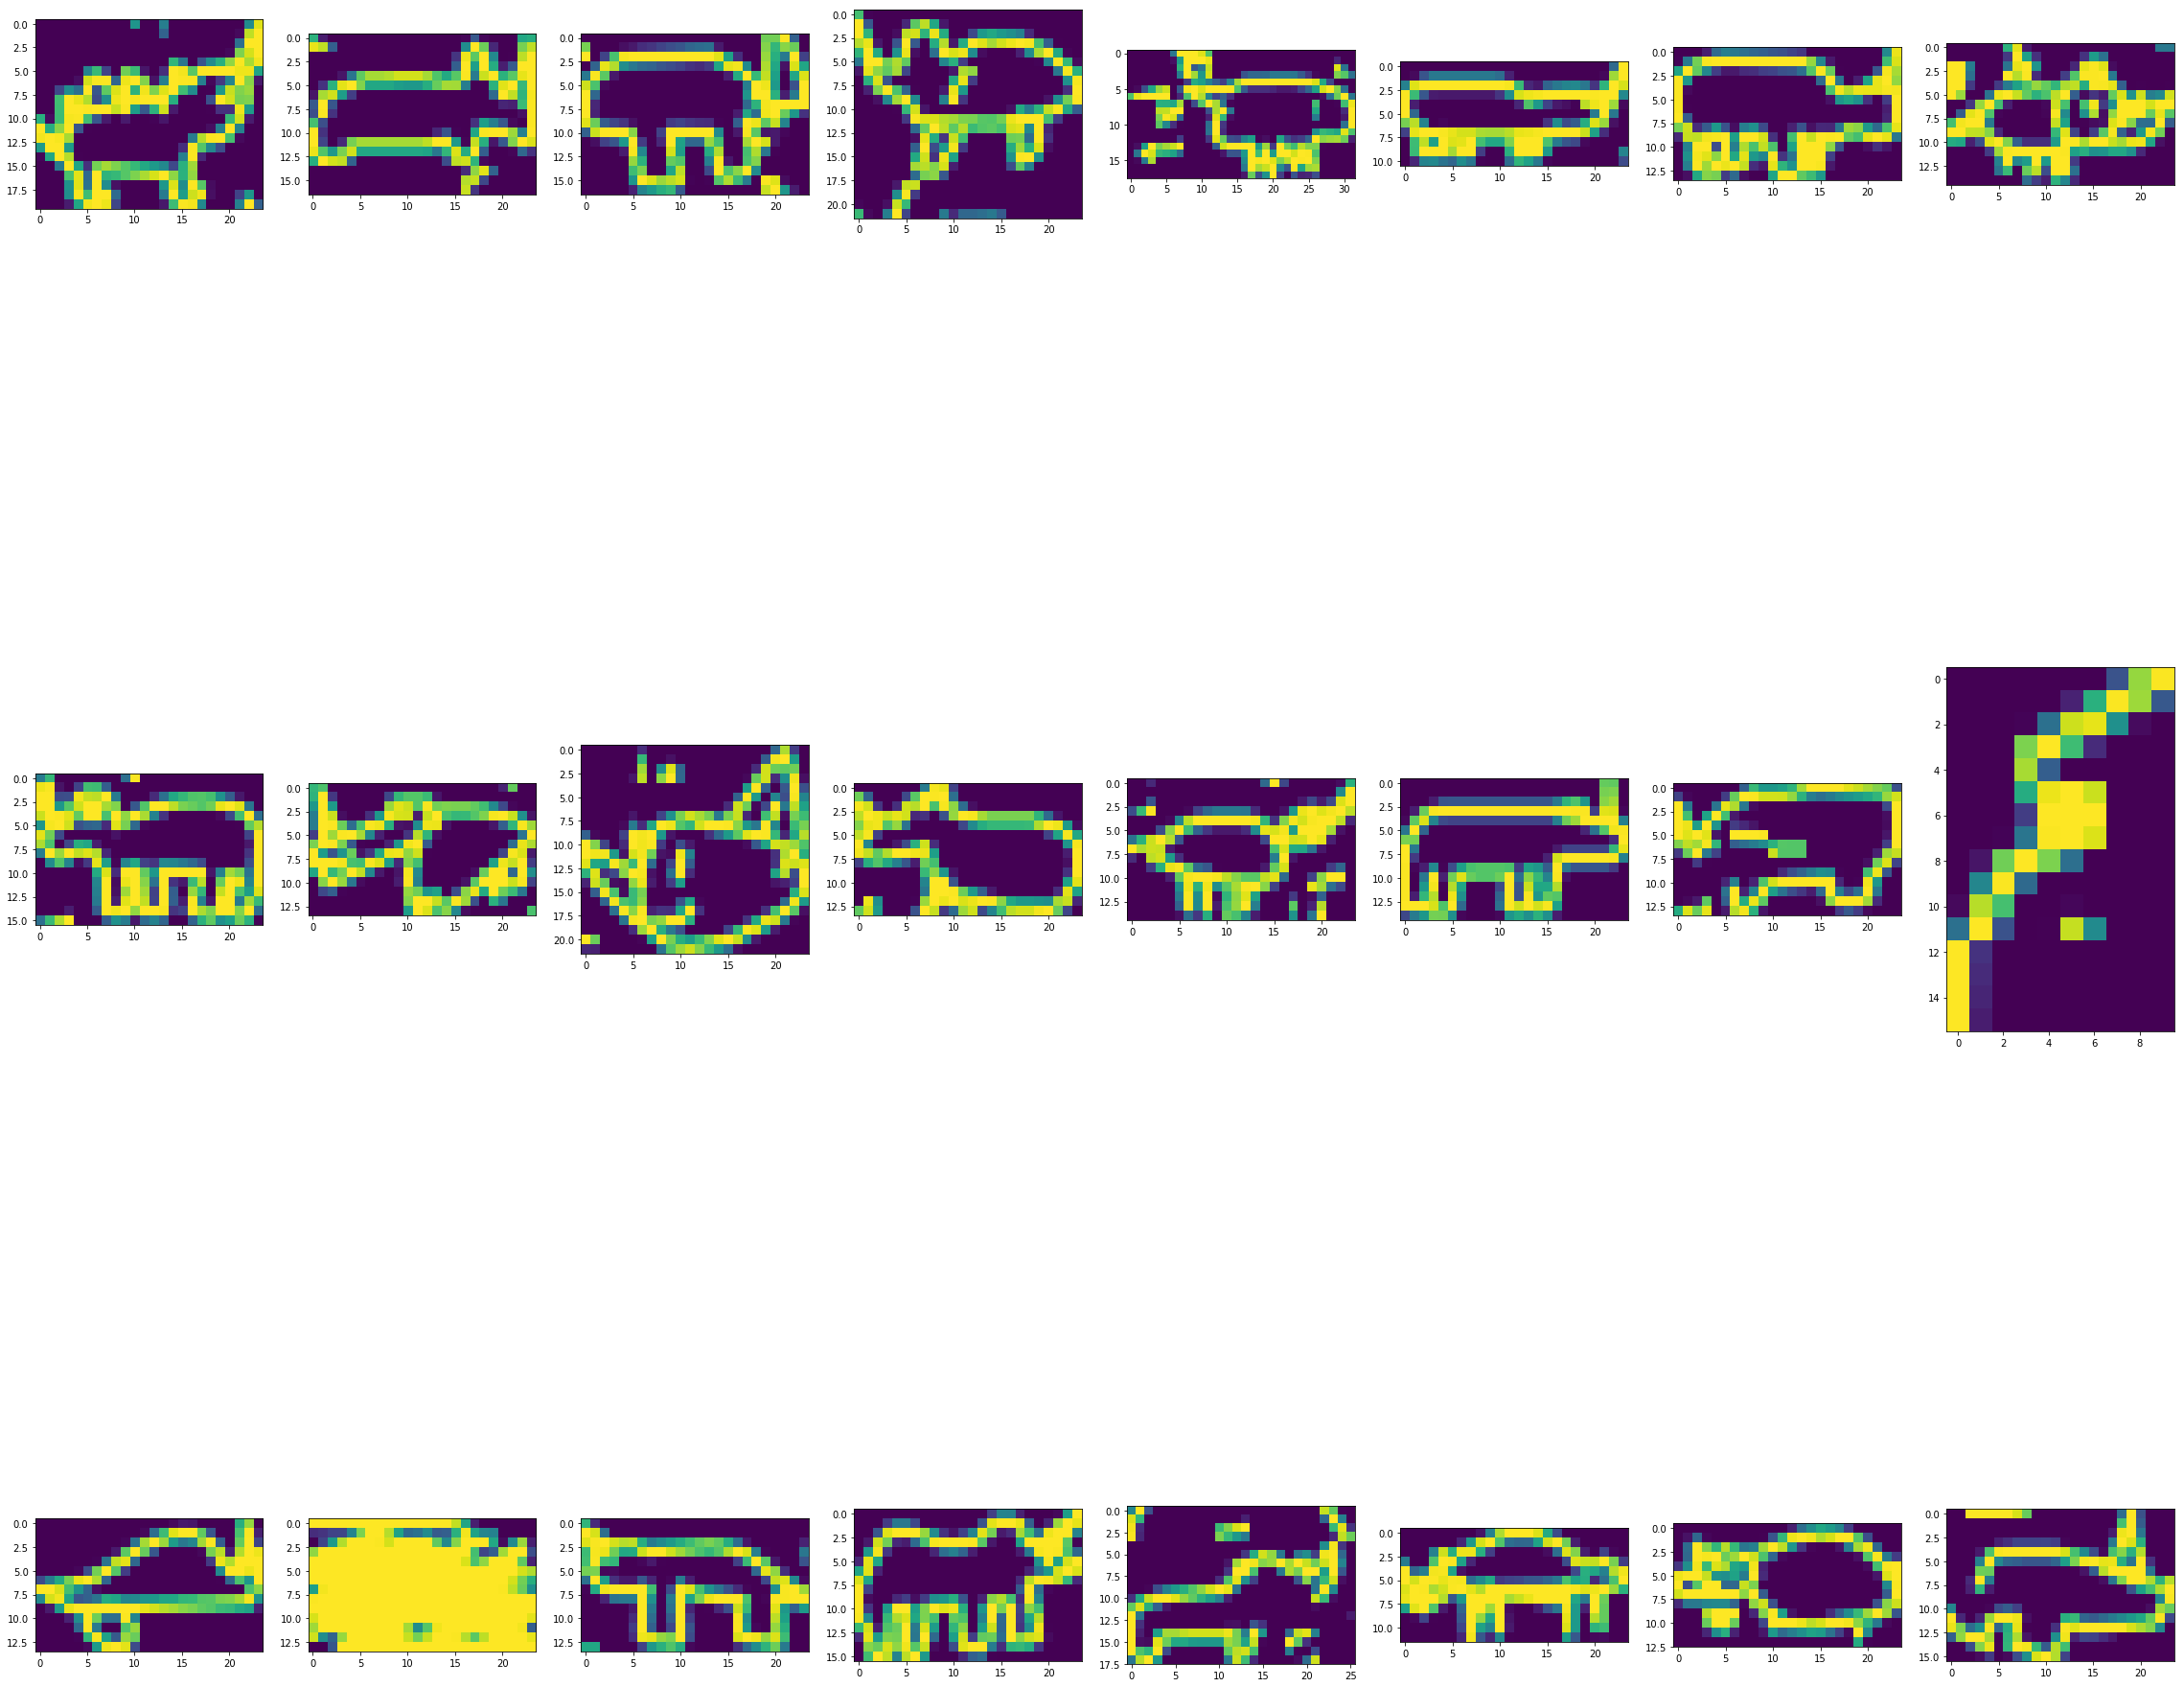

empty


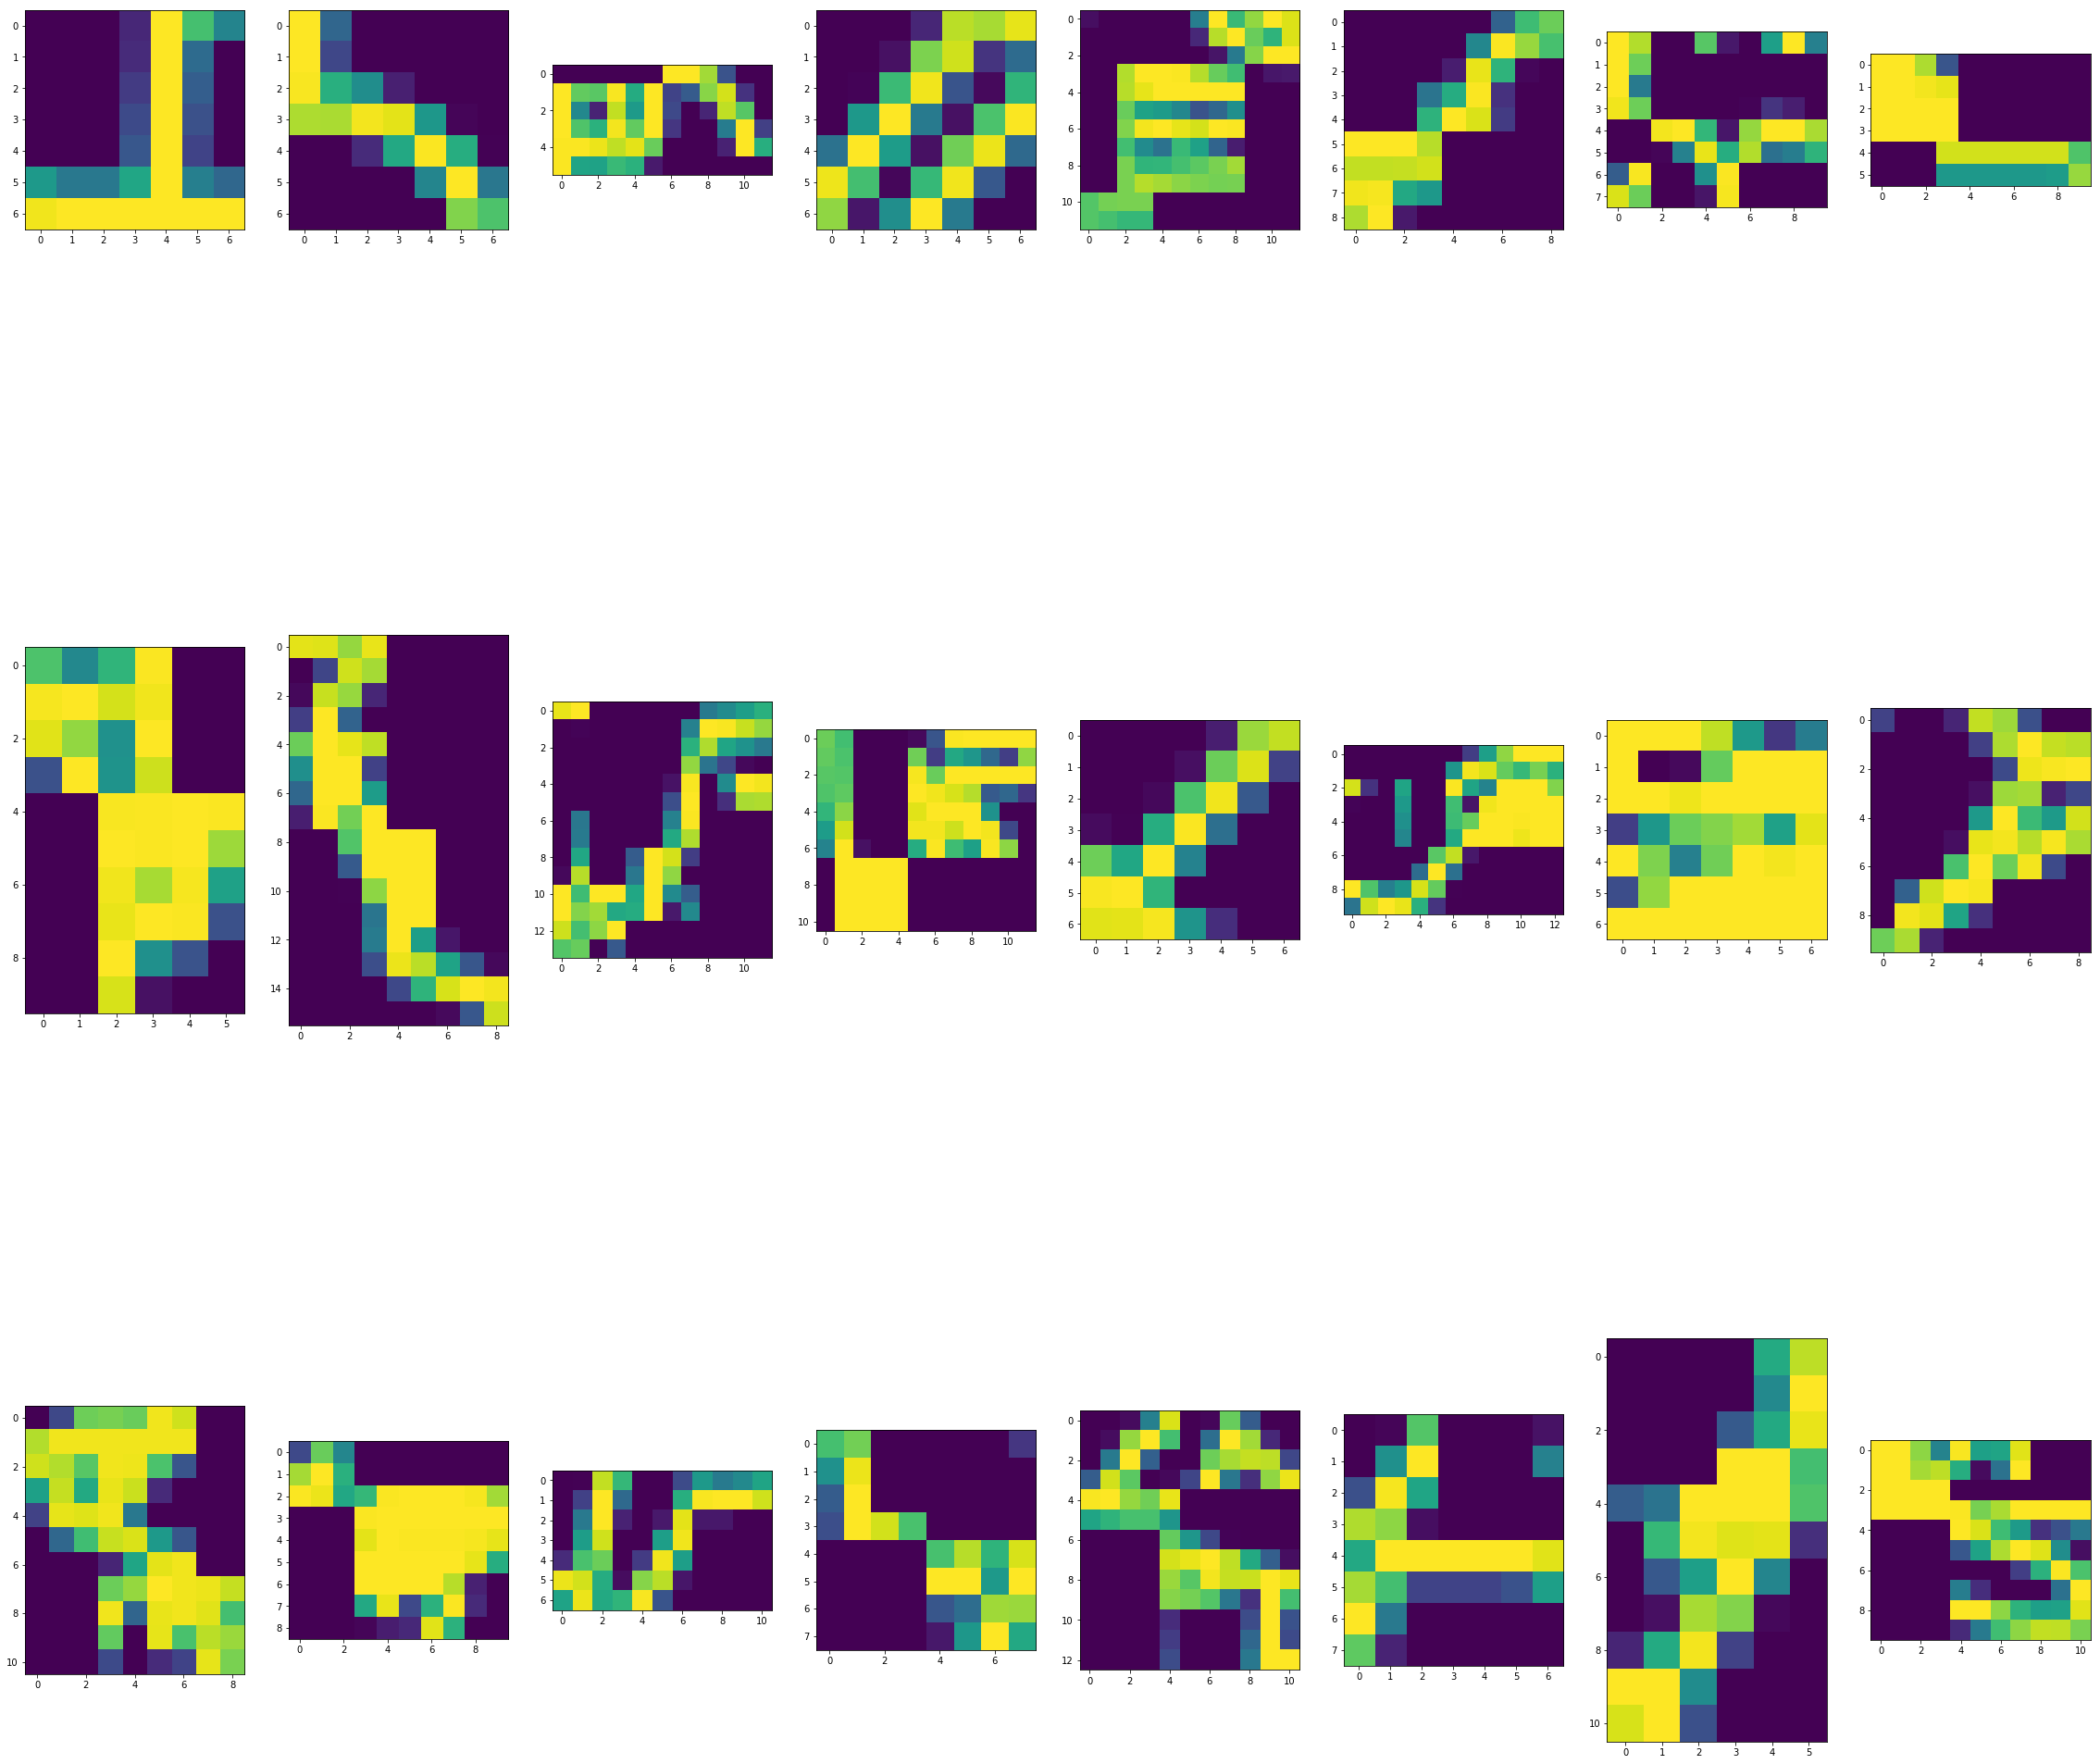

parrot


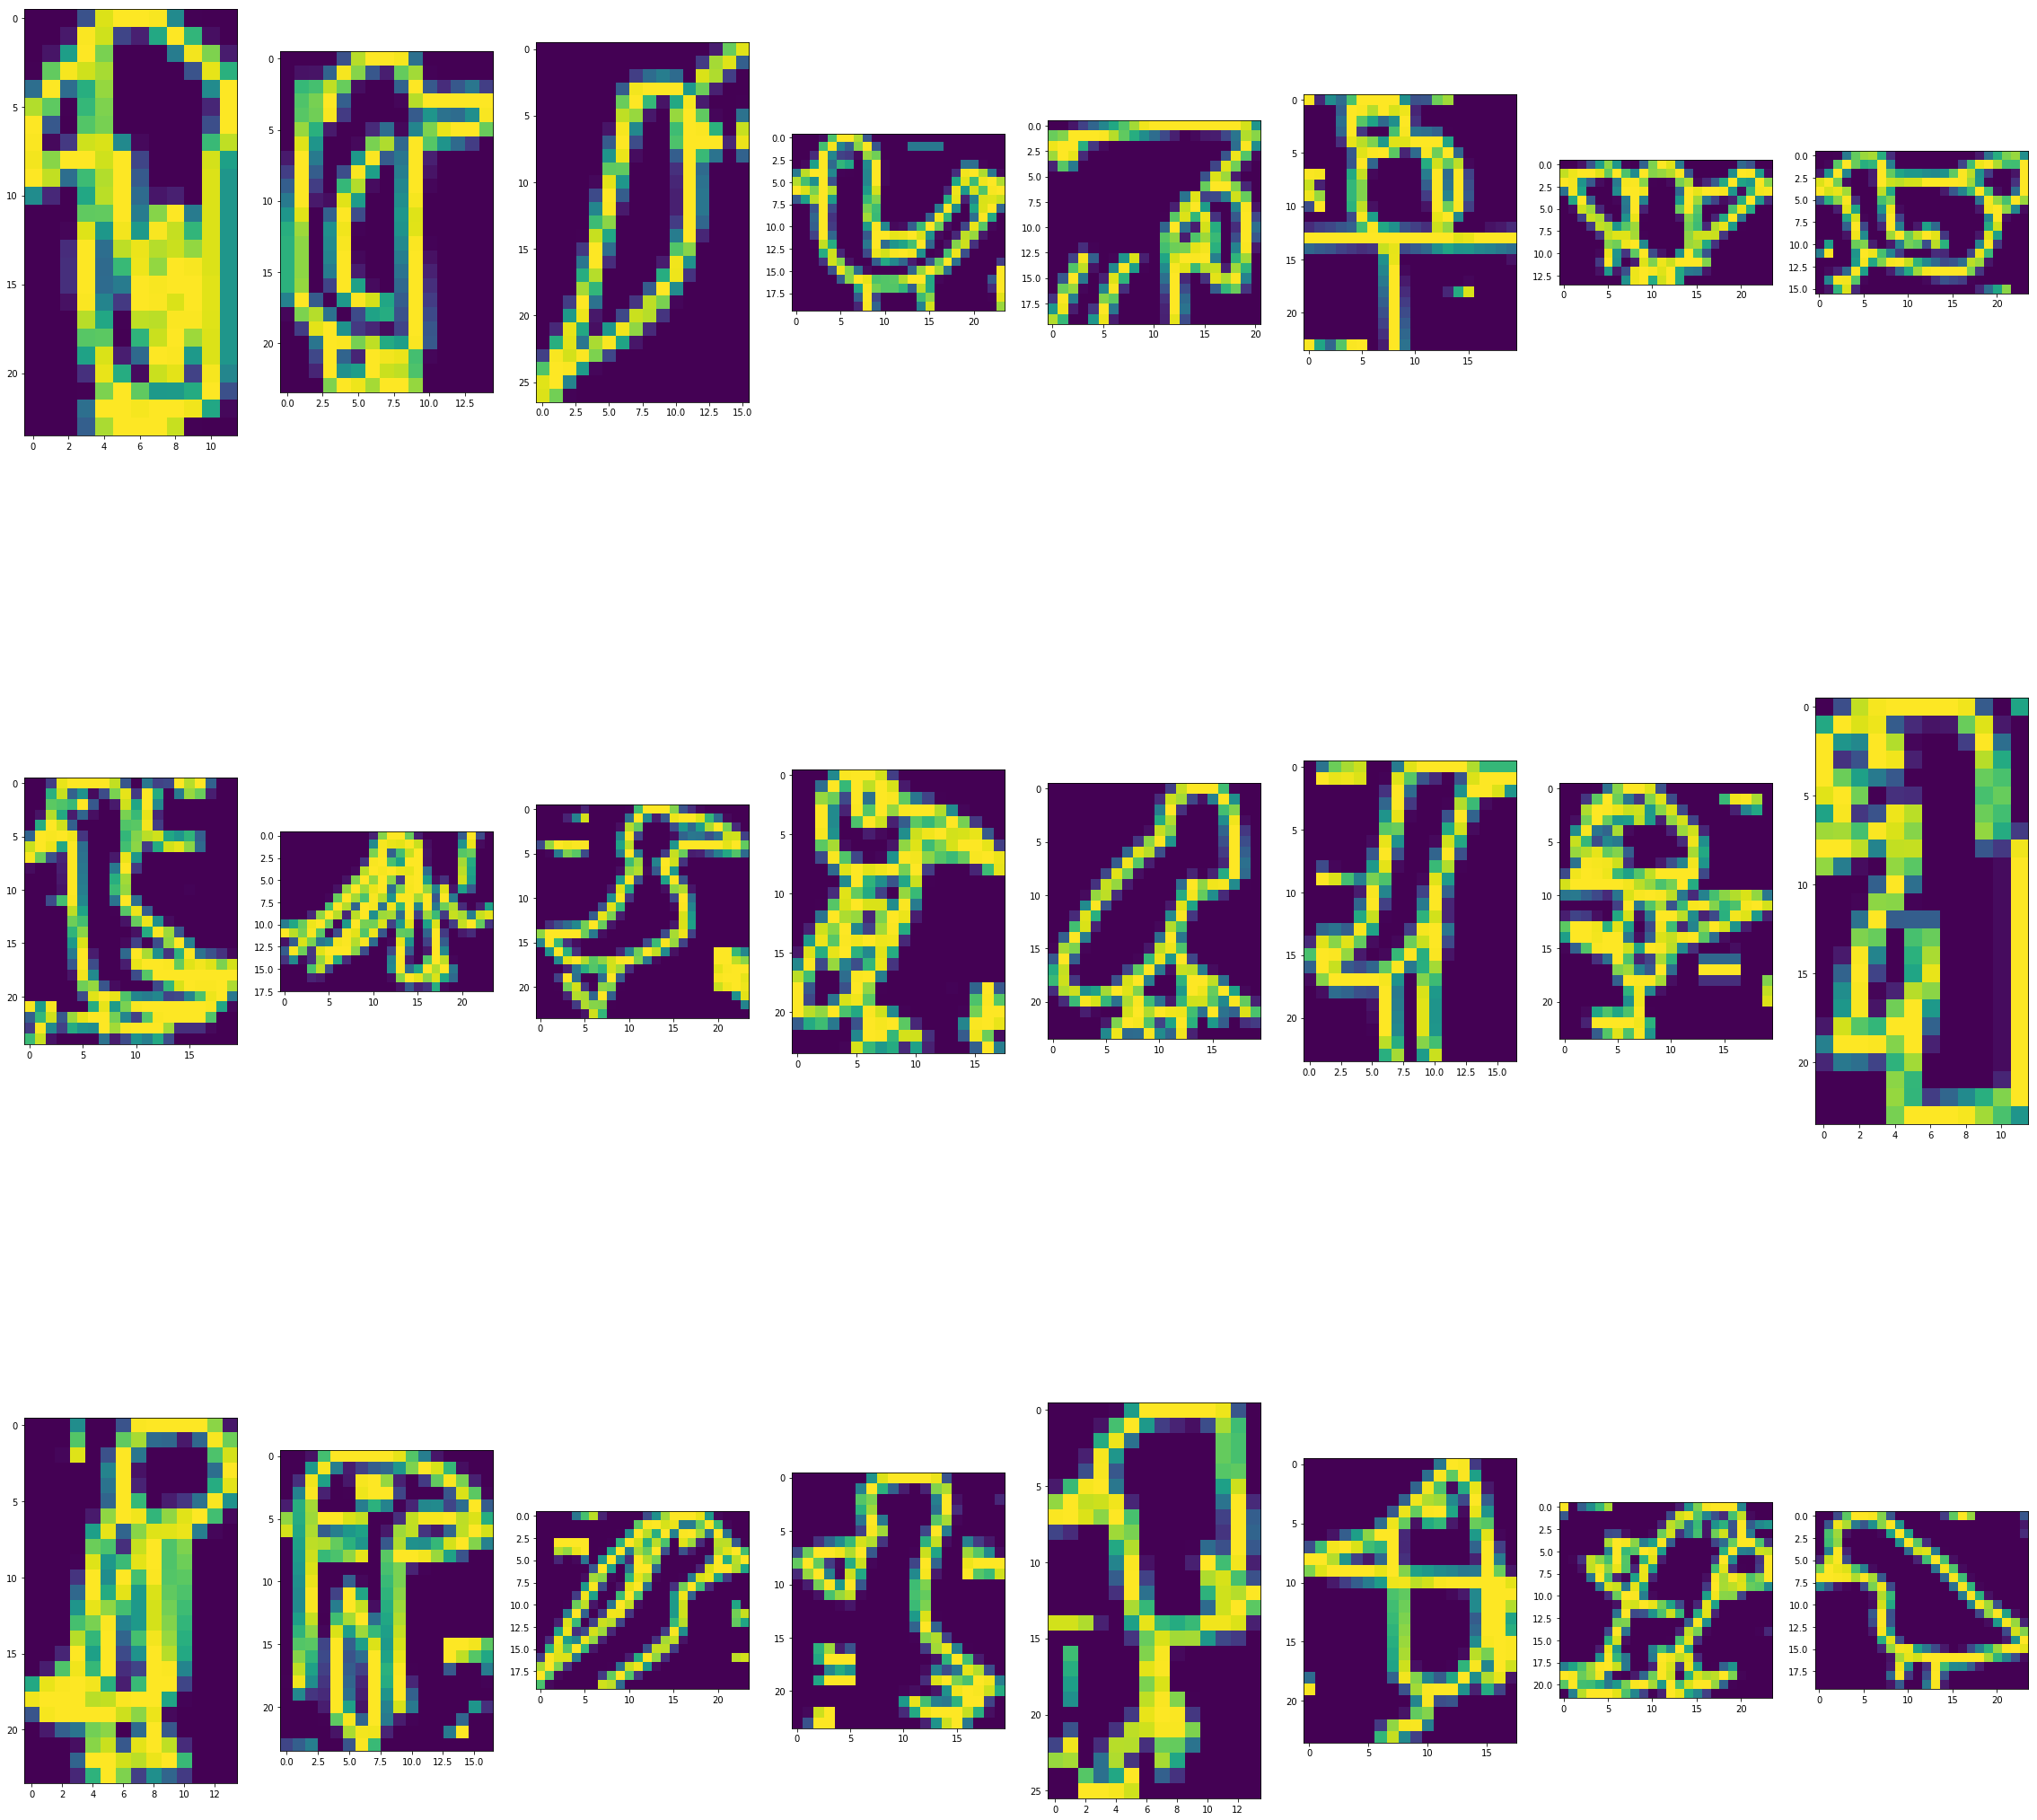

pillow


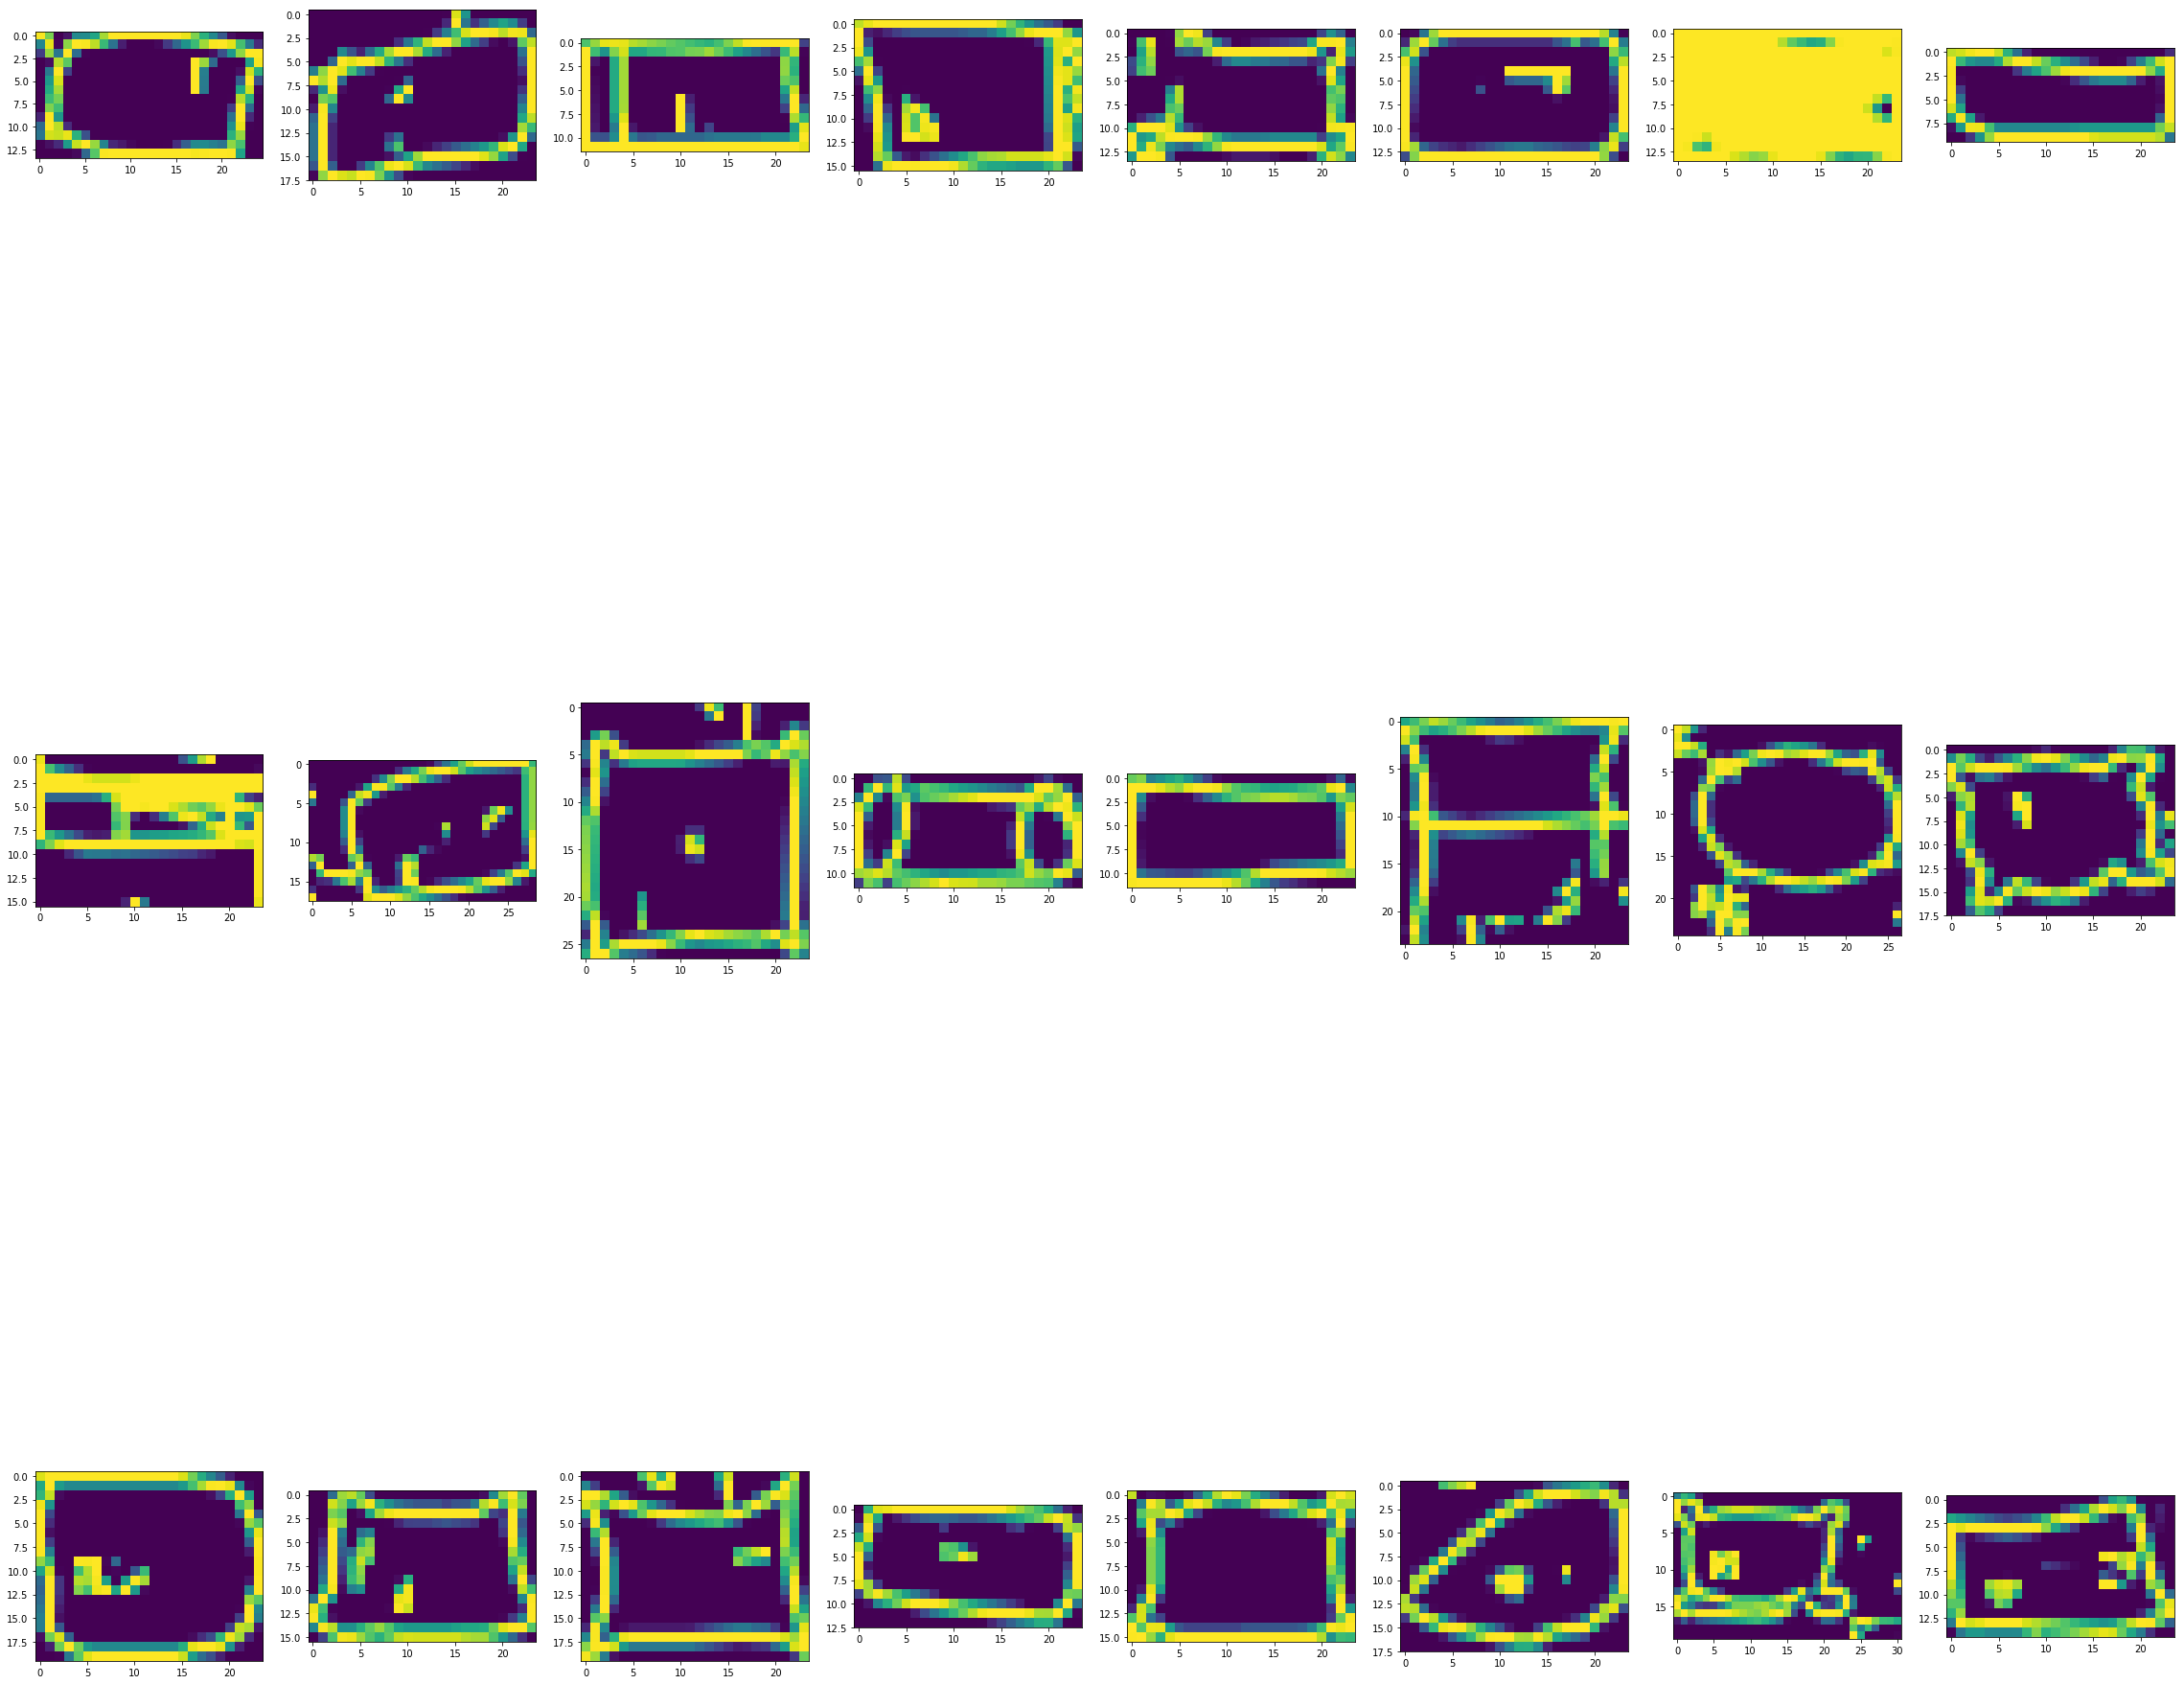

screwdriver


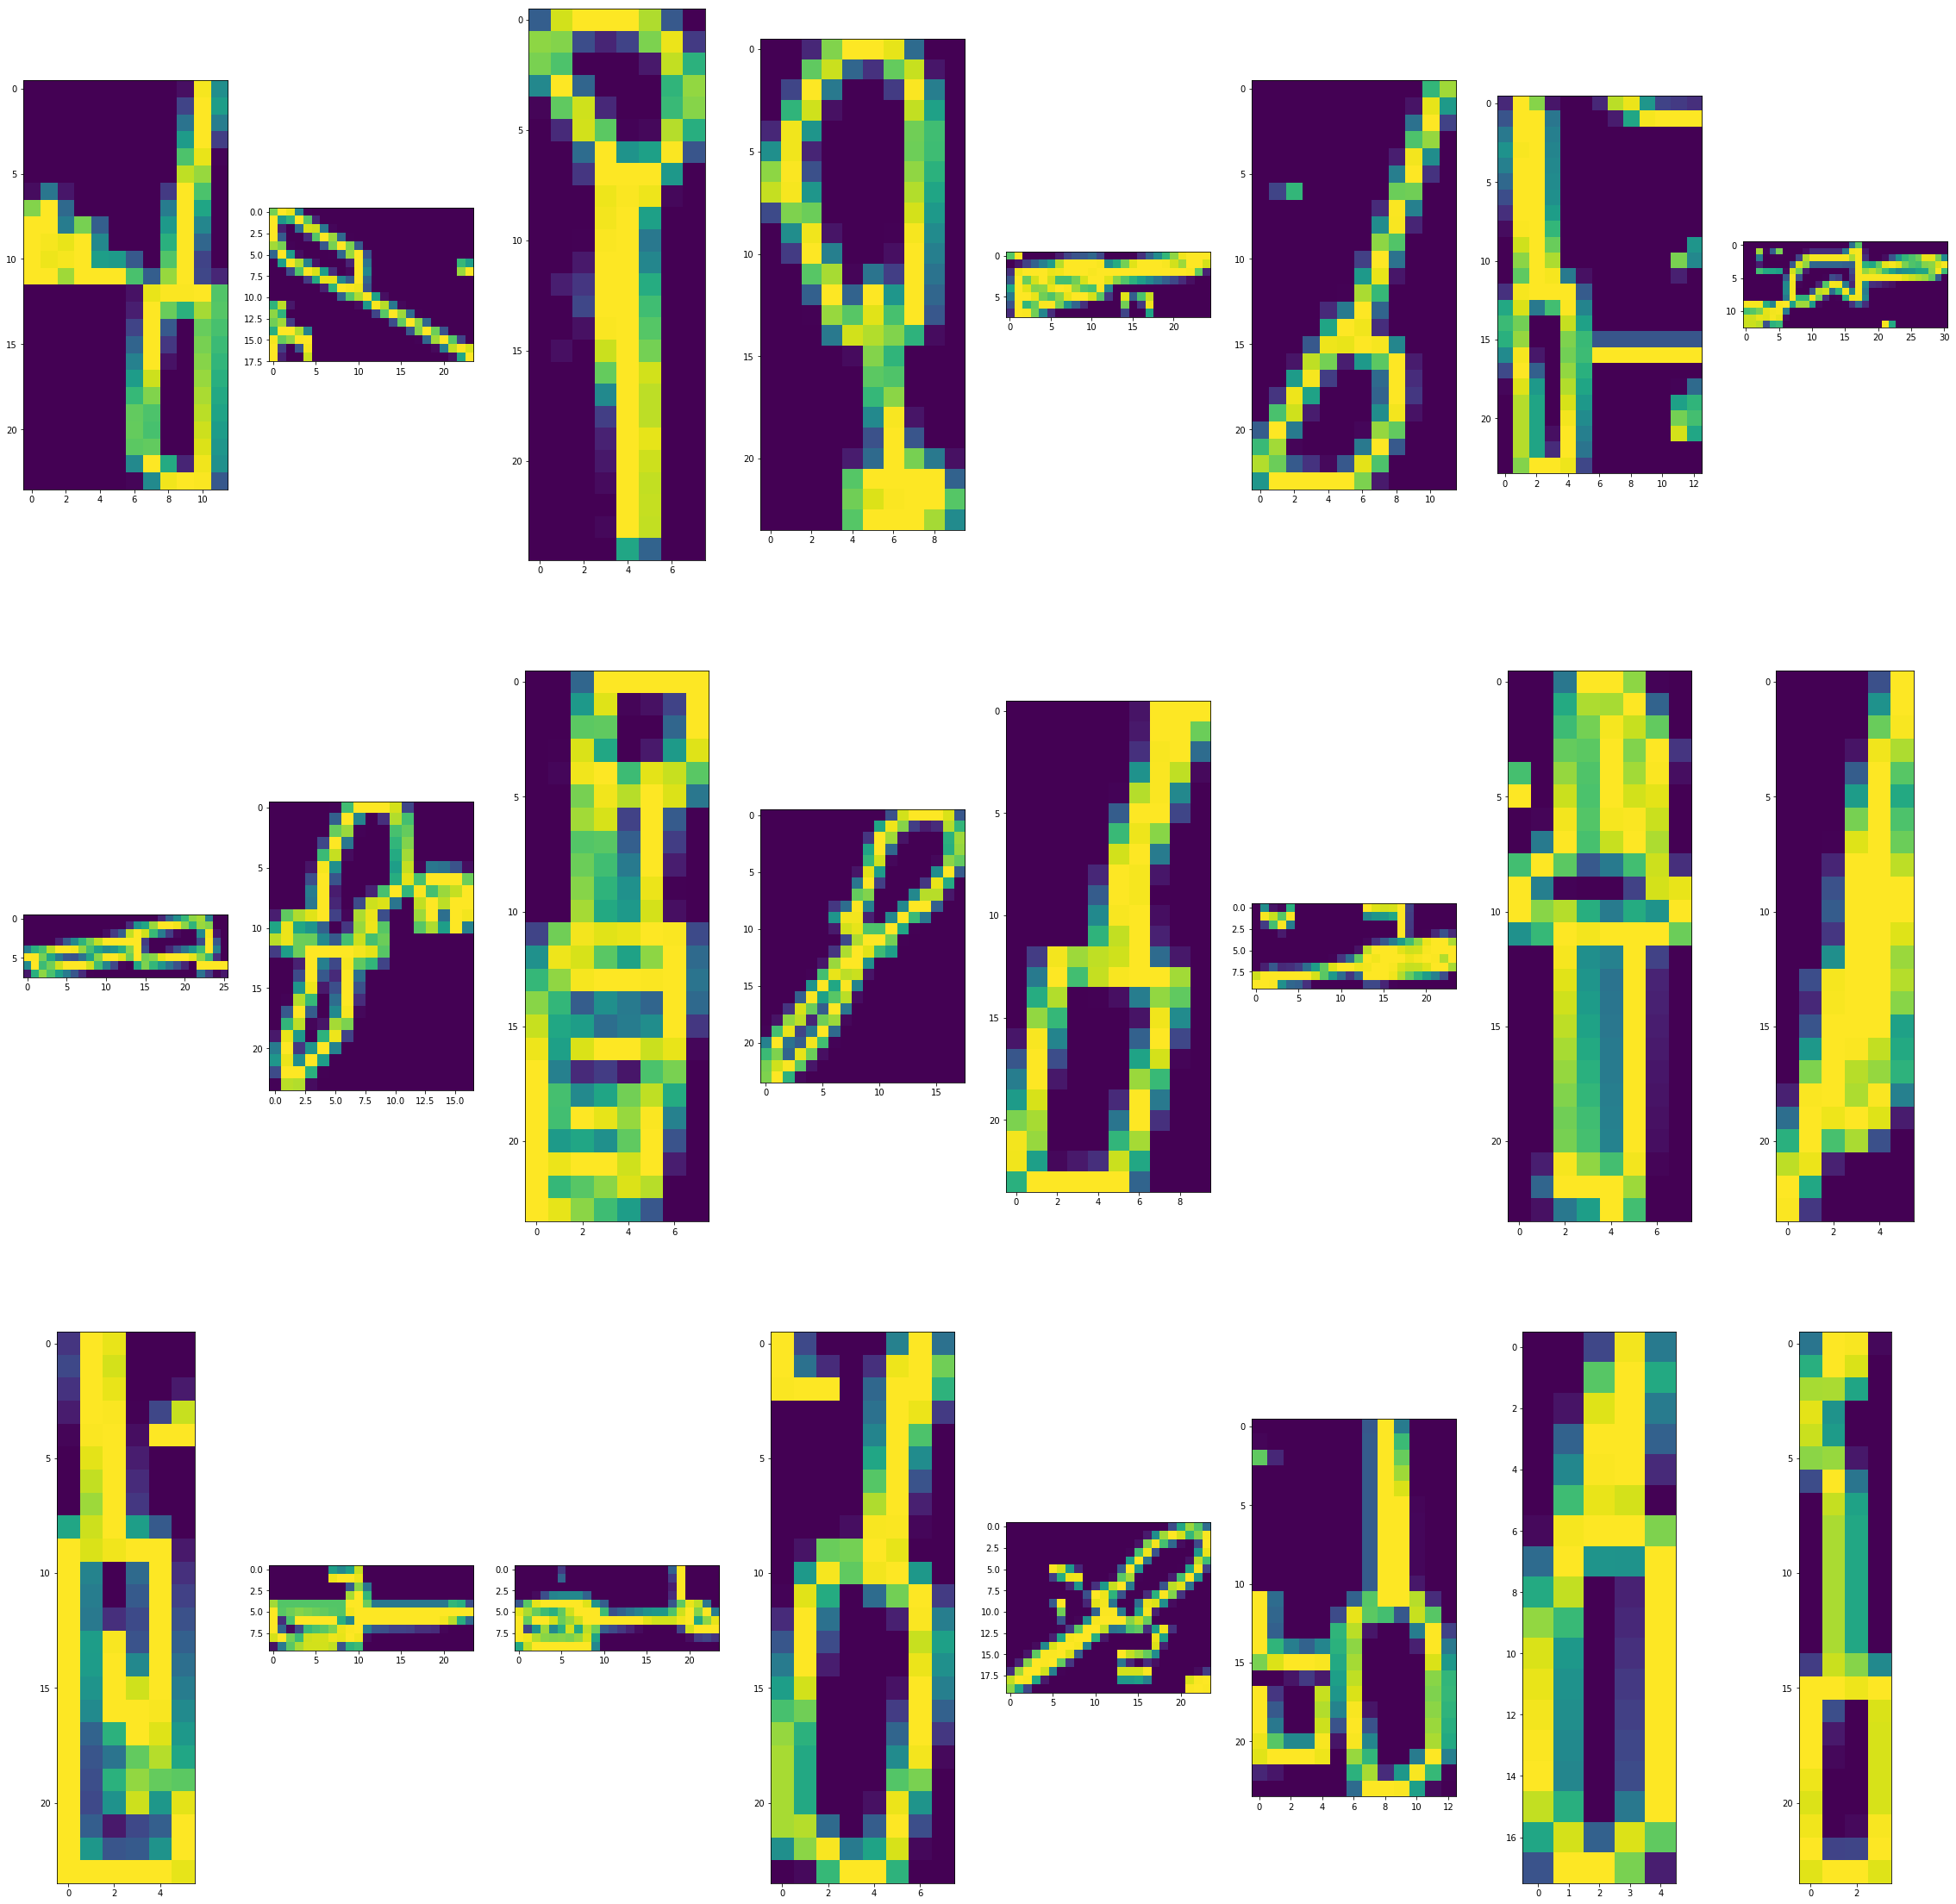

panda


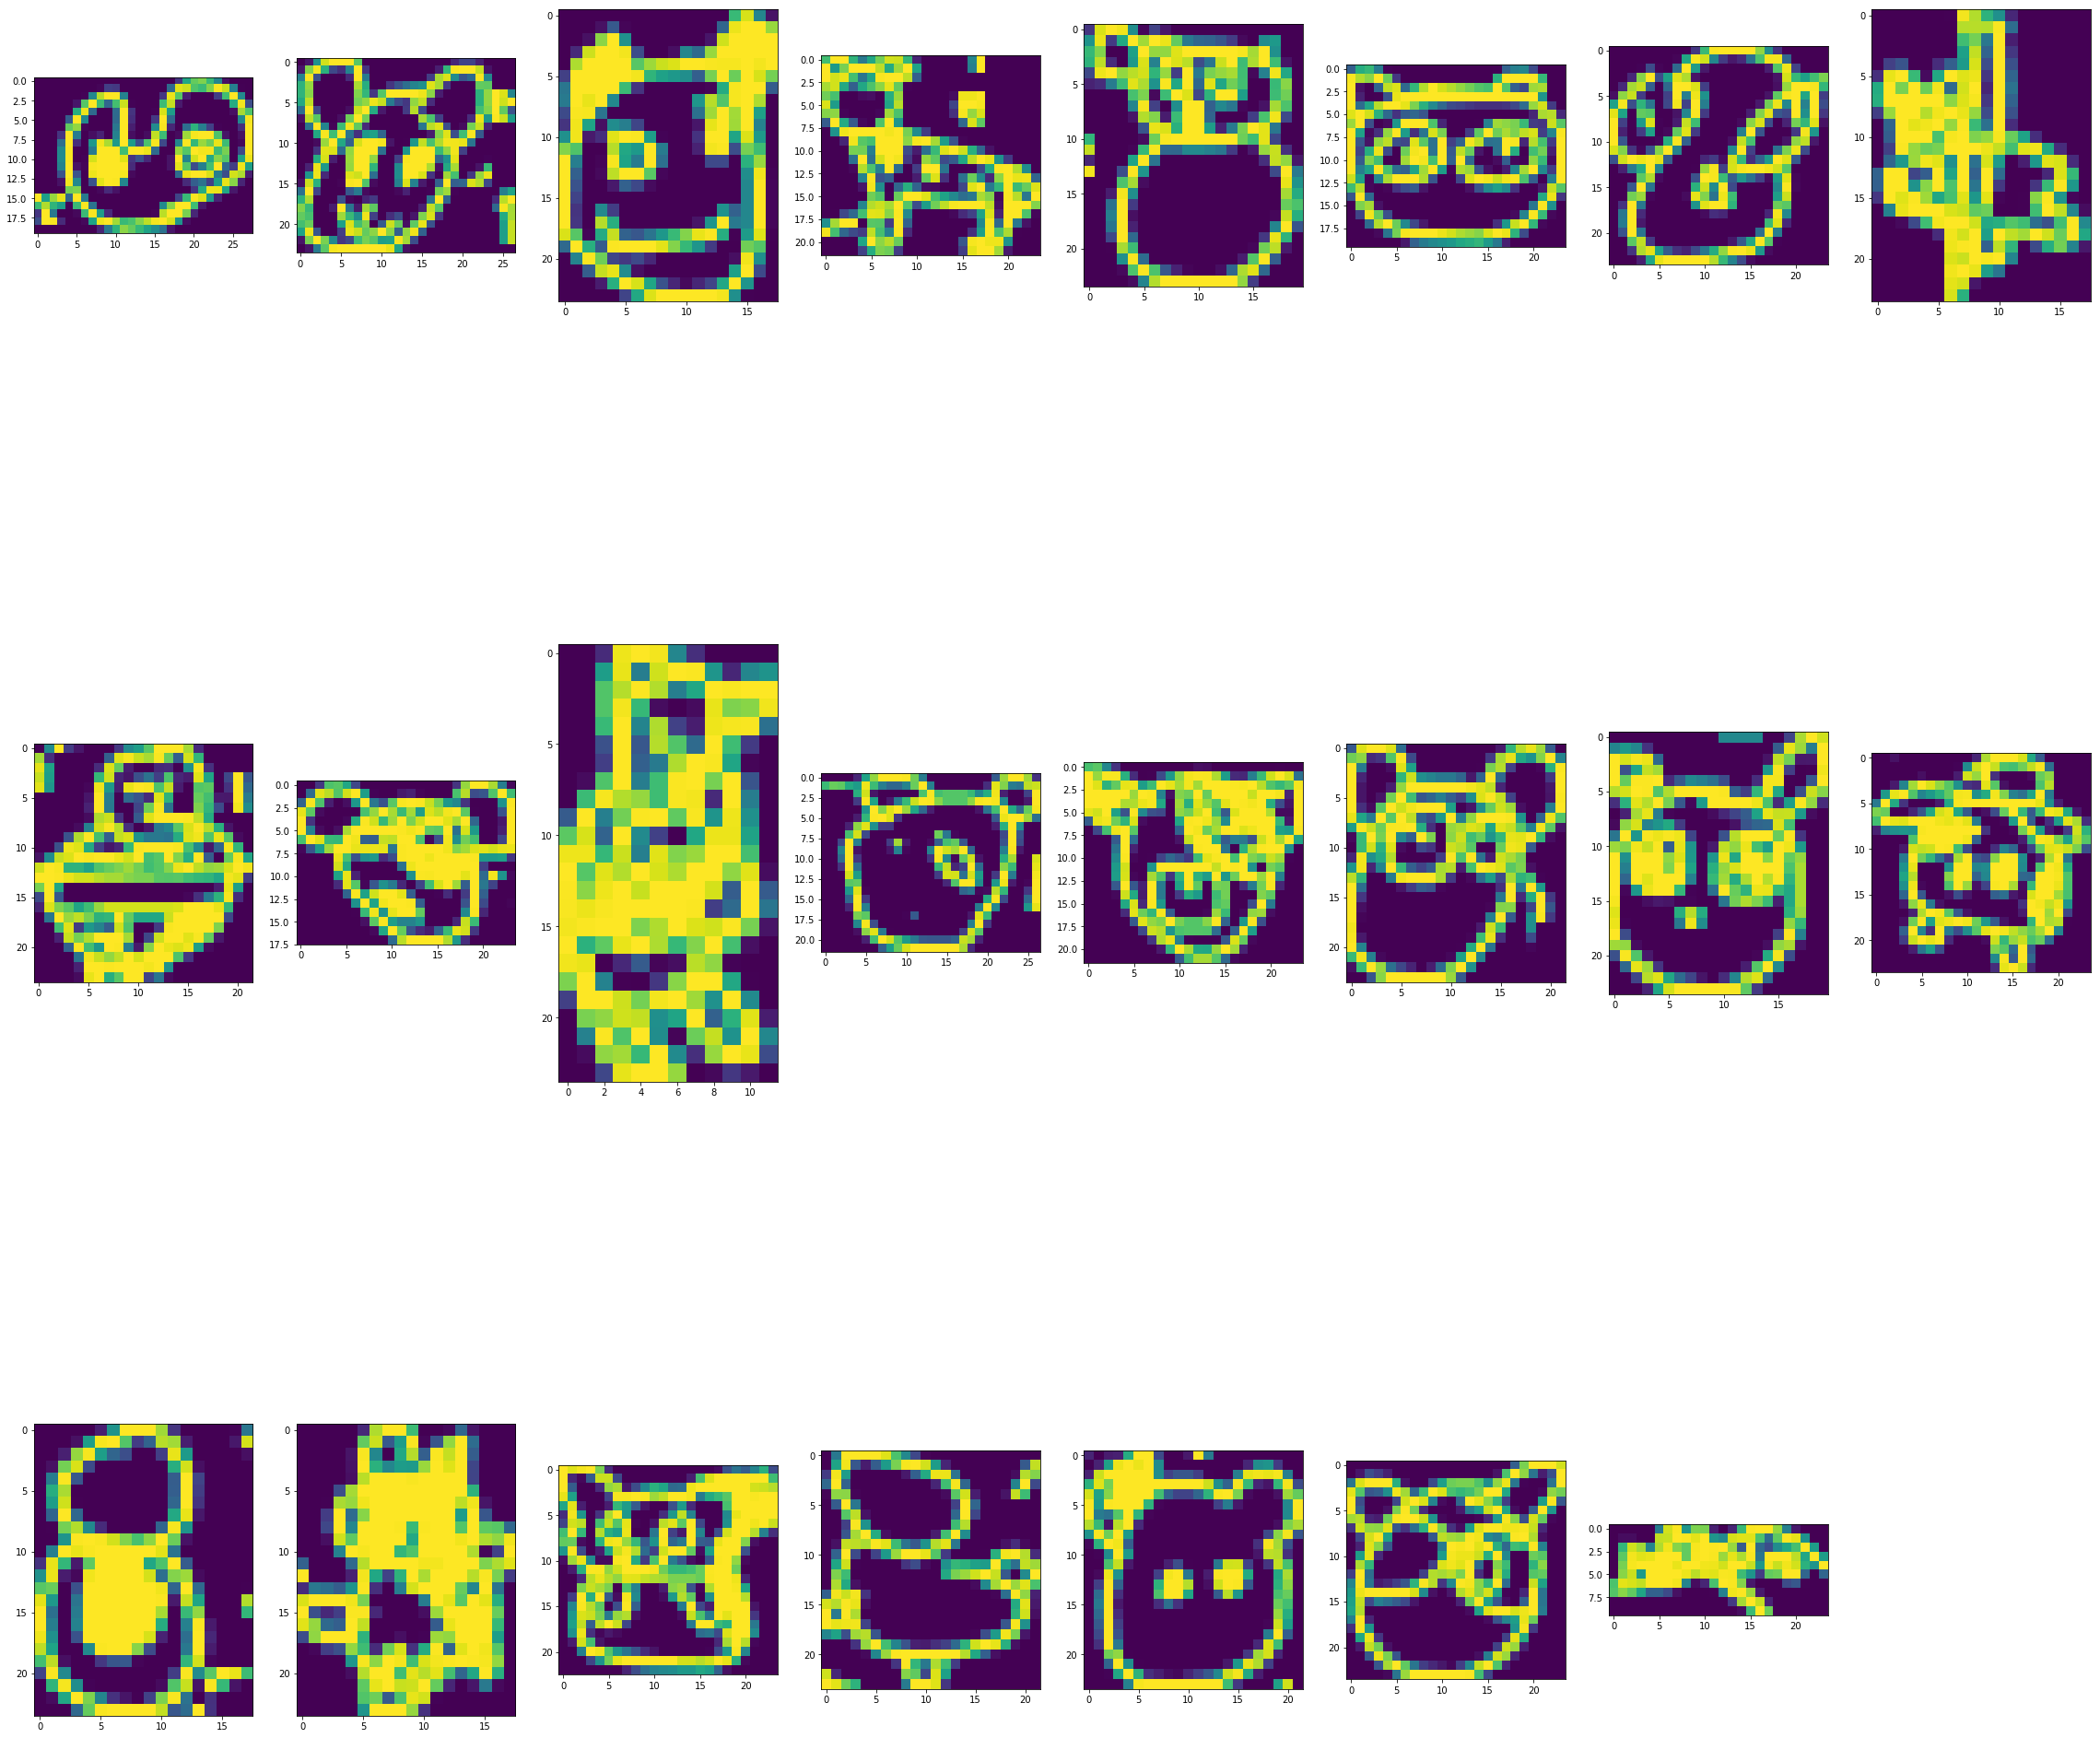

sink


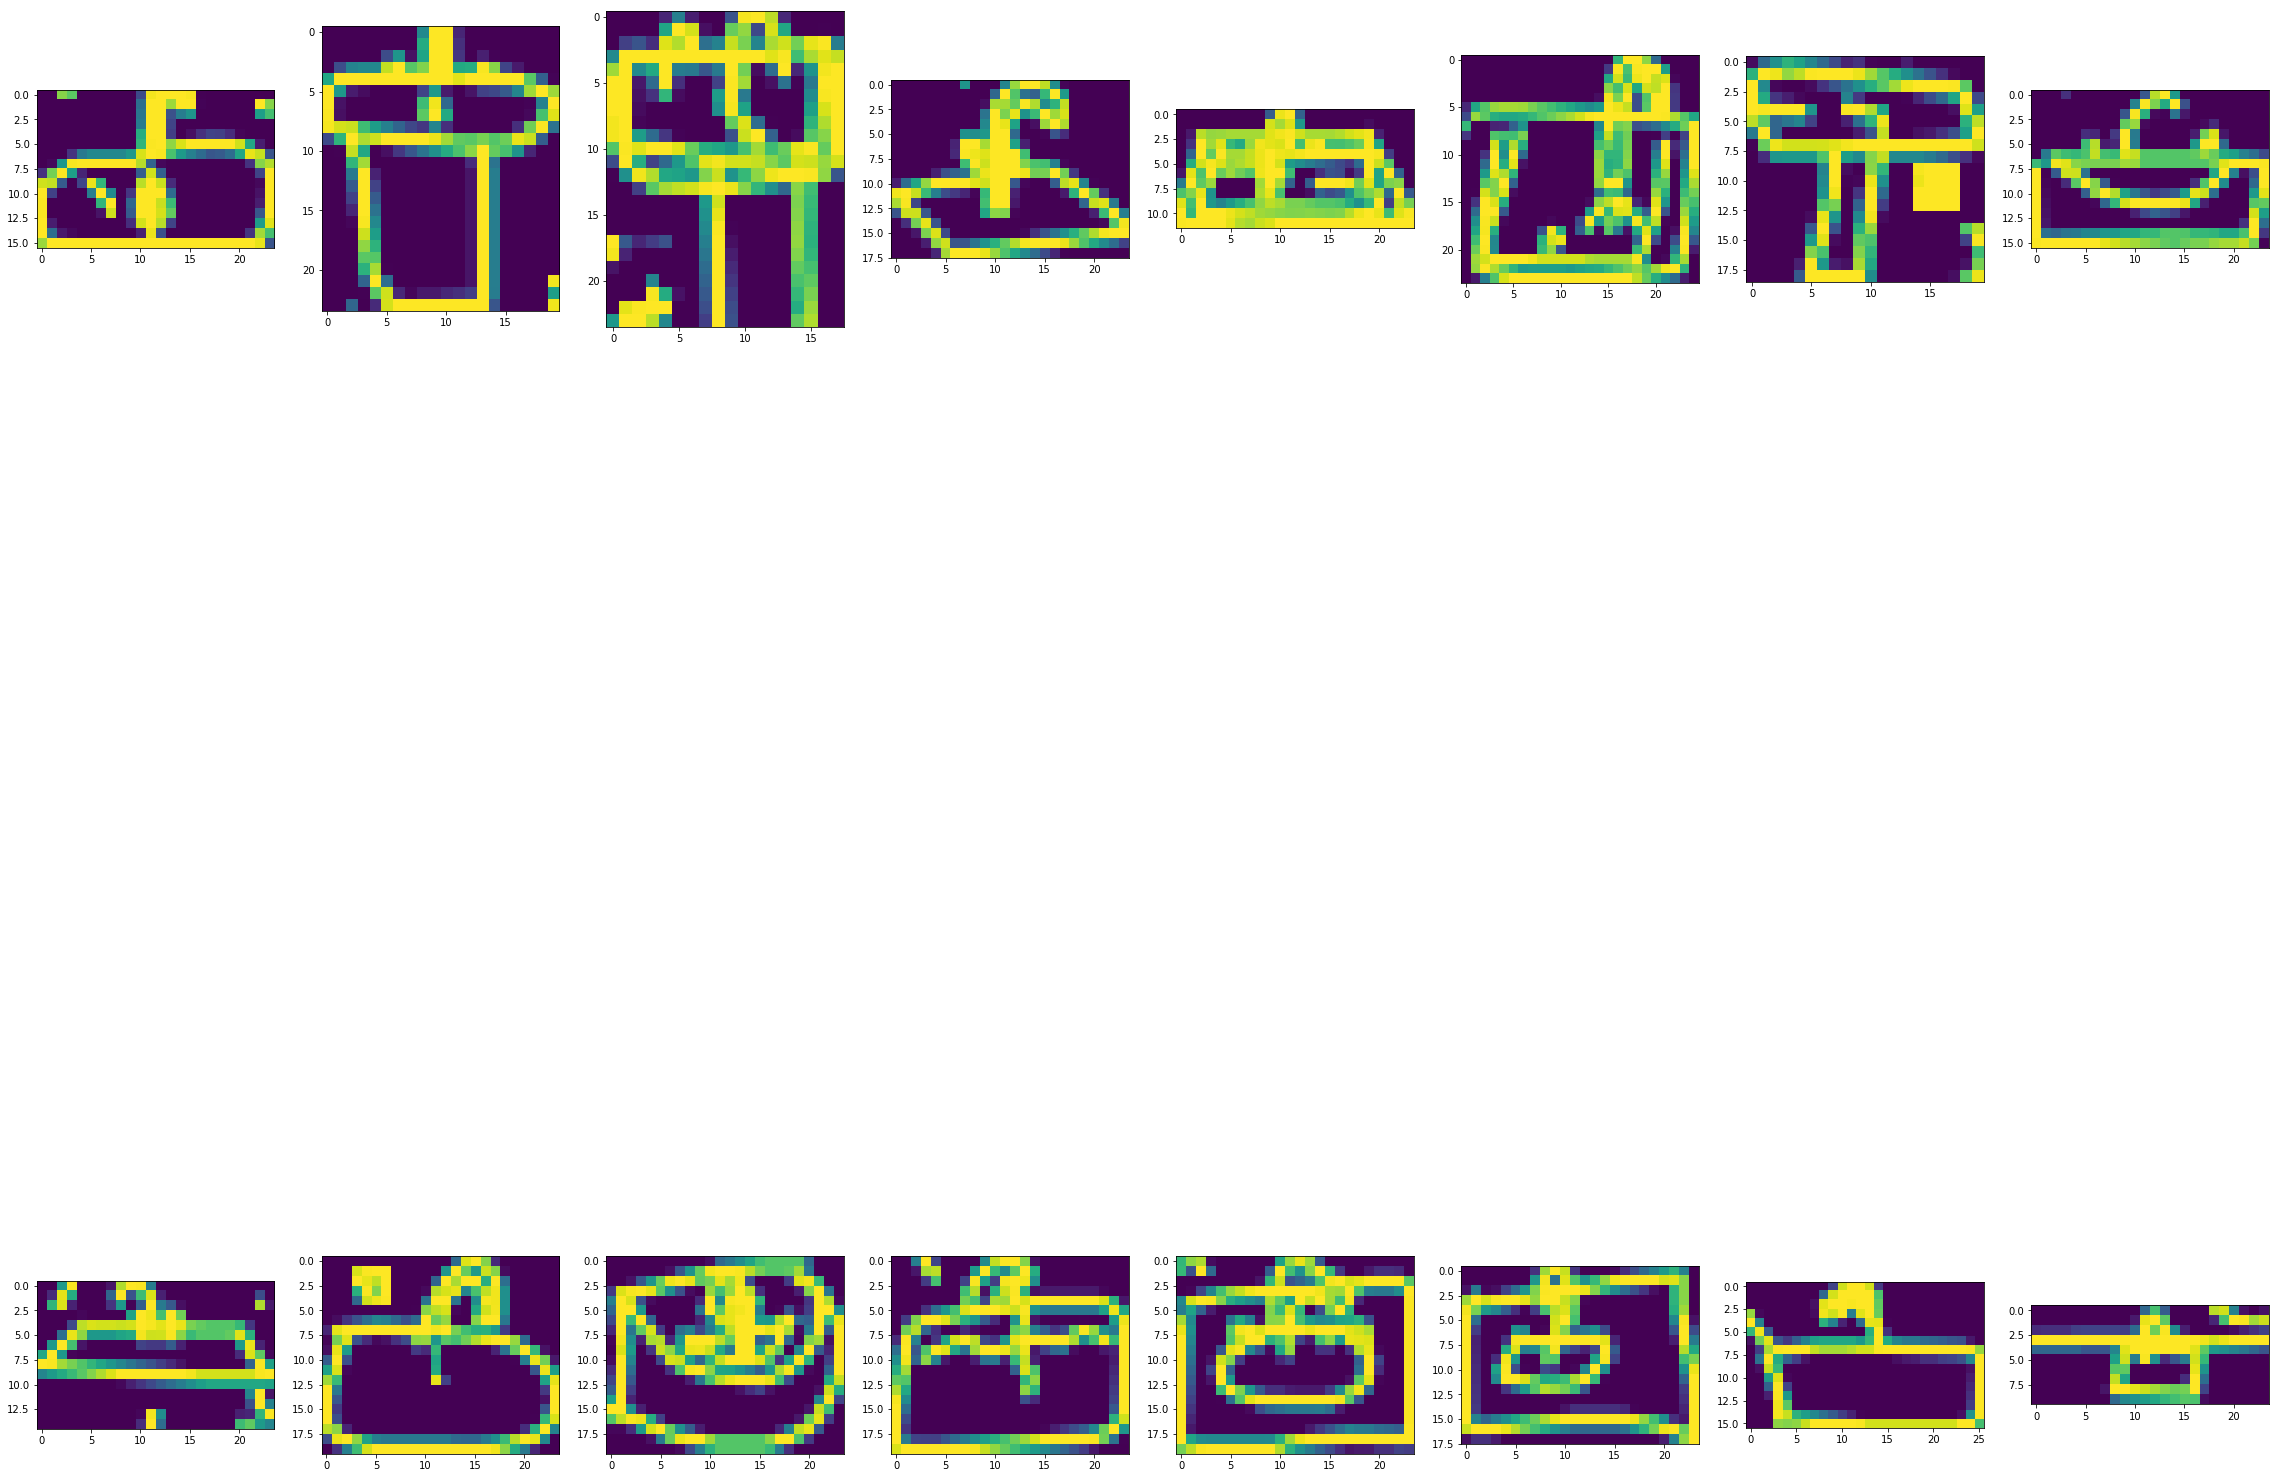

pear


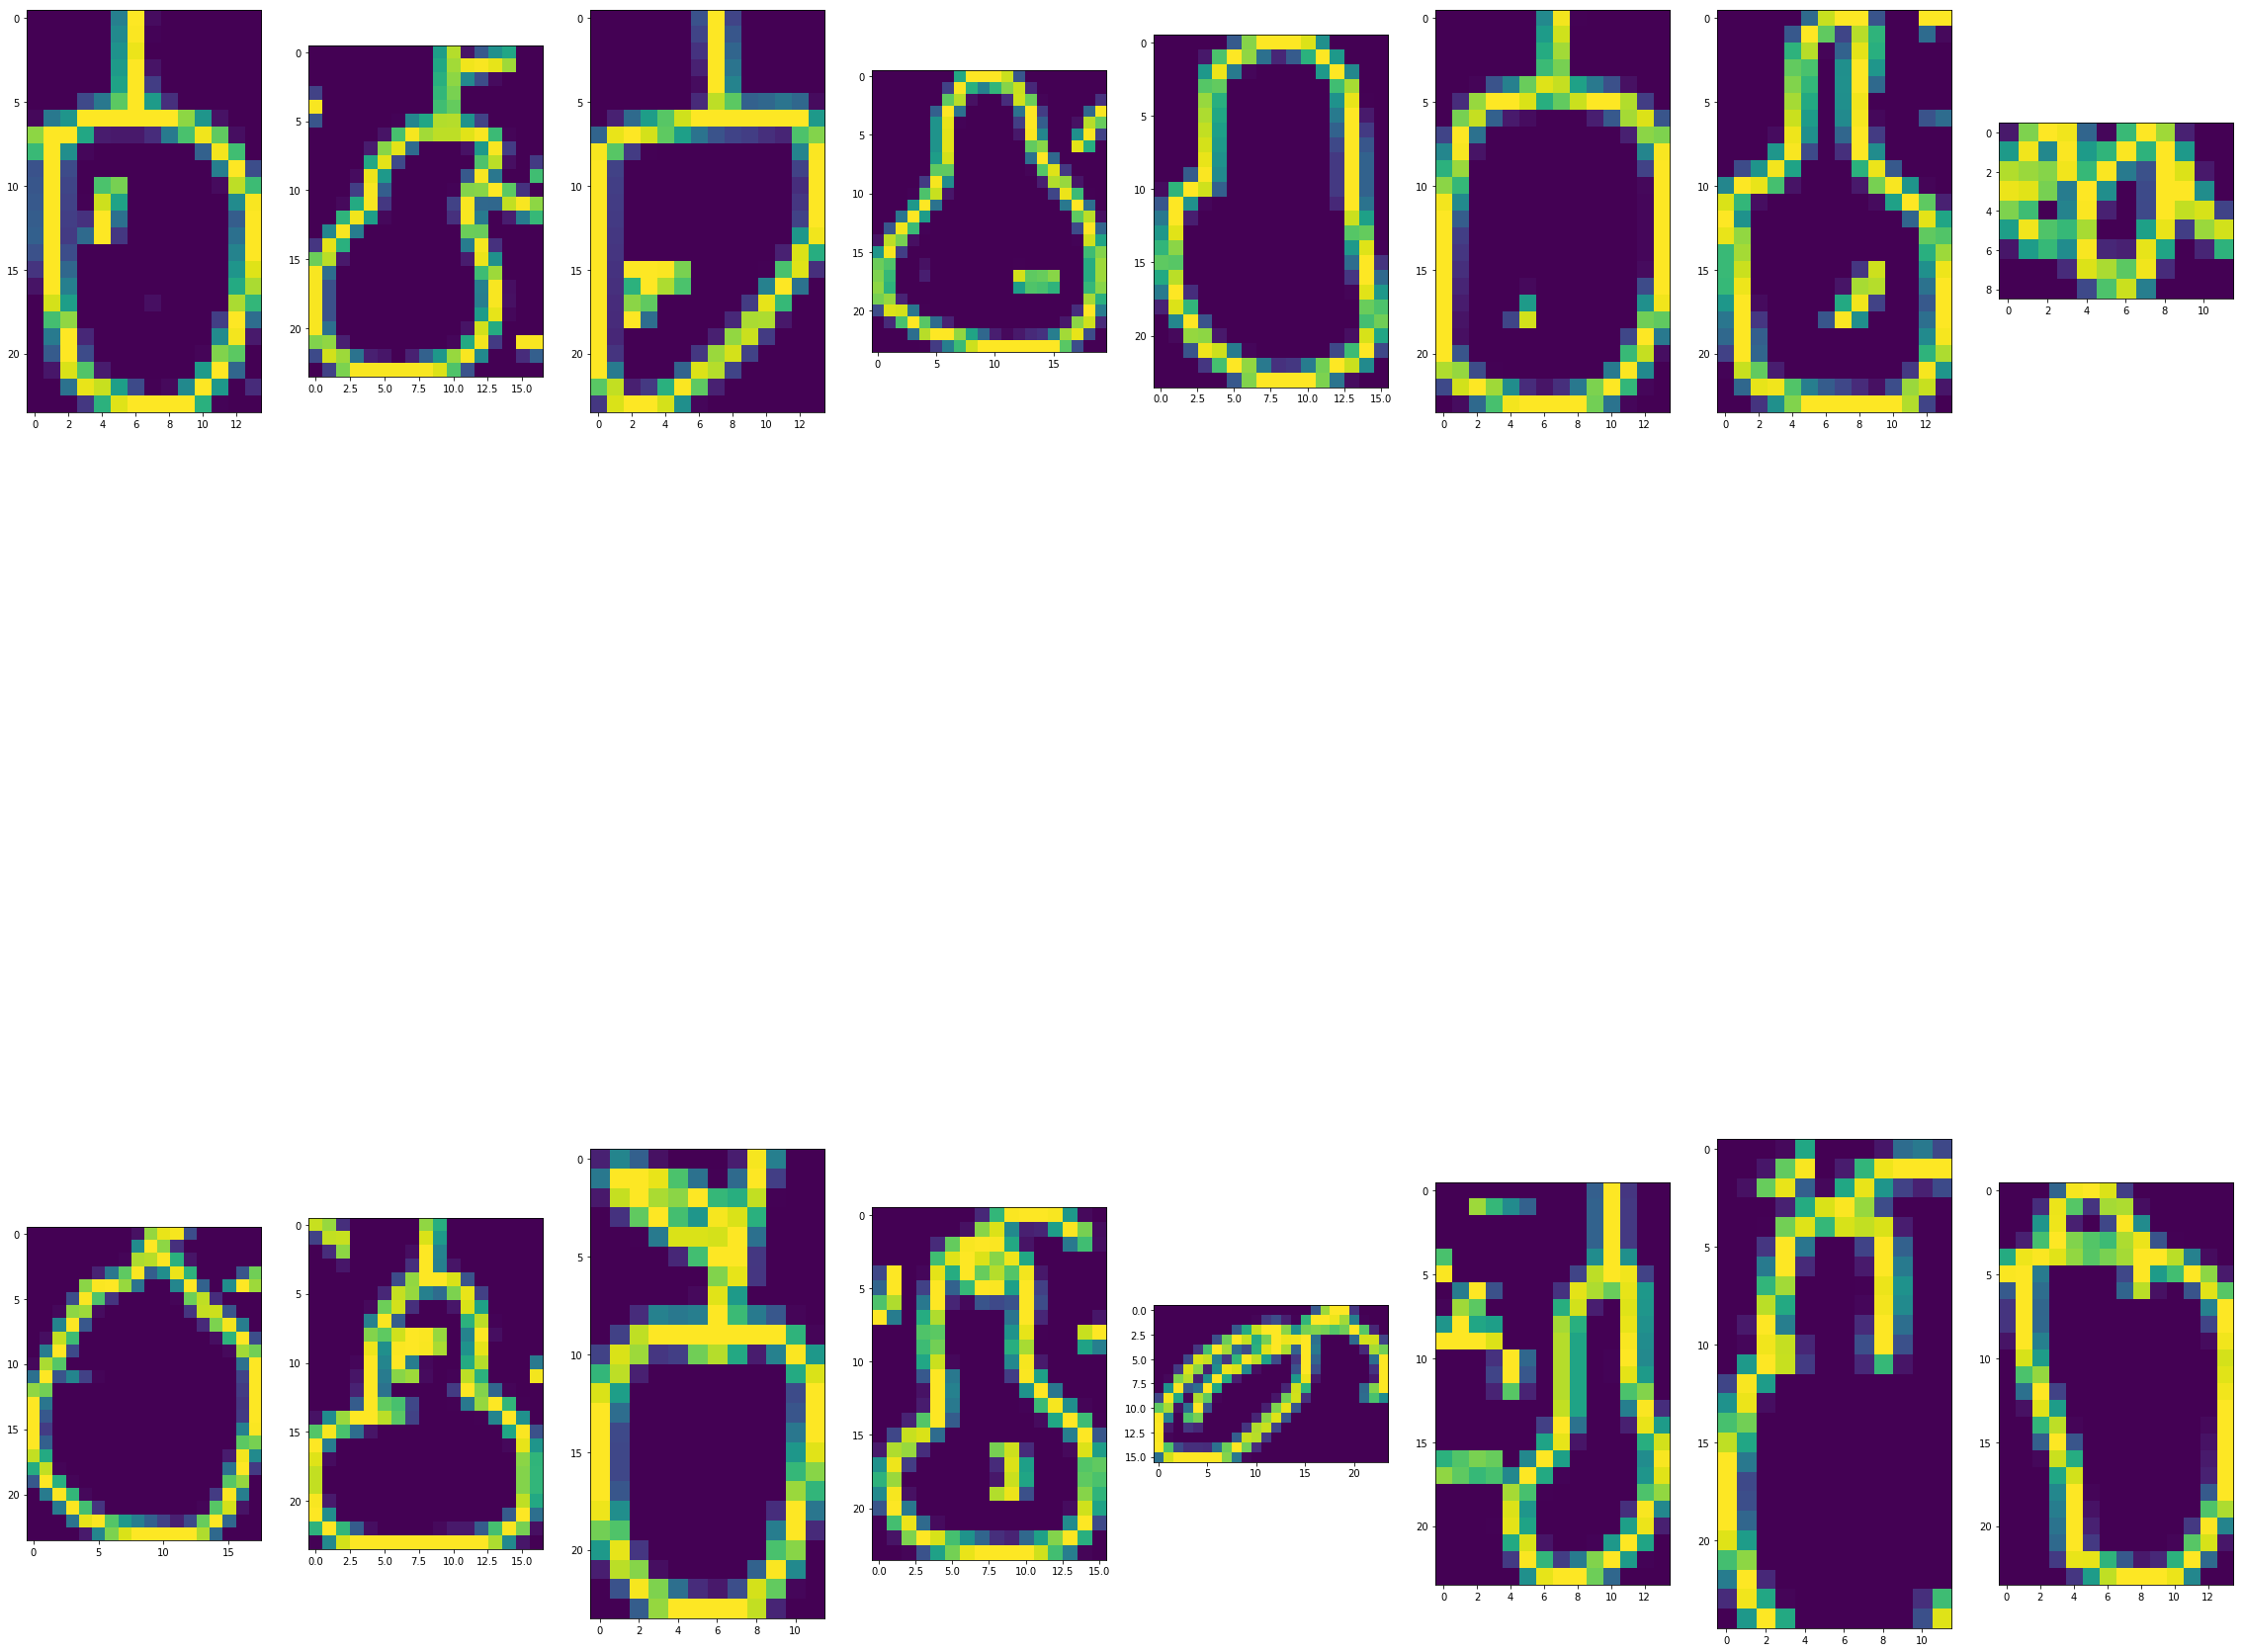

shovel


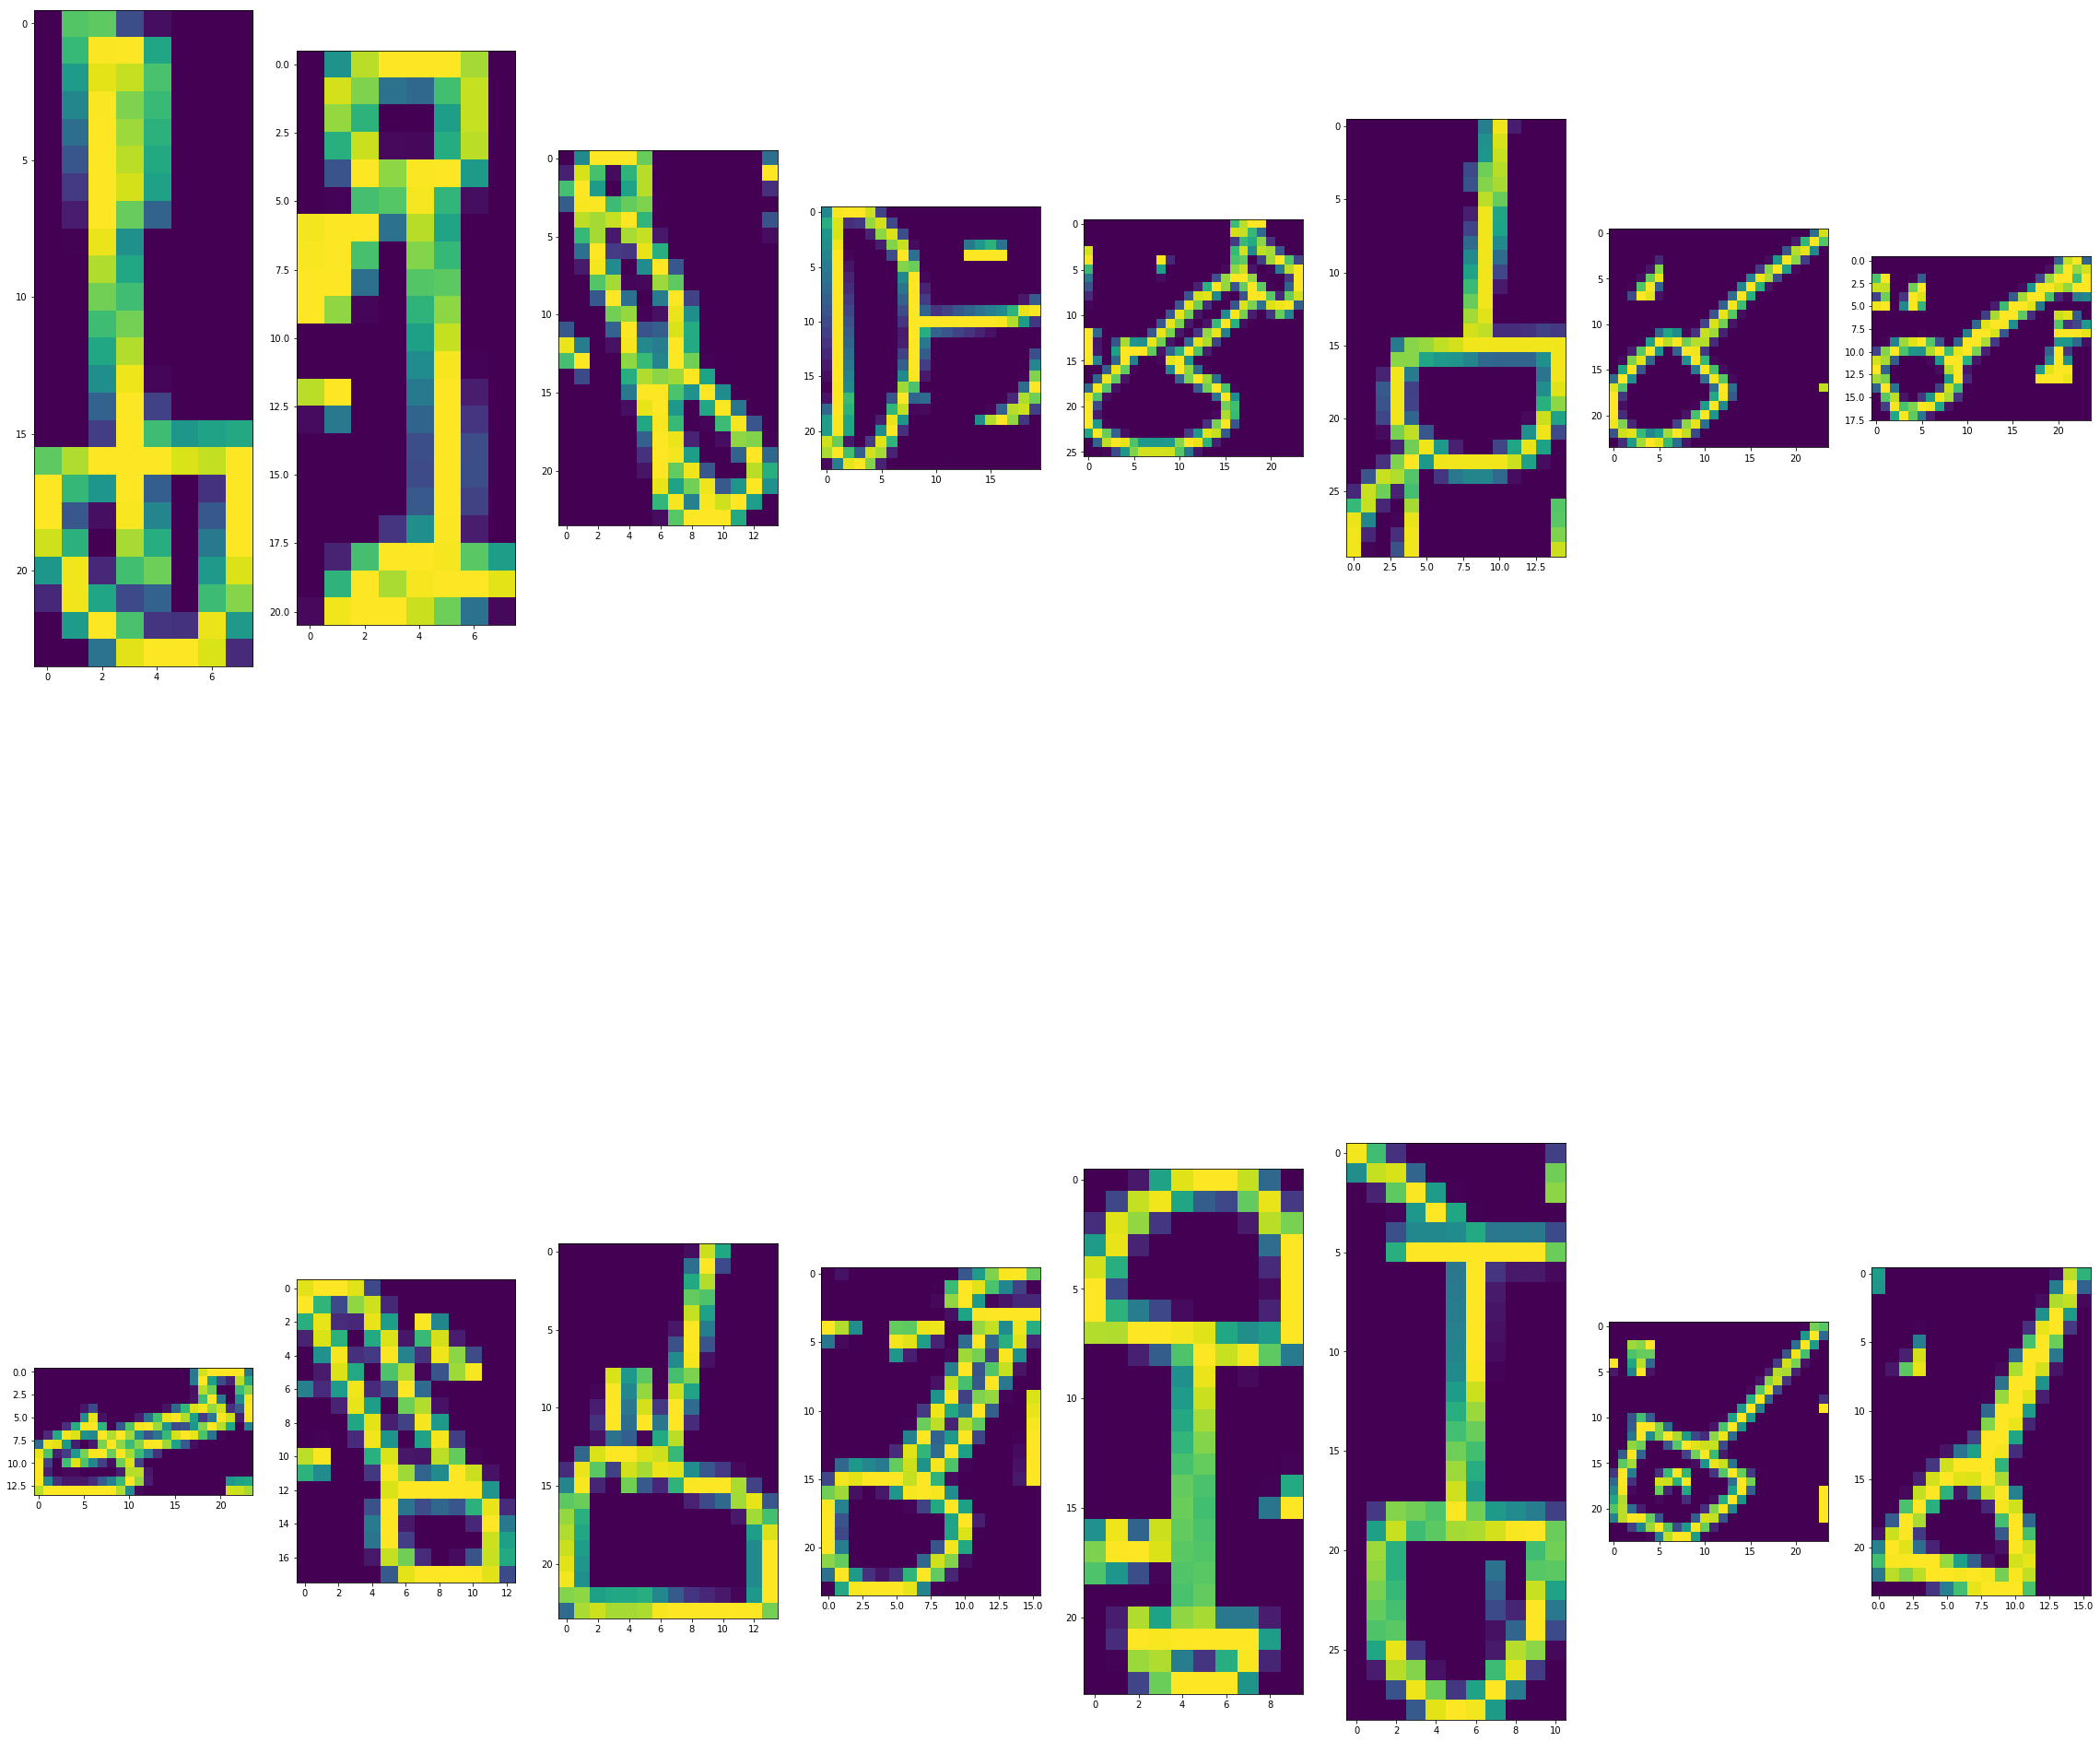

peanut


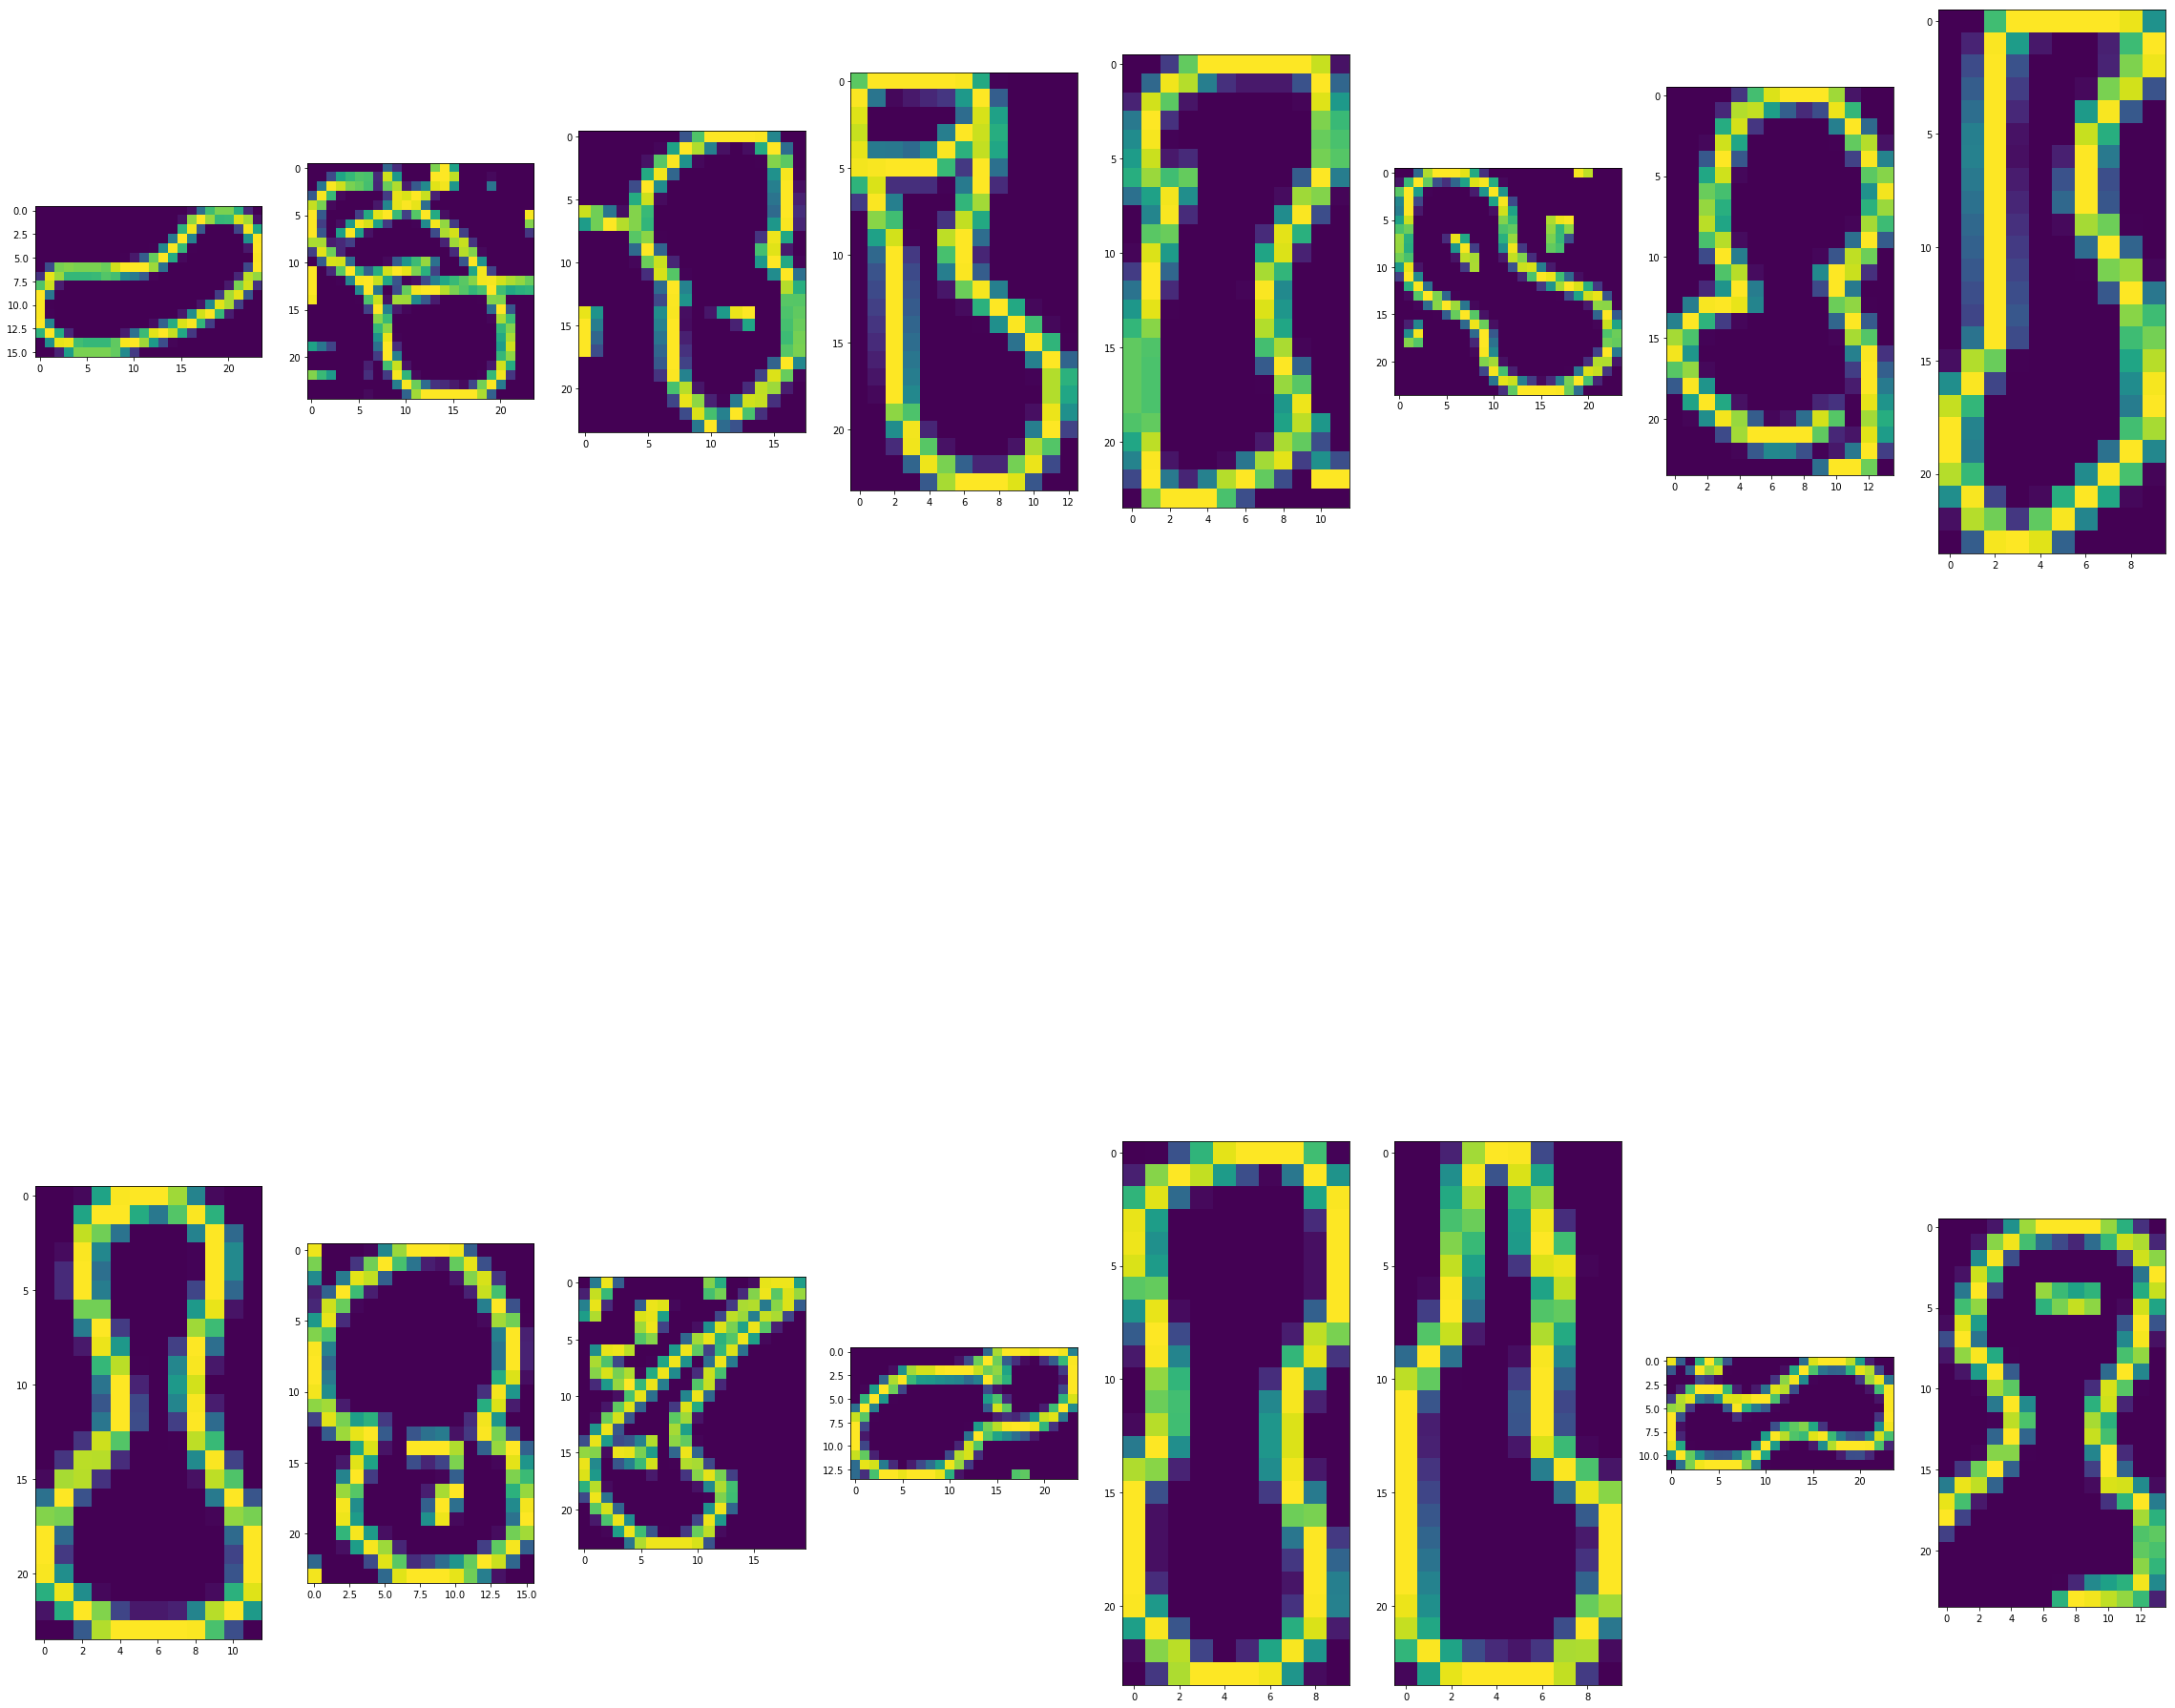

nose


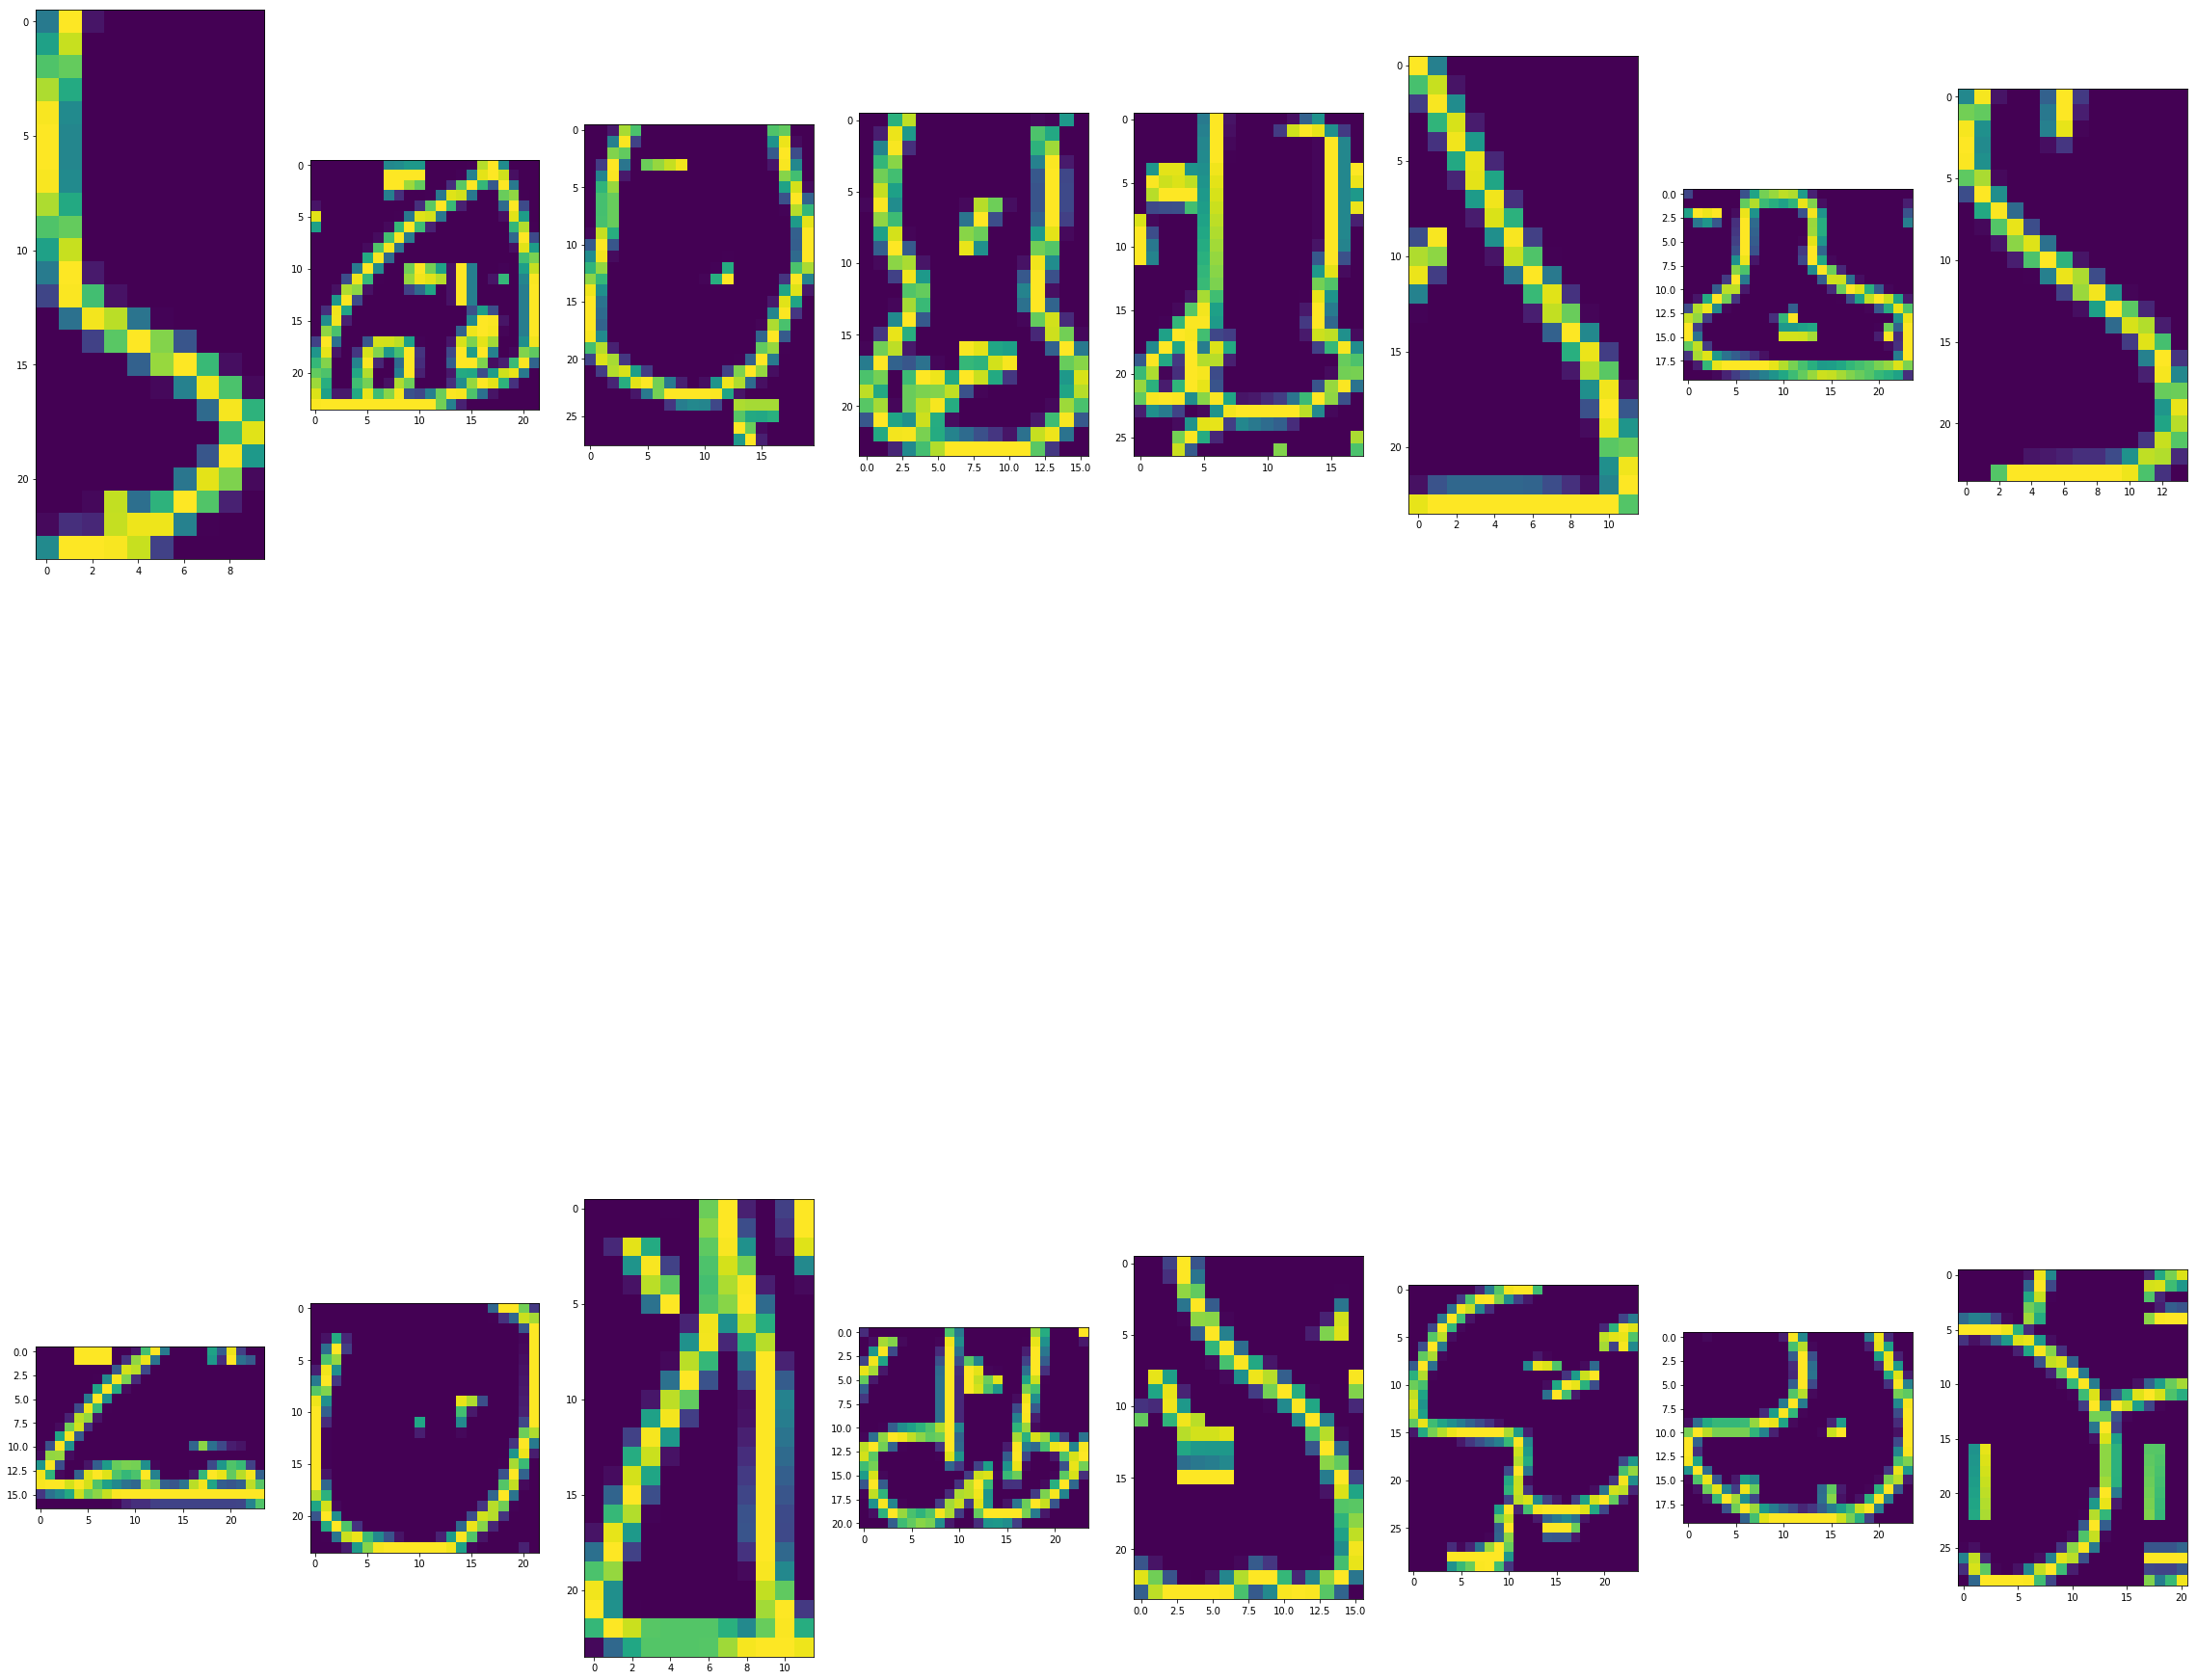

pencil


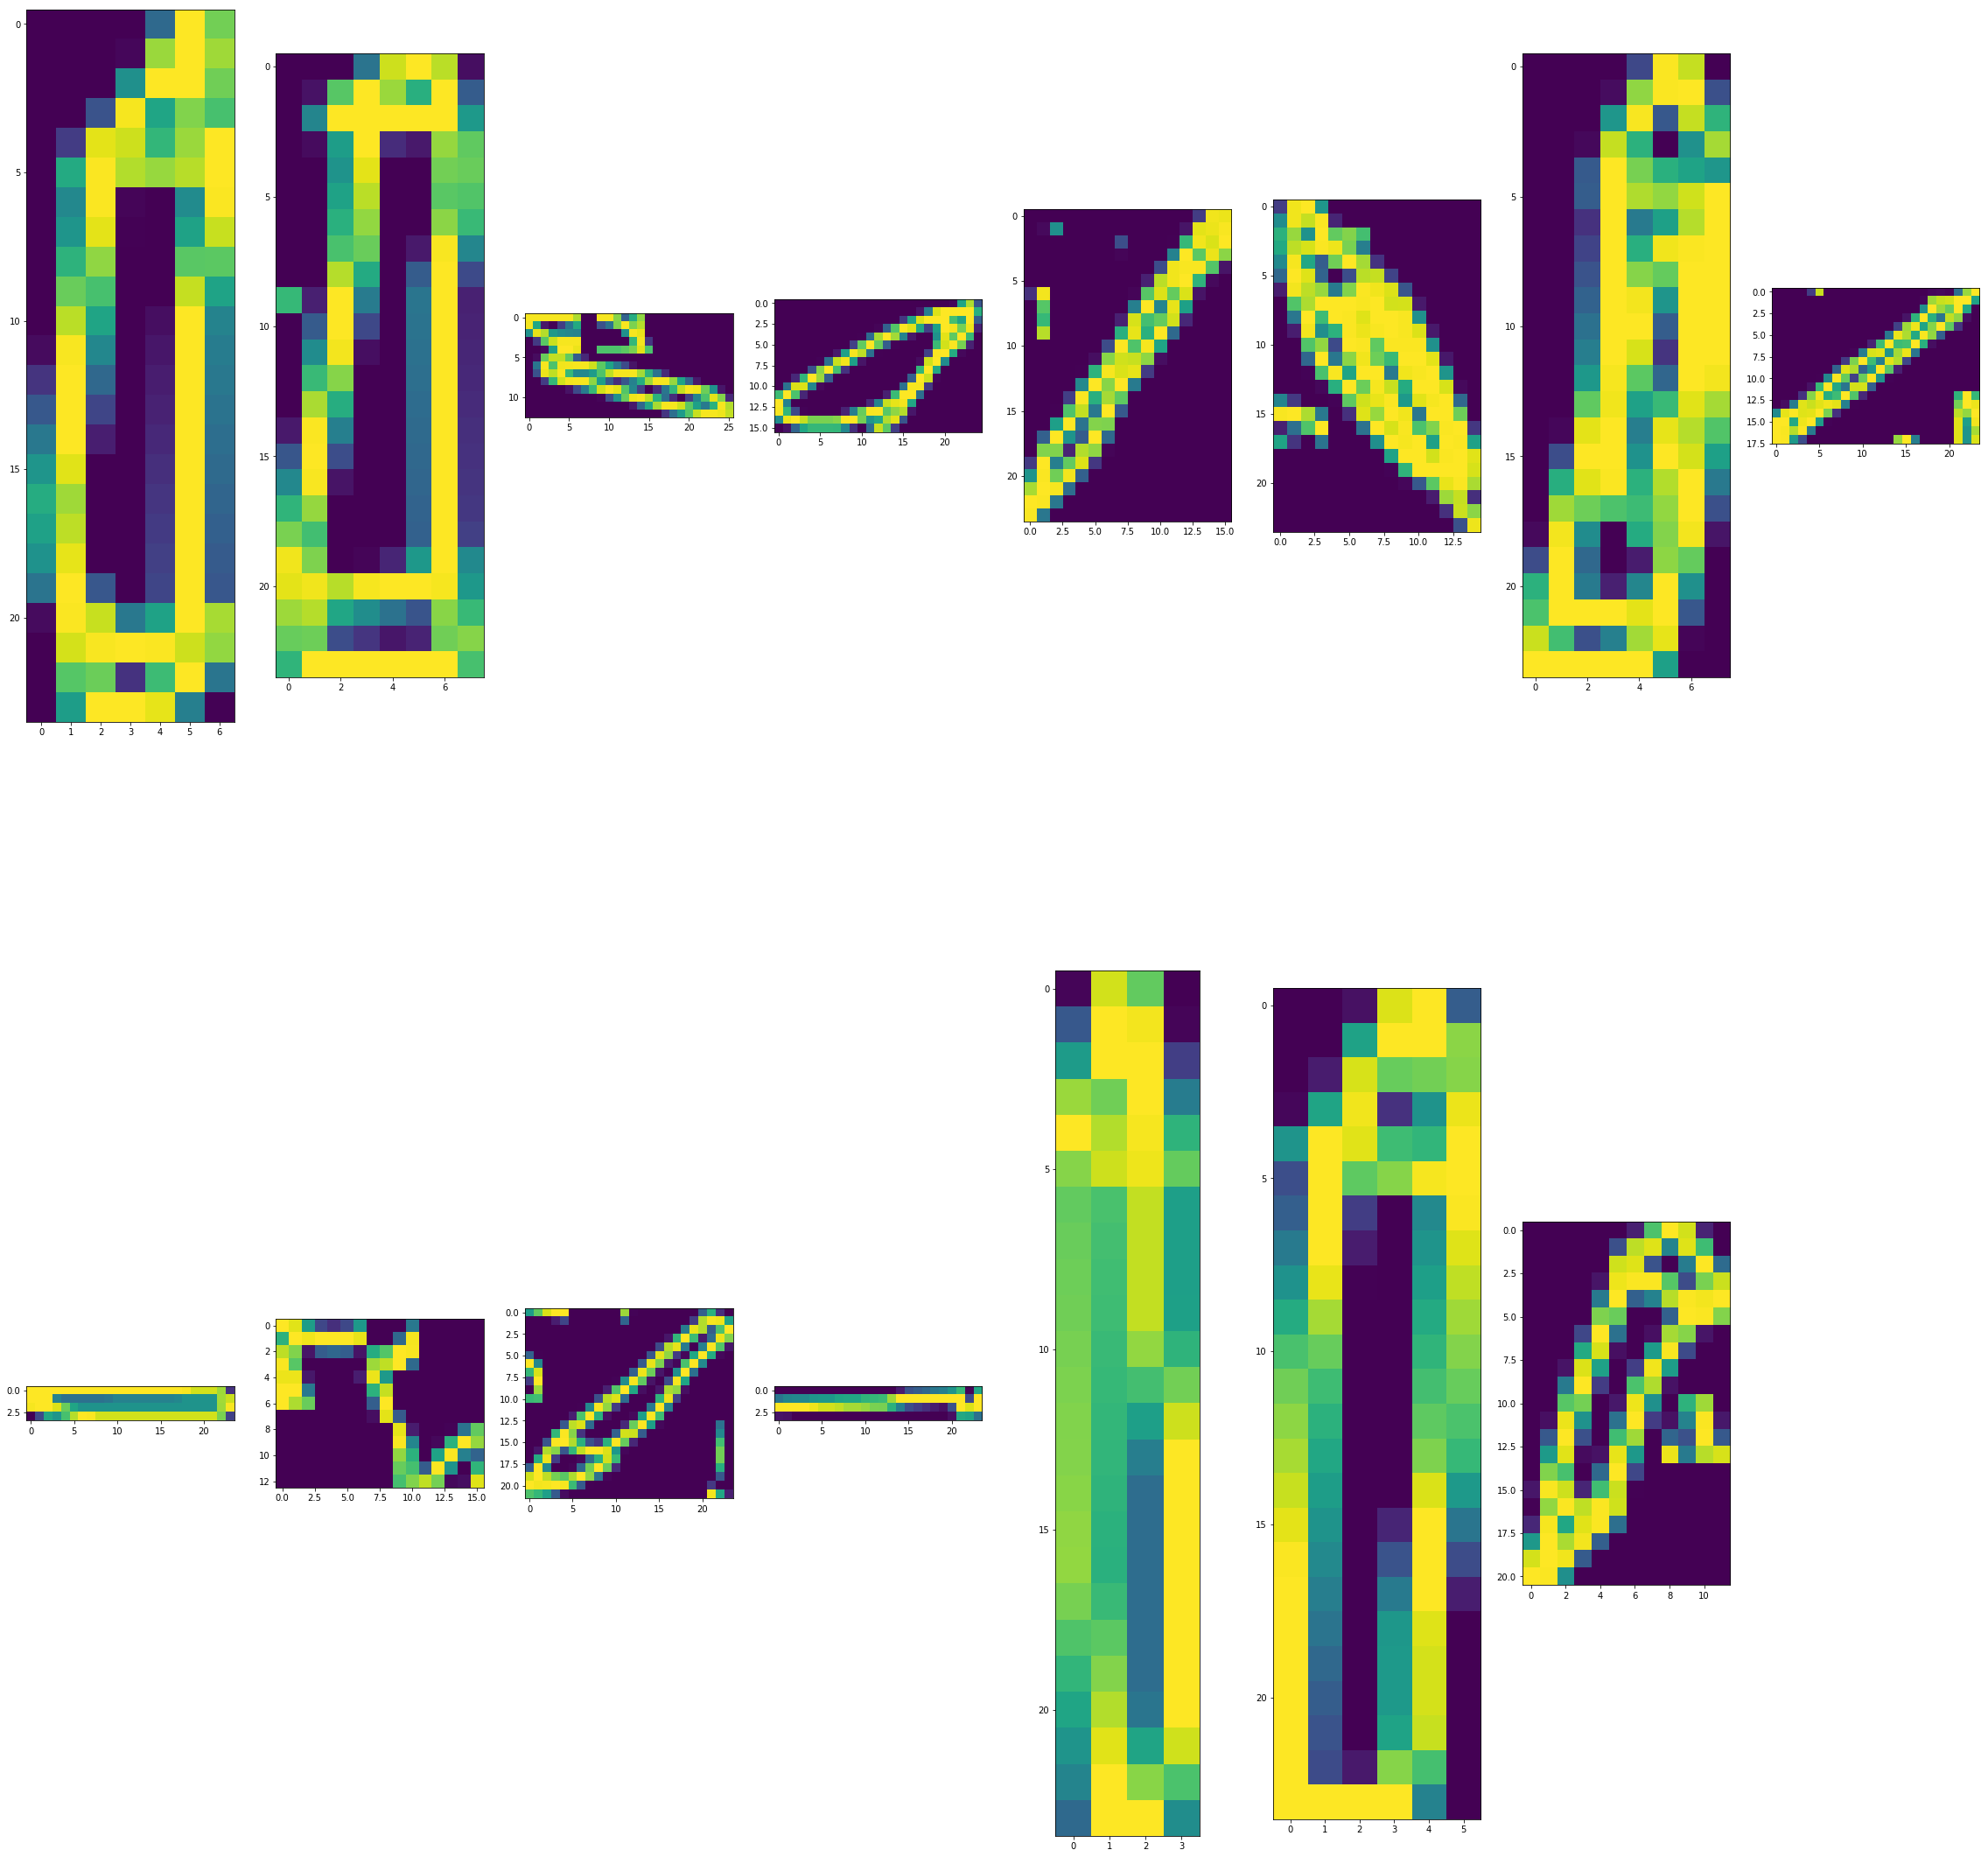

squiggle


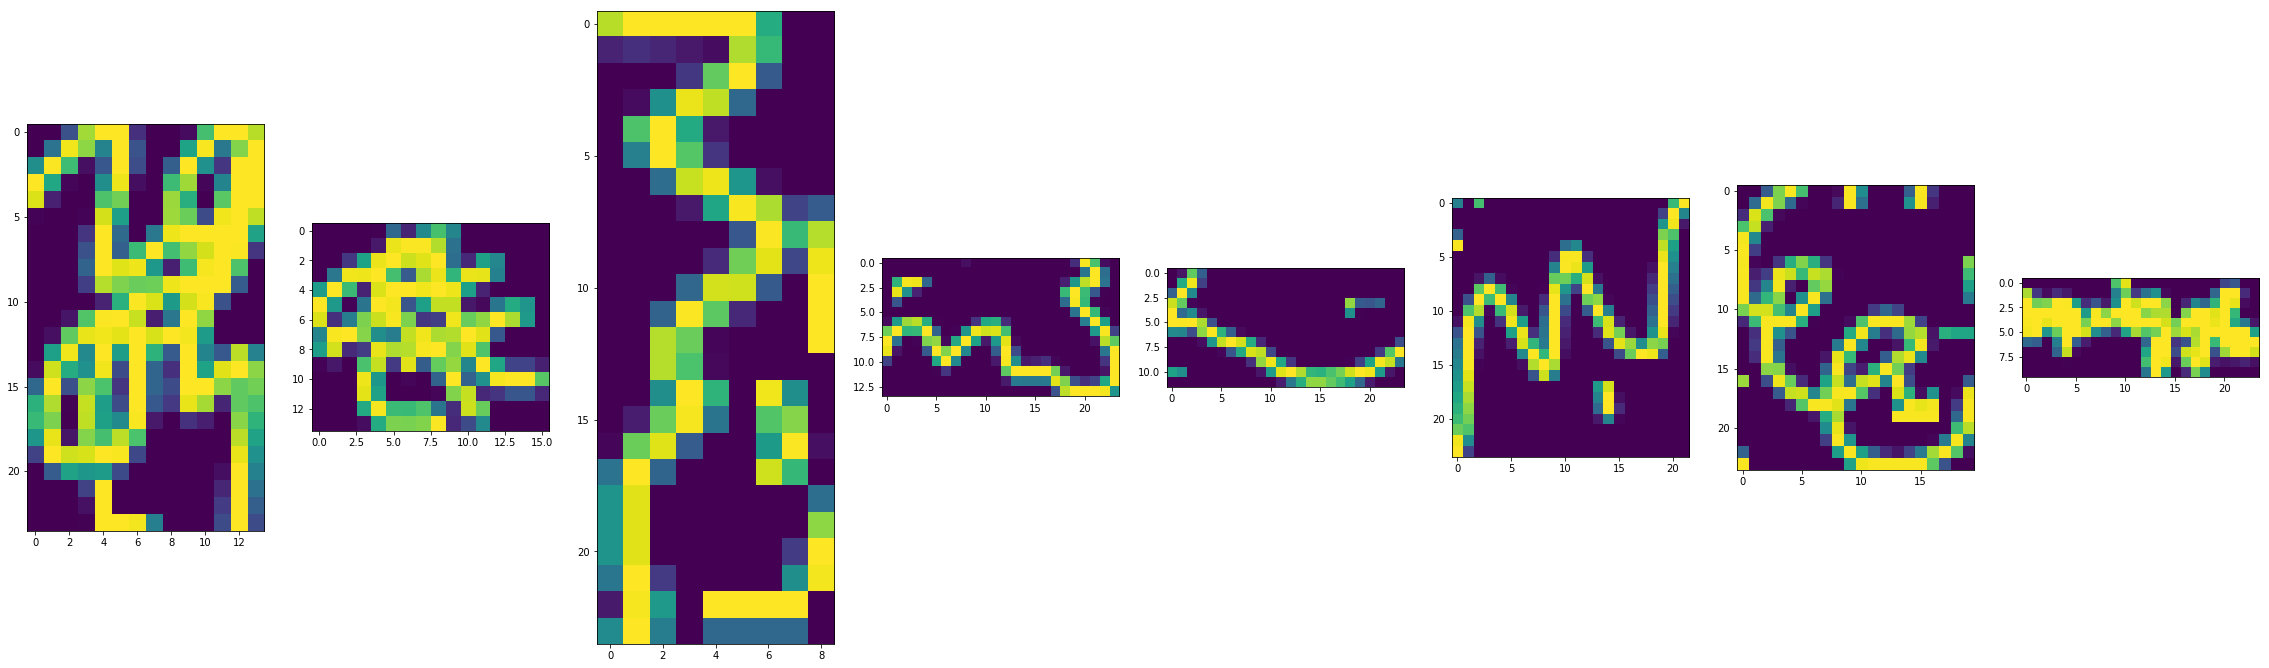

In [20]:
count = Counter([x['label'] for x in cropped])


for key, freq in count.most_common():
    print(key)
    imgs = [proc_img for proc_img in [x['cropped'] for x in cropped if x['label'] == key]]
    columns = 8
    rows = int(np.floor(len(imgs) / columns))
    fig=plt.figure(figsize=(40, 40))

    for i in range(1, columns*rows +1):
        if i < len(imgs):
            fig.add_subplot(rows, columns, i)
            plt.imshow(imgs[i])
    plt.show()

[0. 0. 0. ... 0. 0. 0.]


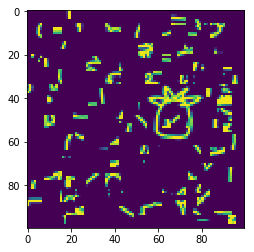

[0. 0. 0. ... 0. 0. 0.]


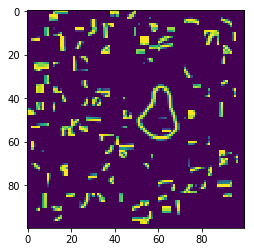

[0. 0. 0. ... 0. 0. 0.]


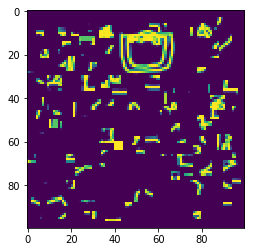

[0. 0. 0. ... 0. 0. 0.]


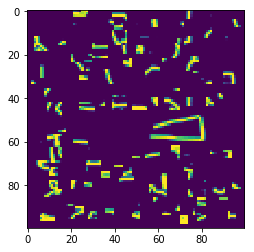

[0. 0. 0. ... 0. 0. 0.]


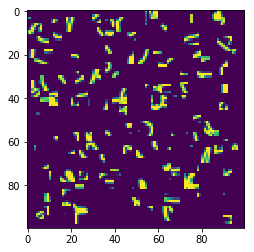

[22.  0.  0. ...  0.  0.  0.]


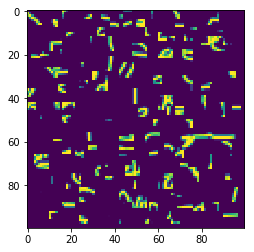

[0. 0. 0. ... 0. 0. 0.]


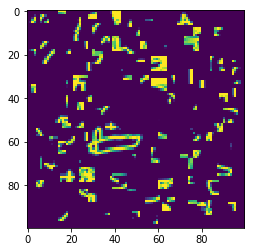

[0. 0. 0. ... 0. 0. 0.]


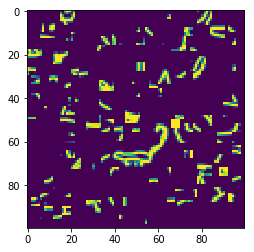

[0. 0. 0. ... 0. 0. 0.]


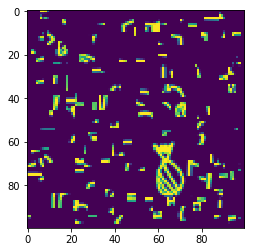

[0. 0. 0. ... 0. 0. 0.]


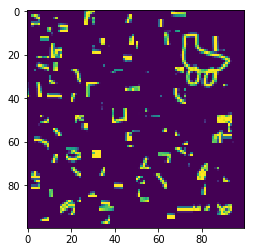

[0. 0. 0. ... 0. 0. 0.]


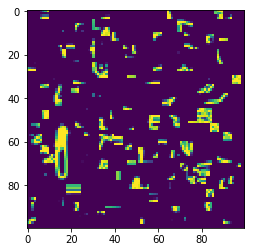

[244. 163. 200. ...   0.   0.   0.]


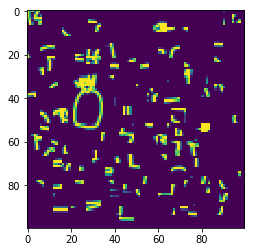

[0. 0. 0. ... 0. 0. 0.]


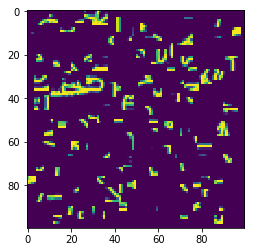

[0. 0. 0. ... 0. 0. 0.]


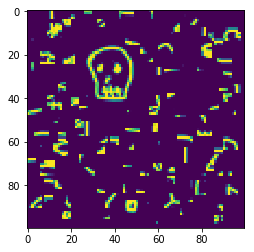

[0. 0. 0. ... 0. 0. 0.]


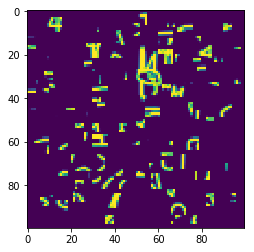

[255. 170.   2. ...   0.   0.   0.]


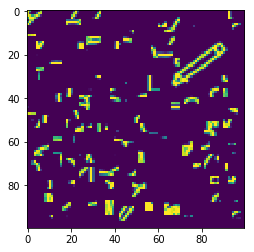

[ 0.  0. 15. ...  0.  0.  0.]


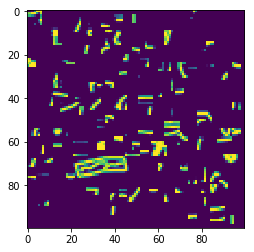

[255.  93.   0. ...   0.   0.   0.]


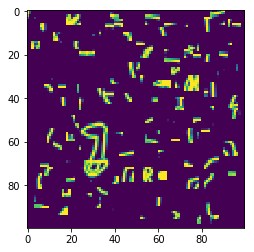

[0. 0. 0. ... 0. 0. 0.]


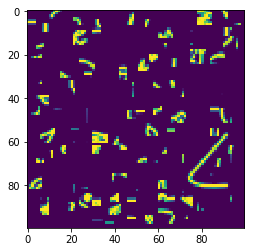

[0. 0. 0. ... 0. 0. 0.]


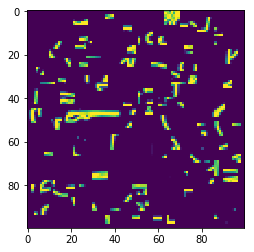

[0. 0. 0. ... 0. 0. 0.]


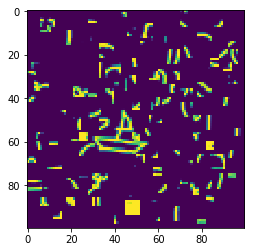

[0. 0. 0. ... 0. 0. 0.]


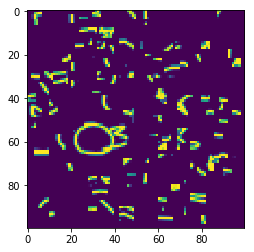

[0. 0. 0. ... 0. 0. 0.]


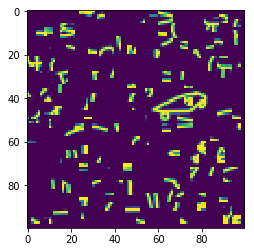

[0. 0. 0. ... 0. 0. 0.]


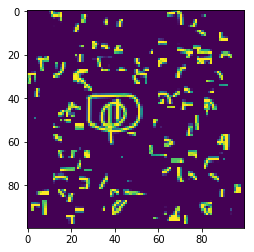

[0. 0. 0. ... 0. 0. 0.]


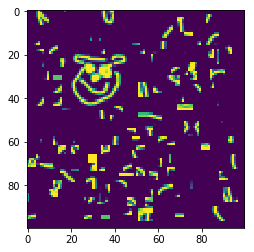

[  0.   0. 180. ...   0.   0.   0.]


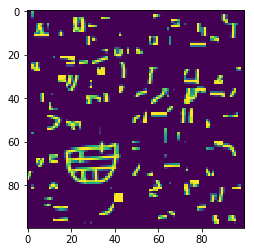

[0. 0. 0. ... 0. 0. 0.]


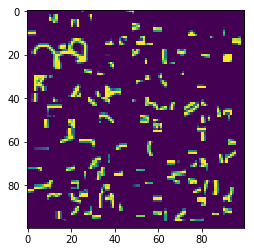

[  0.   0. 108. ...   0.   0.   0.]


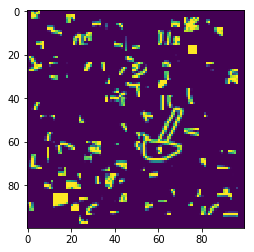

[ 0.  0. 10. ...  0.  0.  0.]


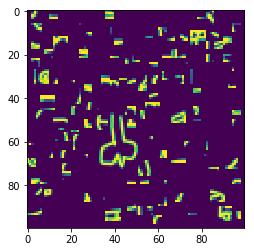

[0. 0. 0. ... 0. 0. 0.]


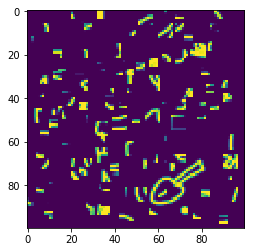

[0. 0. 0. ... 0. 0. 0.]


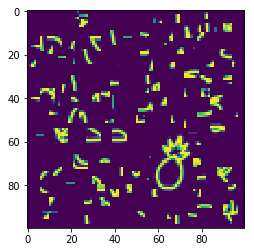

[0. 0. 0. ... 0. 0. 0.]


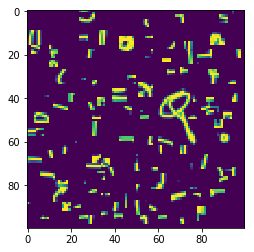

[0. 0. 0. ... 0. 0. 0.]


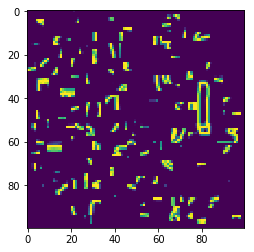

[  0.   0. 169. ...   0.   0.   0.]


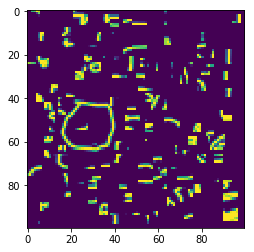

[0. 0. 0. ... 0. 0. 0.]


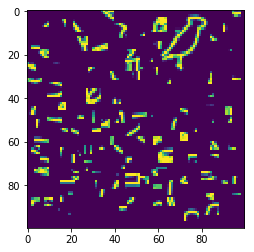

[0. 0. 0. ... 0. 0. 0.]


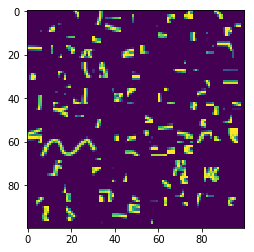

[0. 0. 0. ... 0. 0. 0.]


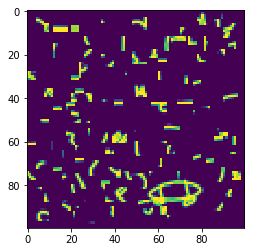

[0. 0. 0. ... 0. 0. 0.]


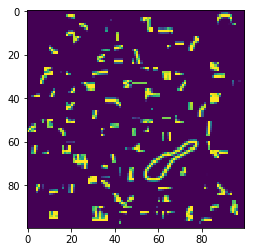

[0. 0. 0. ... 0. 0. 0.]


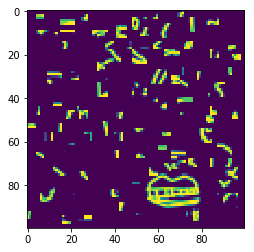

[0. 0. 0. ... 0. 0. 0.]


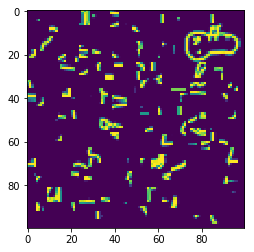

[0. 0. 0. ... 0. 0. 0.]


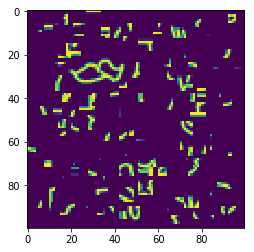

[0. 0. 0. ... 0. 0. 0.]


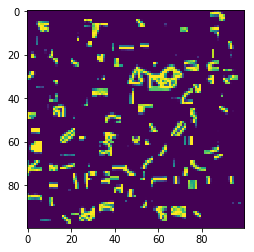

[0. 0. 0. ... 0. 0. 0.]


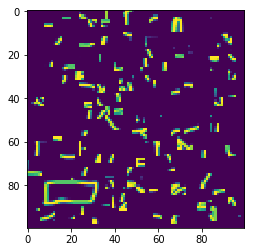

[0. 0. 0. ... 0. 0. 0.]


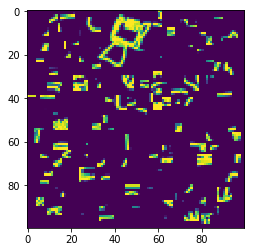

[  0.   0. 255. ...   0.   0.   0.]


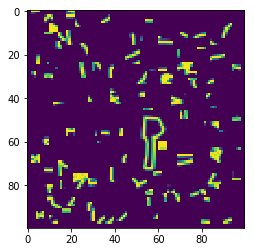

[0. 0. 0. ... 0. 0. 0.]


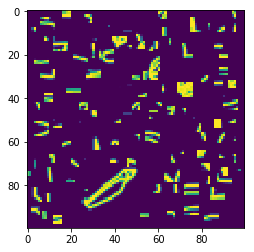

[0. 0. 0. ... 0. 0. 0.]


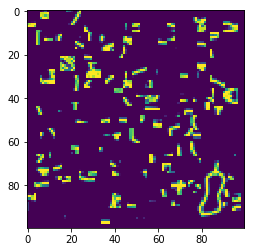

[0. 0. 0. ... 0. 0. 0.]


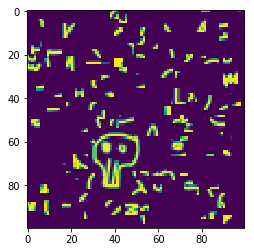

[0. 0. 0. ... 0. 0. 0.]


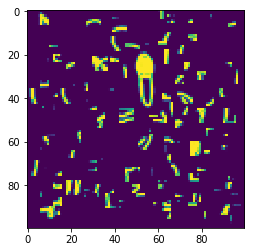

[0. 0. 0. ... 0. 0. 0.]


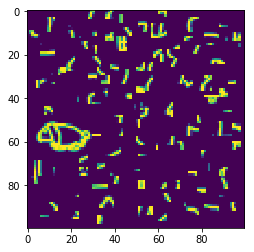

[0. 0. 0. ... 0. 0. 0.]


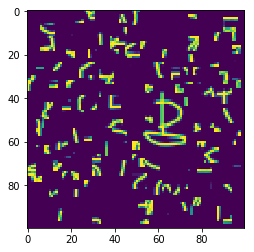

[0. 0. 0. ... 0. 0. 0.]


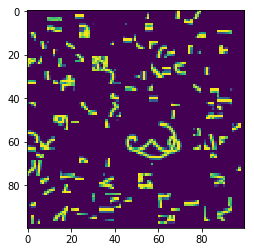

[0. 0. 0. ... 0. 0. 0.]


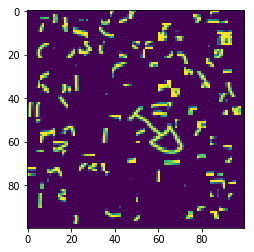

[0. 0. 0. ... 0. 0. 0.]


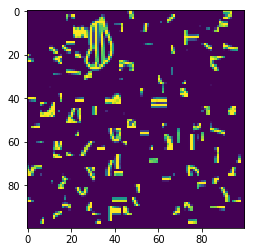

[0. 0. 0. ... 0. 0. 0.]


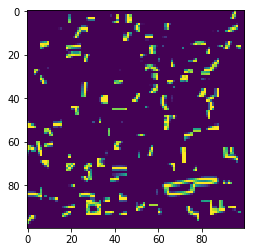

[0. 0. 0. ... 0. 0. 0.]


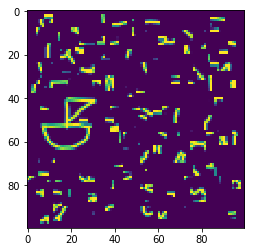

[0. 0. 0. ... 0. 0. 0.]


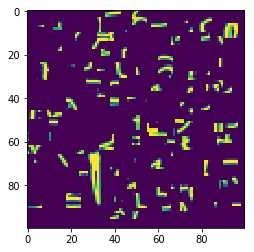

[0. 0. 0. ... 0. 0. 0.]


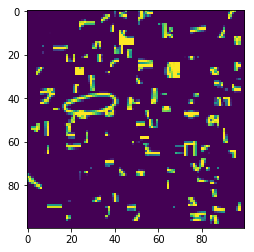

[0. 0. 0. ... 0. 0. 0.]


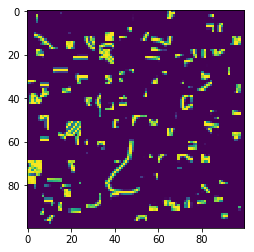

[0. 0. 0. ... 0. 0. 0.]


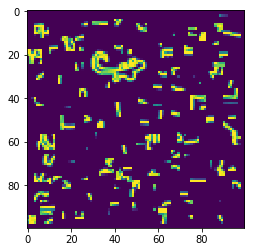

[0. 0. 0. ... 0. 0. 0.]


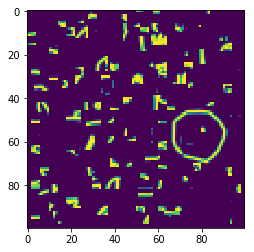

[0. 0. 0. ... 0. 0. 0.]


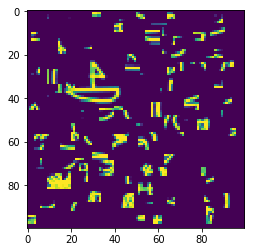

[0. 0. 0. ... 0. 0. 0.]


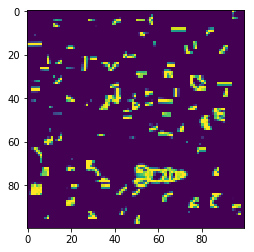

[0. 0. 0. ... 0. 0. 0.]


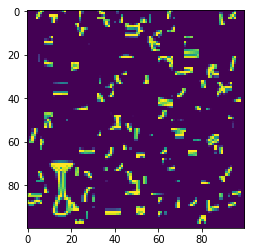

[242.   0. 179. ...   0.   0.   0.]


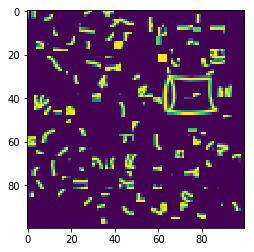

[0. 0. 0. ... 0. 0. 0.]


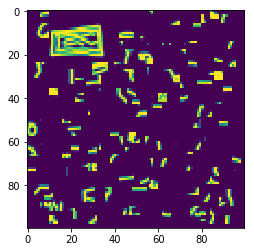

[0. 0. 0. ... 0. 0. 0.]


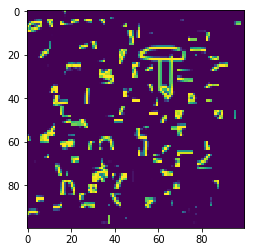

[0. 0. 0. ... 0. 0. 0.]


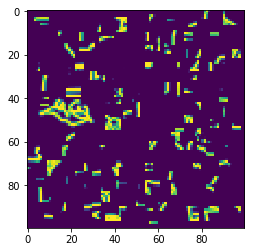

[0. 0. 0. ... 0. 0. 0.]


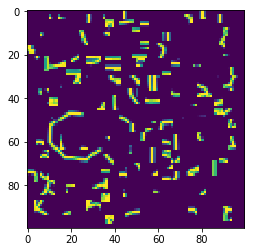

[0. 0. 0. ... 0. 0. 0.]


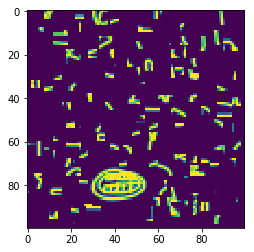

[0. 0. 0. ... 0. 0. 0.]


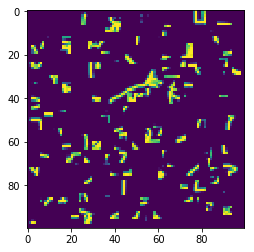

[0. 0. 0. ... 0. 0. 0.]


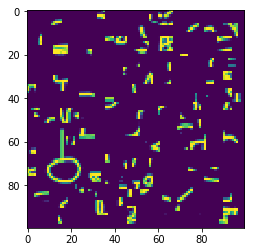

[0. 0. 0. ... 0. 0. 0.]


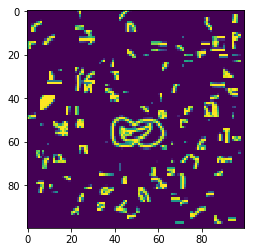

[0. 0. 0. ... 0. 0. 0.]


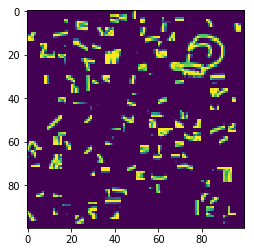

[0. 0. 0. ... 0. 0. 0.]


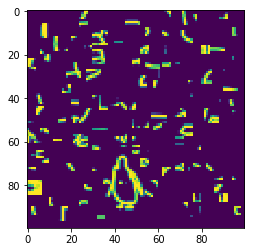

[0. 0. 0. ... 0. 0. 0.]


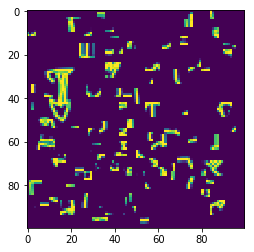

[ 62.  97. 132. ...   0.   0.   0.]


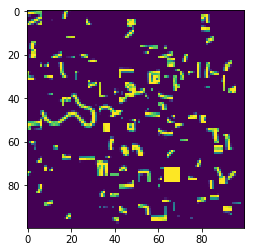

[0. 0. 0. ... 0. 0. 0.]


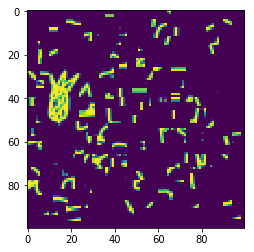

[0. 0. 0. ... 0. 0. 0.]


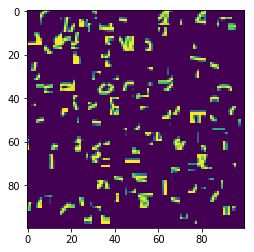

[0. 0. 0. ... 0. 0. 0.]


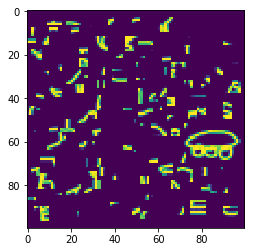

[0. 0. 0. ... 0. 0. 0.]


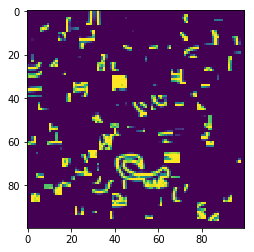

[0. 0. 0. ... 0. 0. 0.]


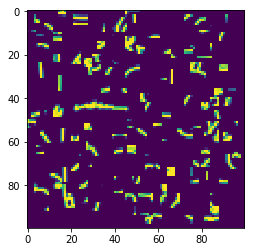

[0. 0. 0. ... 0. 0. 0.]


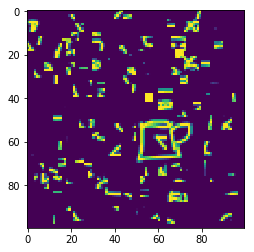

[0. 0. 0. ... 0. 0. 0.]


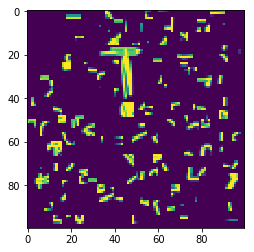

[0. 0. 0. ... 0. 0. 0.]


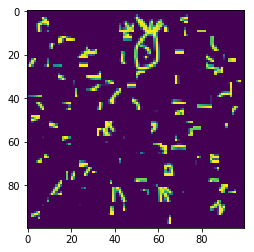

[0. 0. 0. ... 0. 0. 0.]


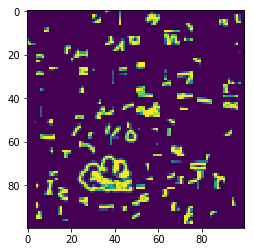

[0. 0. 0. ... 0. 0. 0.]


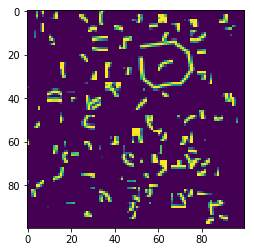

[0. 0. 0. ... 0. 0. 0.]


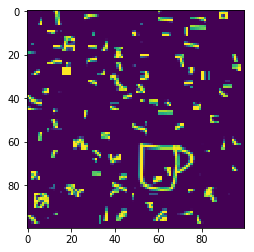

[0. 0. 0. ... 0. 0. 0.]


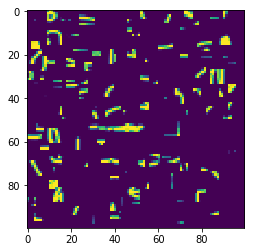

[0. 0. 0. ... 0. 0. 0.]


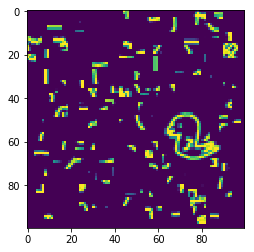

[0. 0. 0. ... 0. 0. 0.]


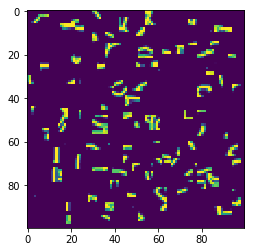

[0. 0. 0. ... 0. 0. 0.]


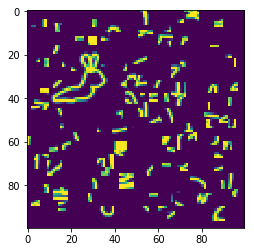

[0. 0. 0. ... 0. 0. 0.]


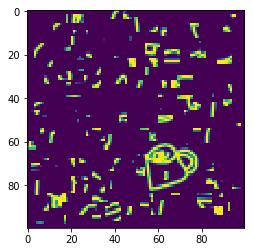

[0. 0. 0. ... 0. 0. 0.]


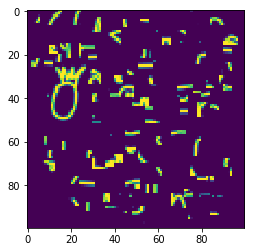

[0. 0. 0. ... 0. 0. 0.]


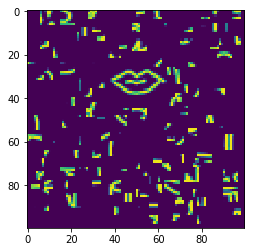

[0. 0. 0. ... 0. 0. 0.]


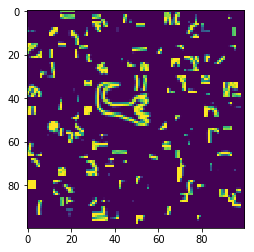

[0. 0. 0. ... 0. 0. 0.]


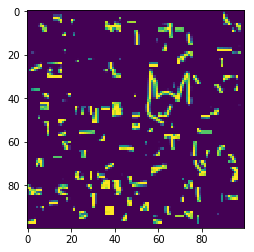

[0. 0. 0. ... 0. 0. 0.]


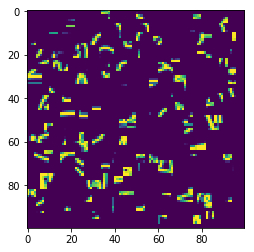

[0. 0. 0. ... 0. 0. 0.]


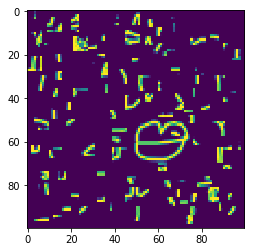

[0. 0. 0. ... 0. 0. 0.]


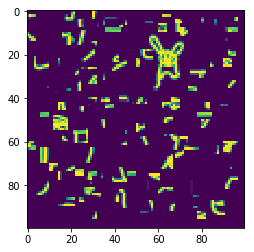

In [29]:
for index,test_image in enumerate(test_images):
    if index < 100:
        print(test_image[1])
        display_image(test_image[1].reshape(100,100))